# Reinforcement Learning hans-on by OpenAI Gym

必要なモジュールをインストール

In [1]:
# OpenAIGym環境
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# notebook内で環境表示するためのモジュール
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

# 強化学習のためのモジュール
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from rl.core import Processor
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, MaxBoltzmannQPolicy
from rl.memory import SequentialMemory

Using TensorFlow backend.


notebook内に動画を表示する関数を定義

In [2]:
# 参考: https://book.mynavi.jp/manatee/detail/id=88961
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    # plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

シミュレーション環境を定義([Pendulum-v0](https://gym.openai.com/envs/Pendulum-v0/))

In [3]:
env = gym.make('Pendulum-v0')

[GitHubのWiki](https://github.com/openai/gym/wiki)で環境の情報を確認する

環境情報を確認してみる

In [4]:
observation = env.reset()
print(observation)

[-0.77519467 -0.63172243 -0.86882603]


とれるActionを確認してみる

In [5]:
action = env.action_space.sample()
print(action)

[0.19525401]


行動を起こし、環境を変化させてみる

In [6]:
observation, reward, done, info = env.step(action)
print('observation', observation)
print('reward', reward)
print('done', done)
print('info', info)

observation [-0.8149771  -0.57949316 -1.31332975]
reward -6.116400757173949
done False
info {}


ランダム行動で1エピソード動かしてどのように動いたかを確認する


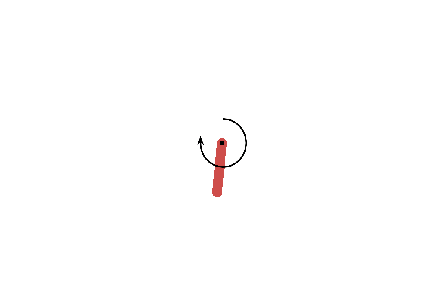
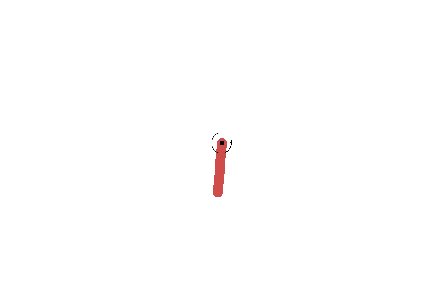
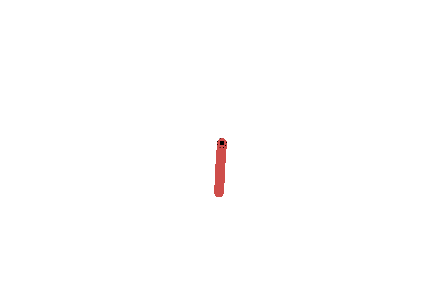
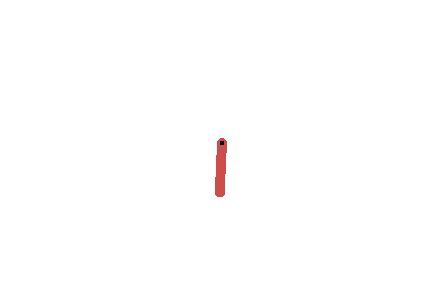
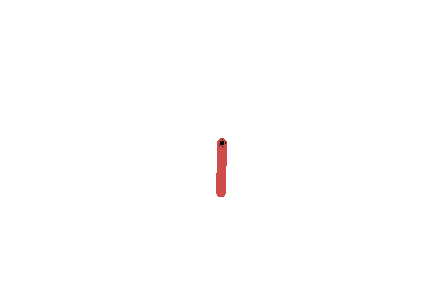
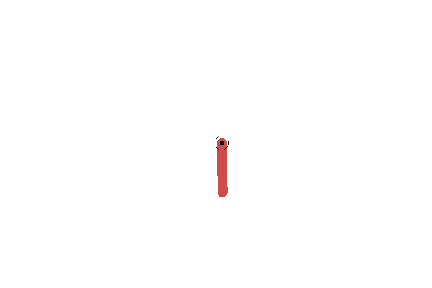
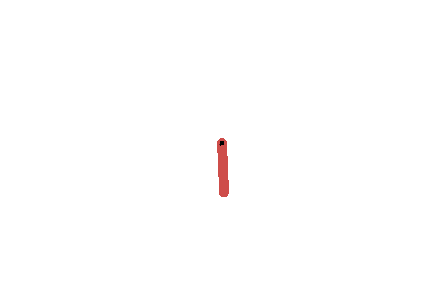
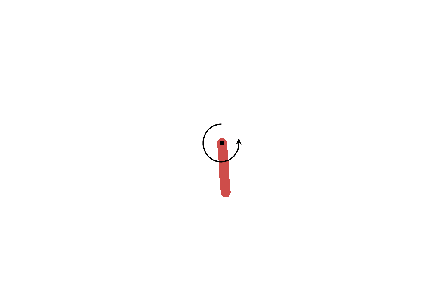
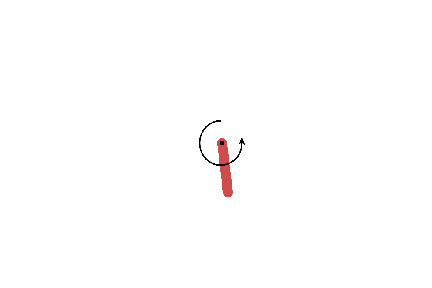
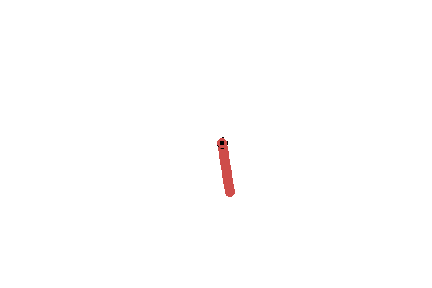
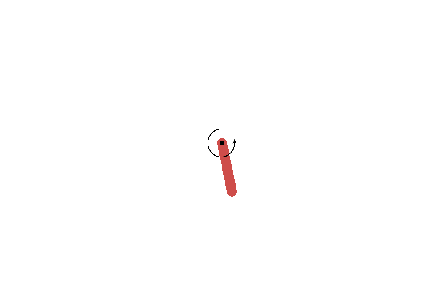
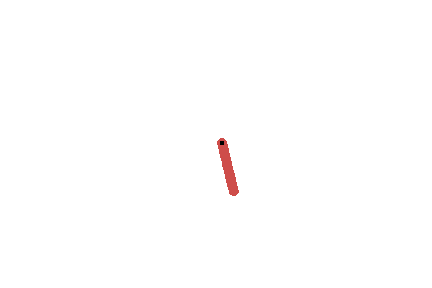
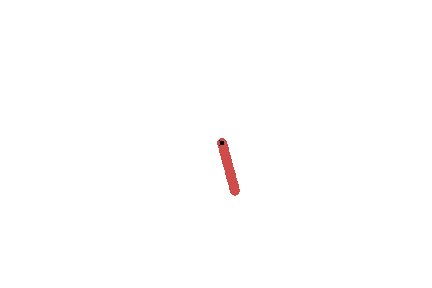
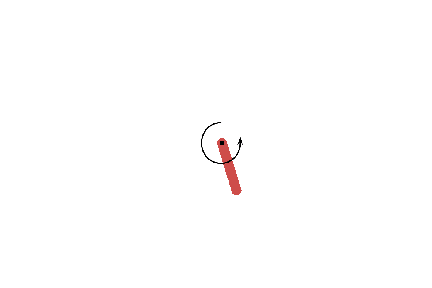
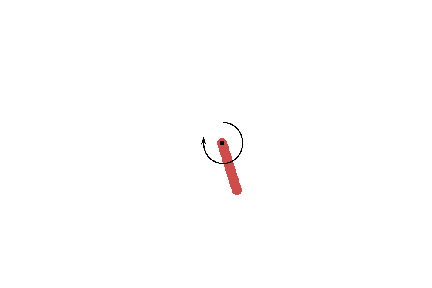
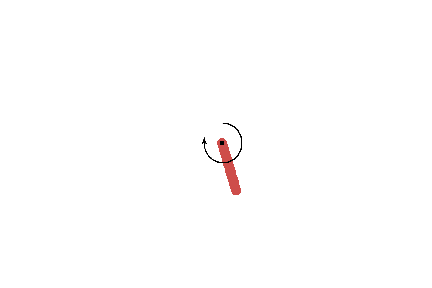
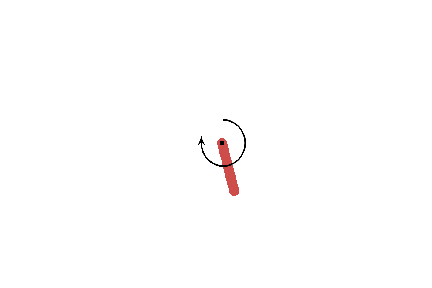
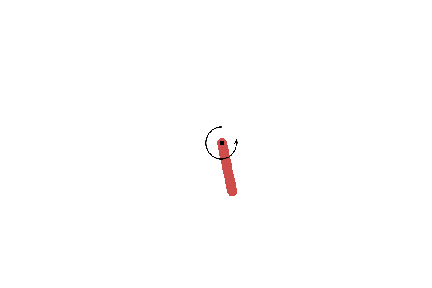
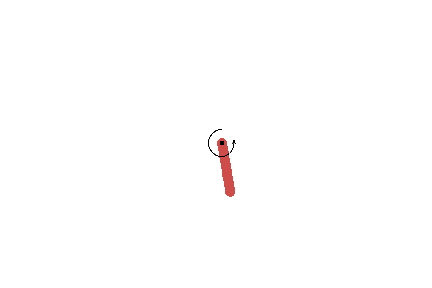
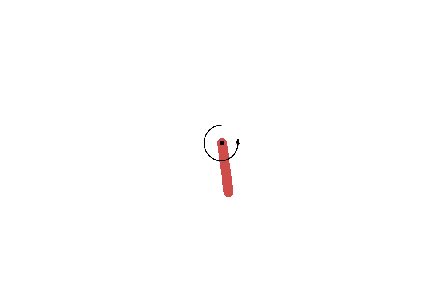
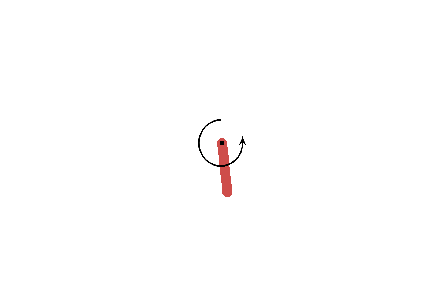
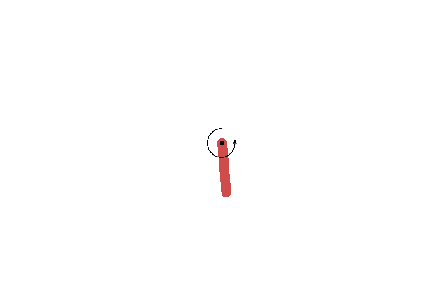
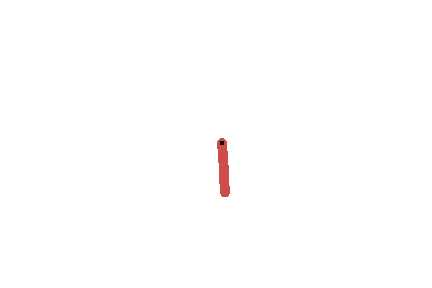
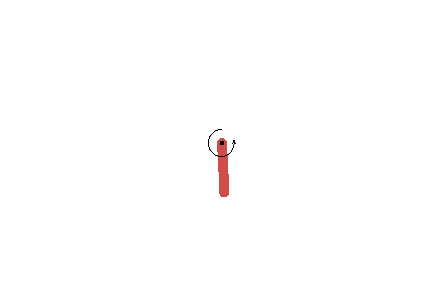
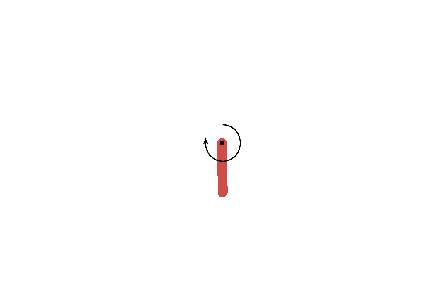
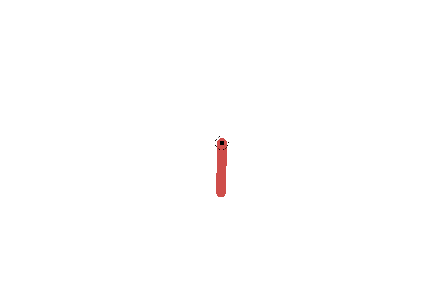
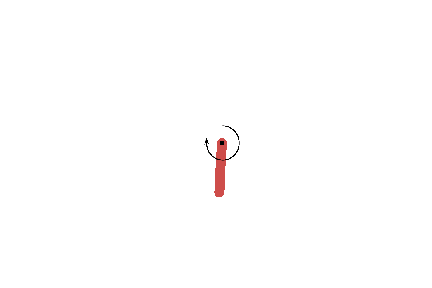
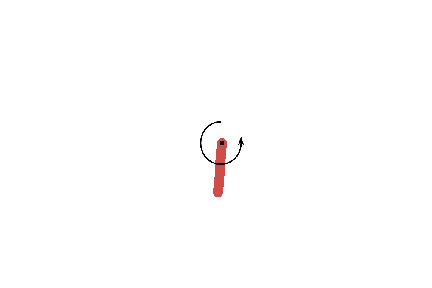
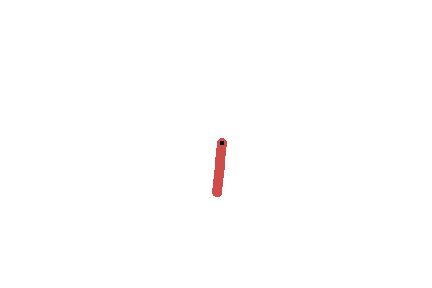
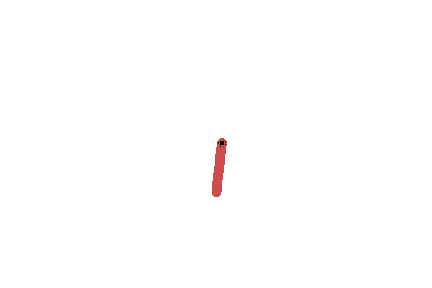
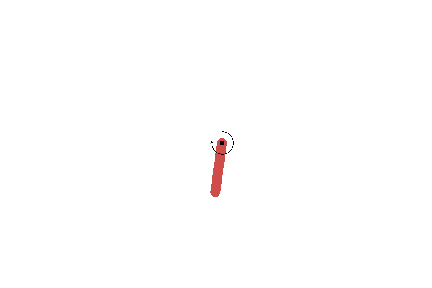
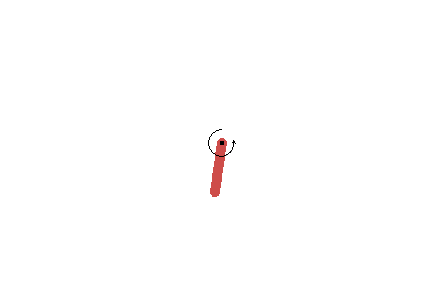
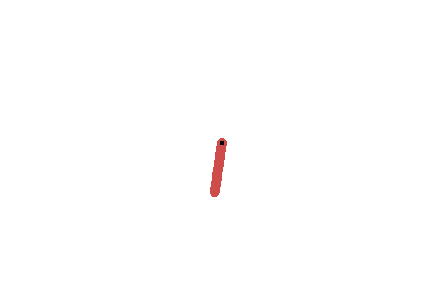
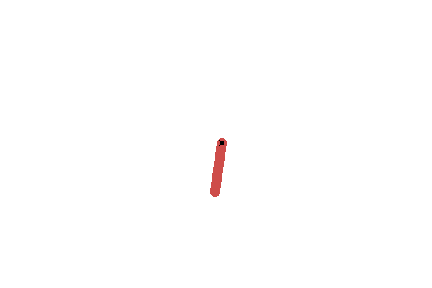
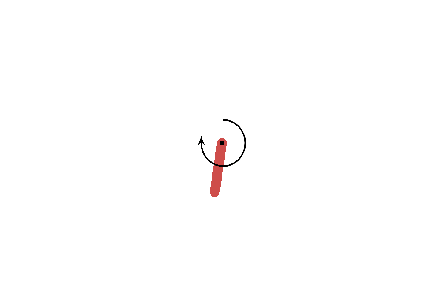
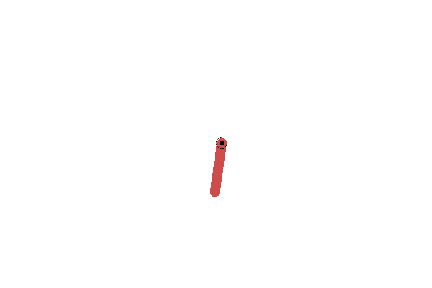
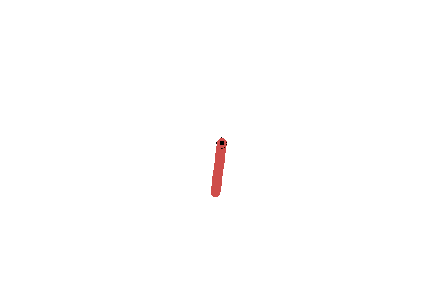
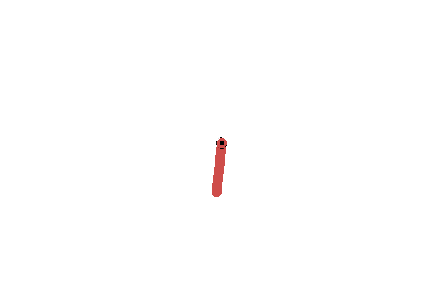
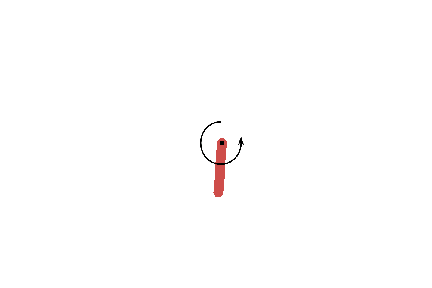
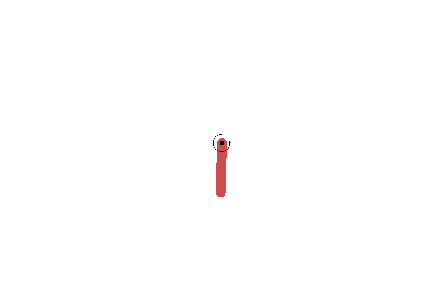
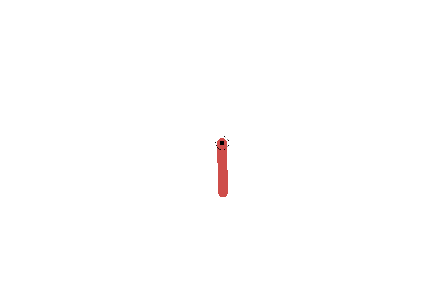
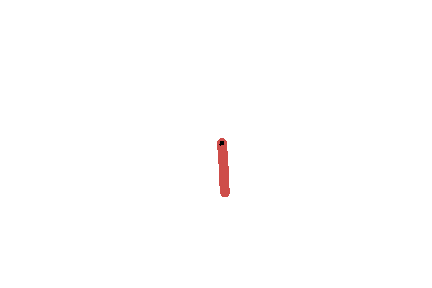
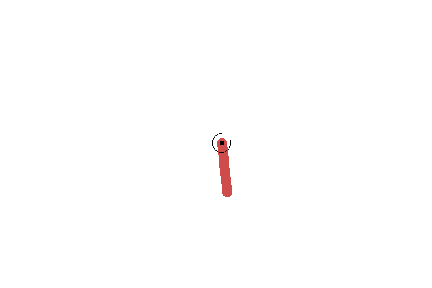
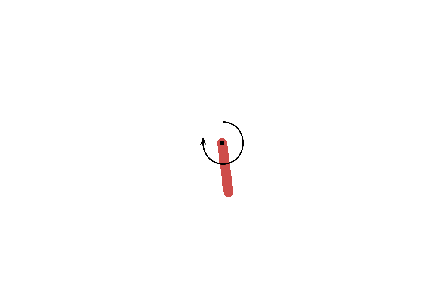
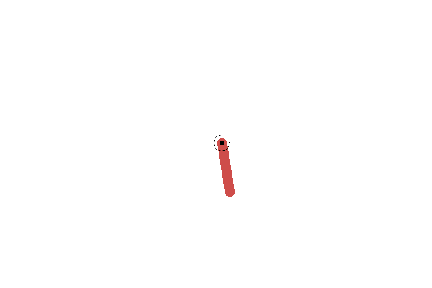
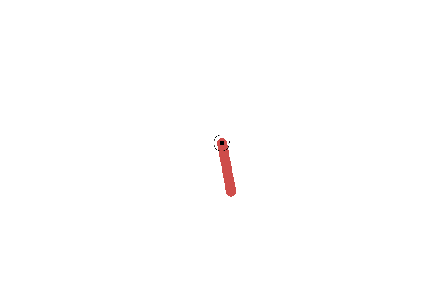
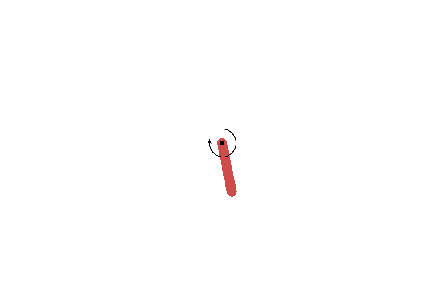
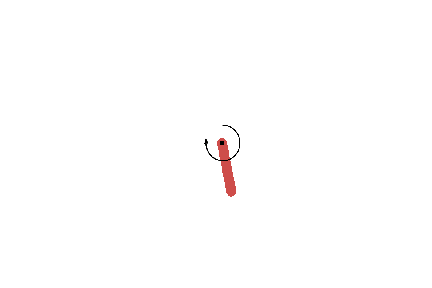
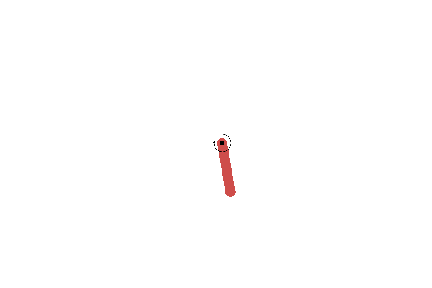
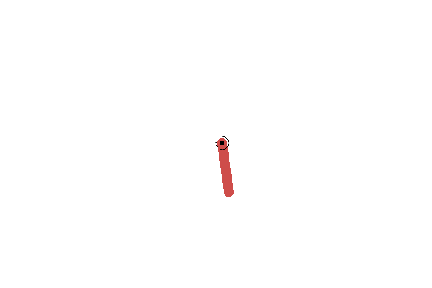
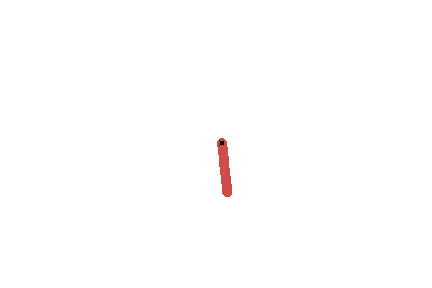
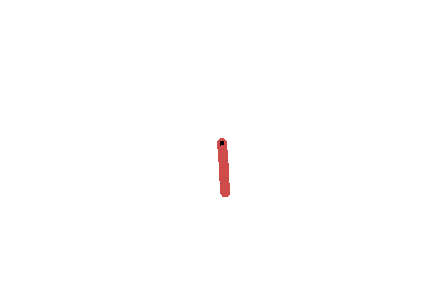
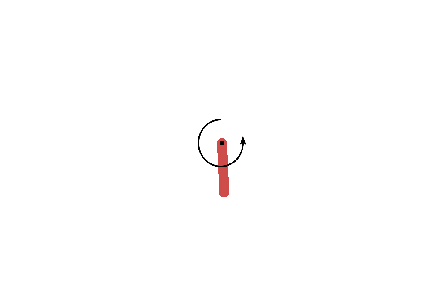
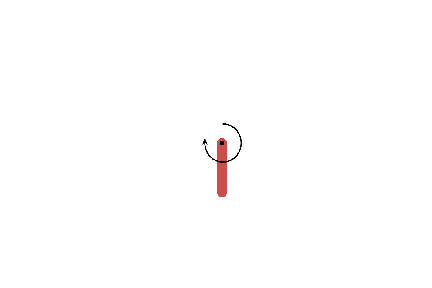
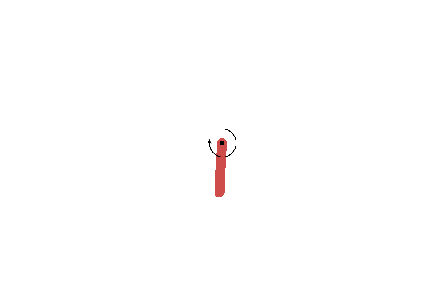
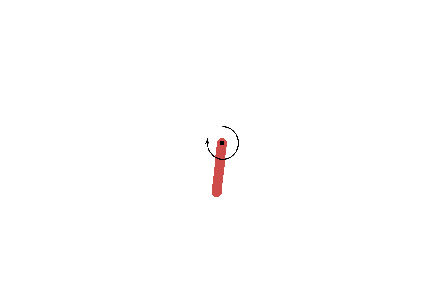
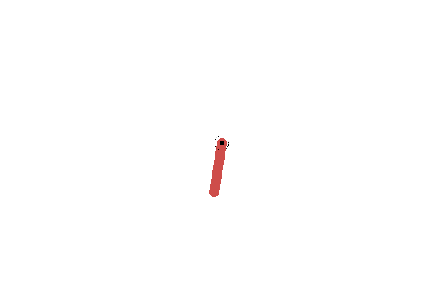
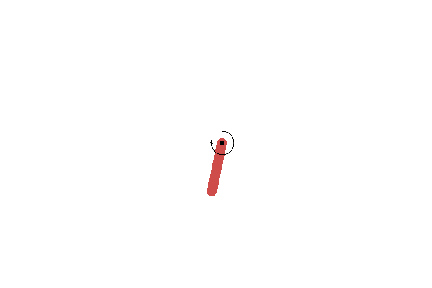
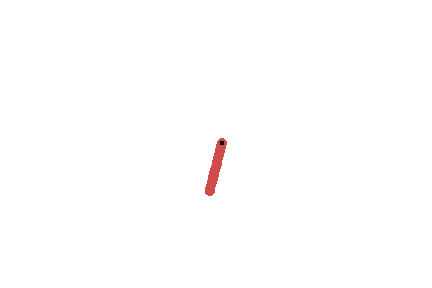
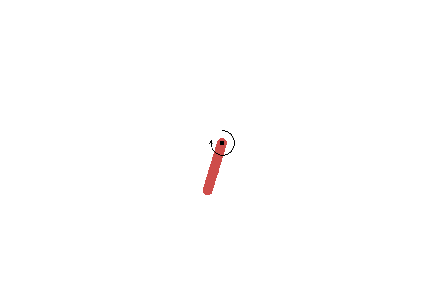
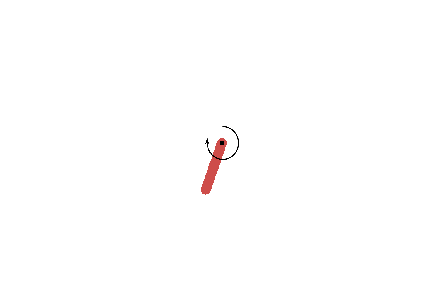
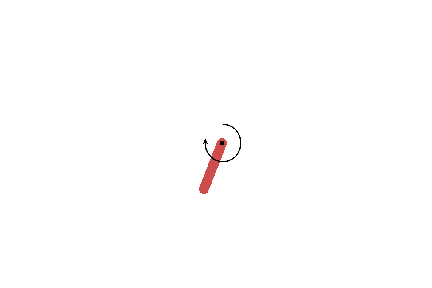
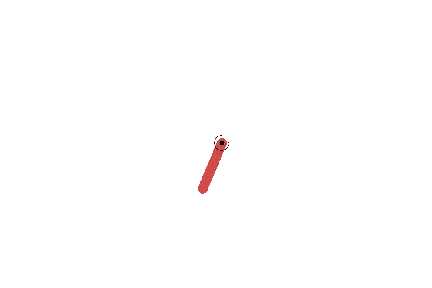
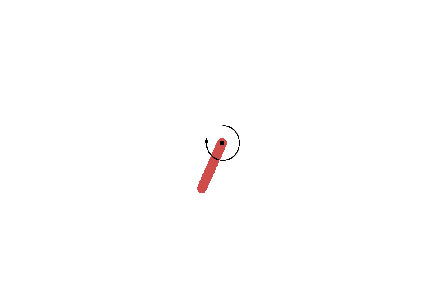
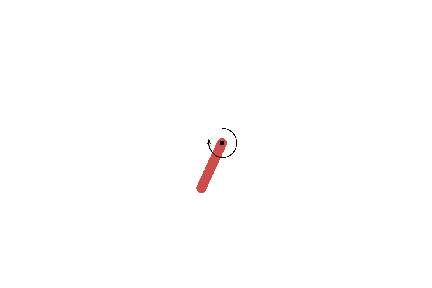
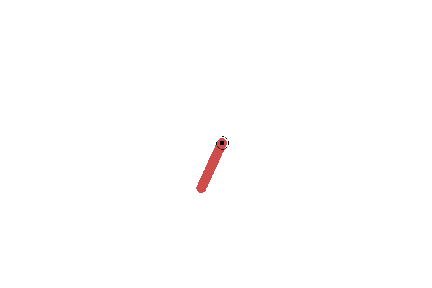
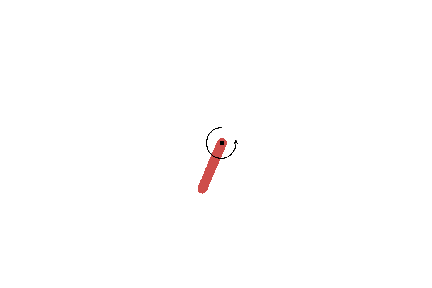
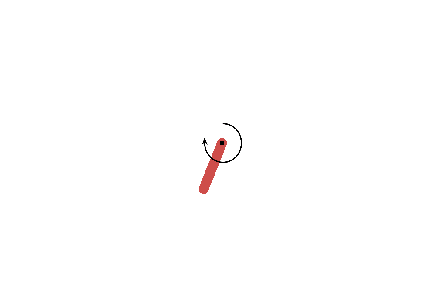
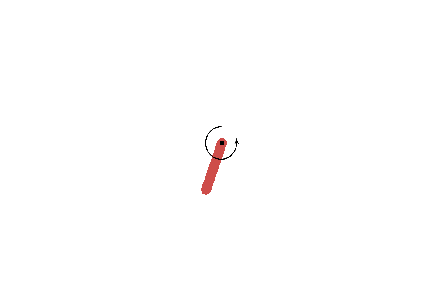
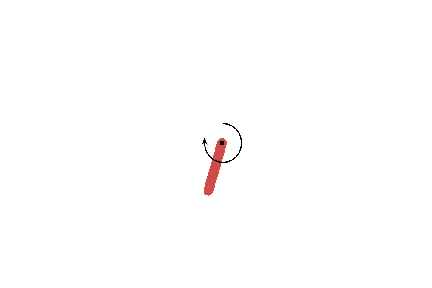
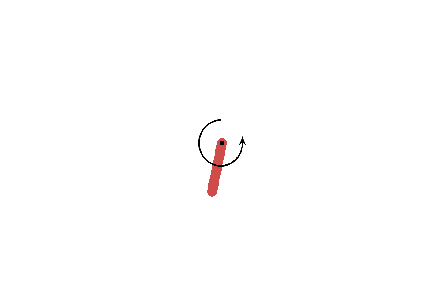
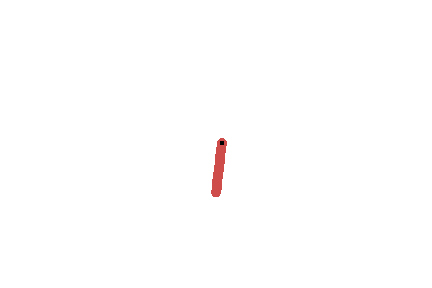
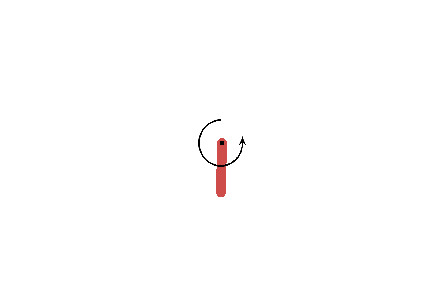
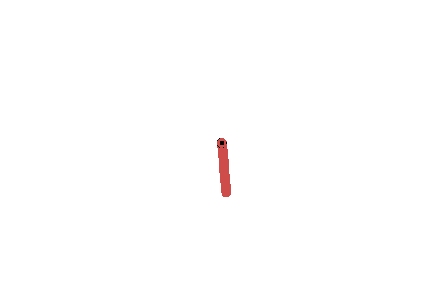
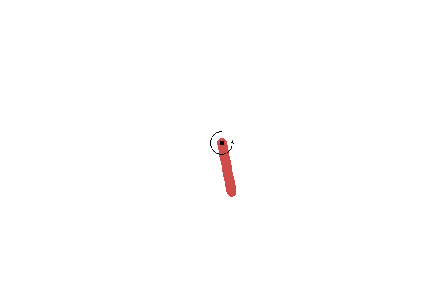
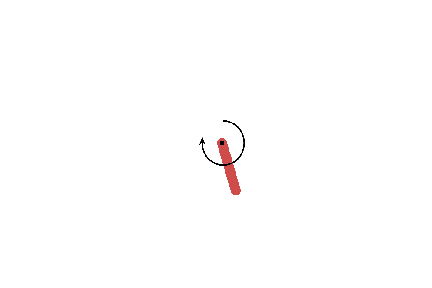
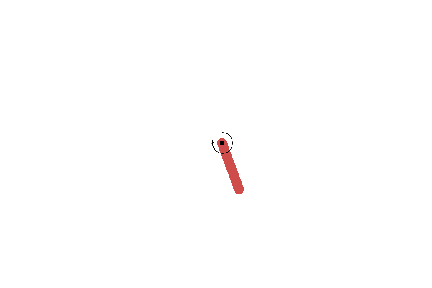
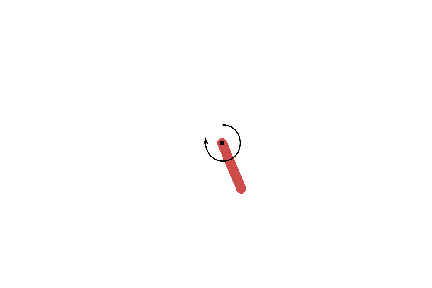
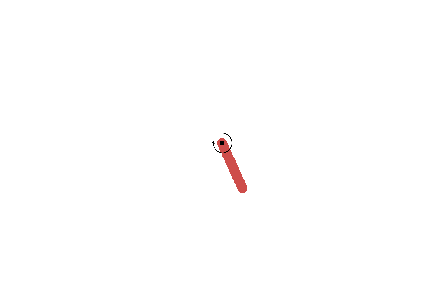
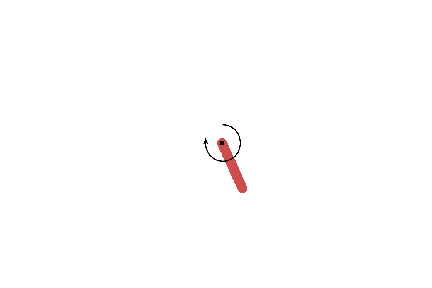
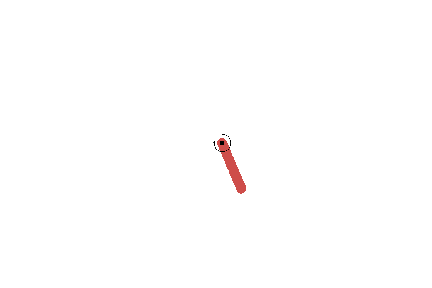
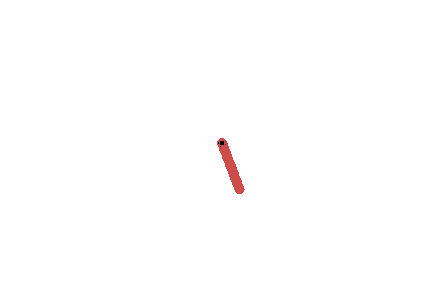
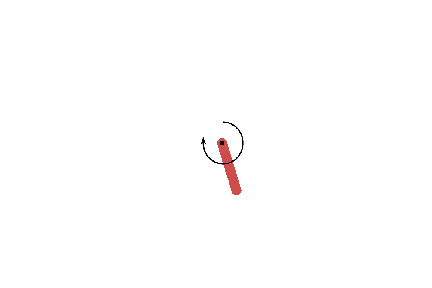
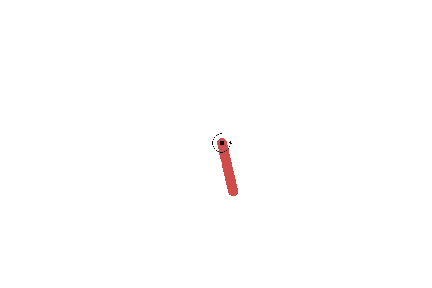
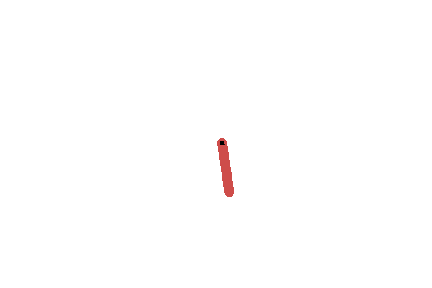
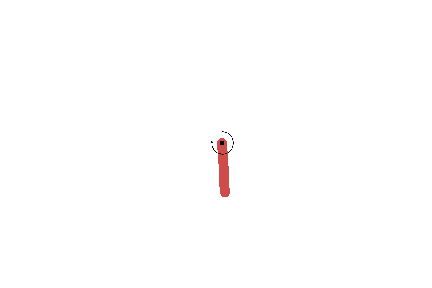
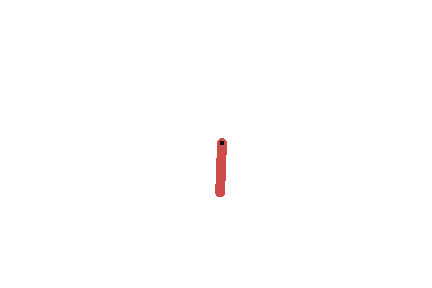
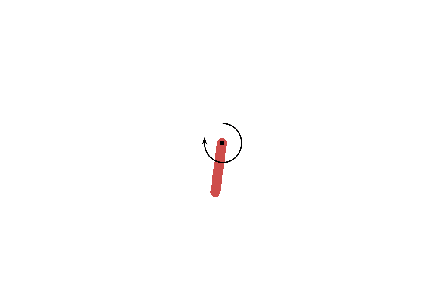
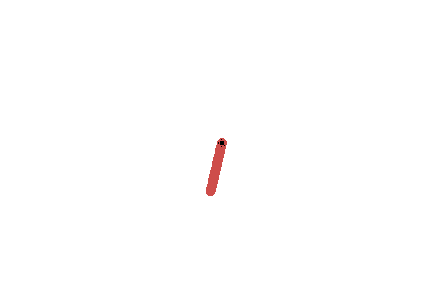
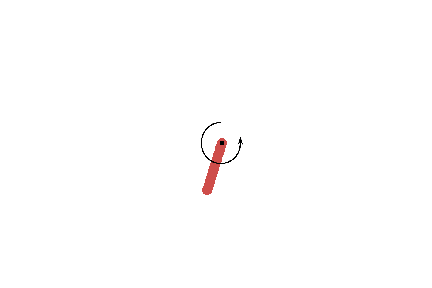
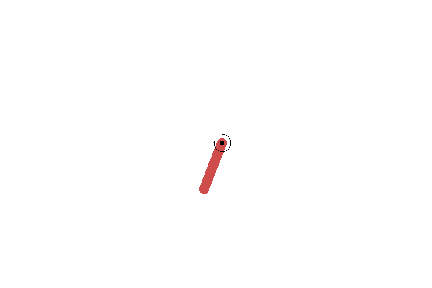
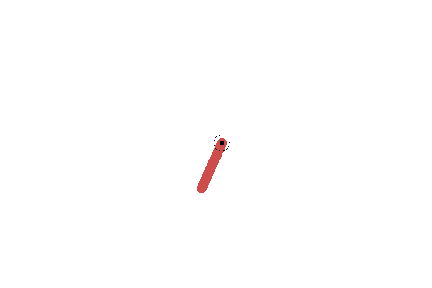
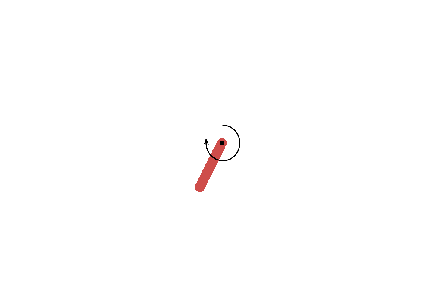
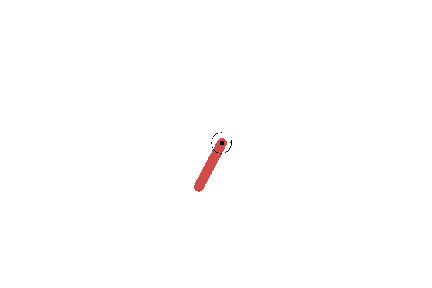
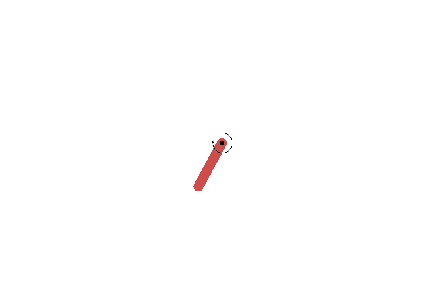
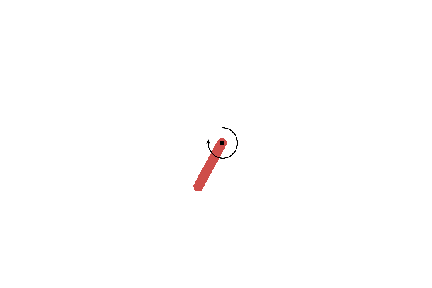
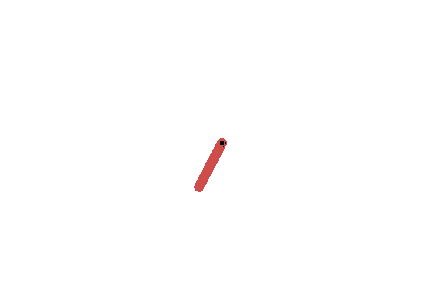
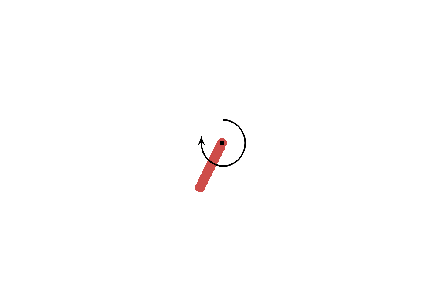
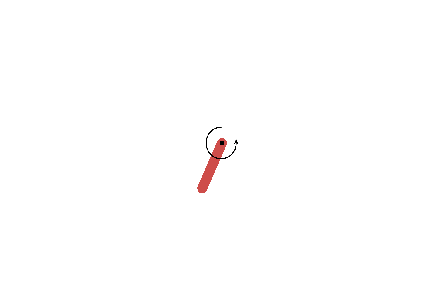
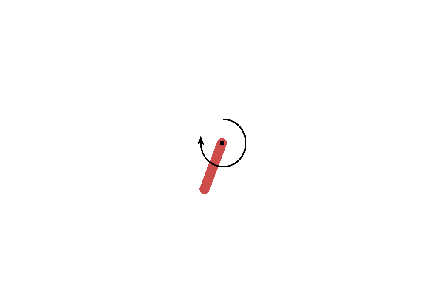
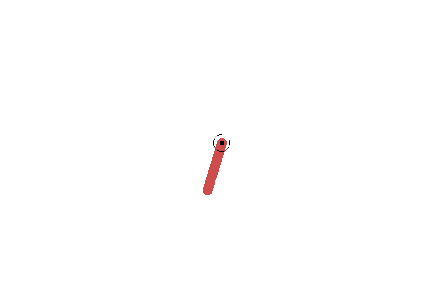
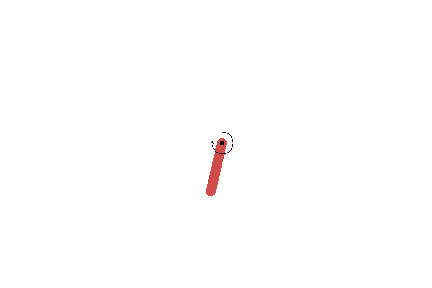
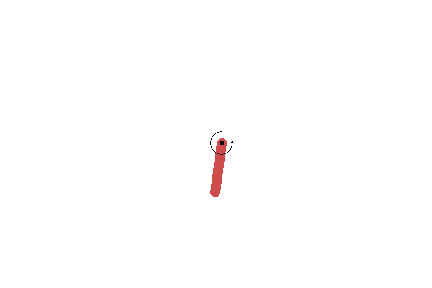
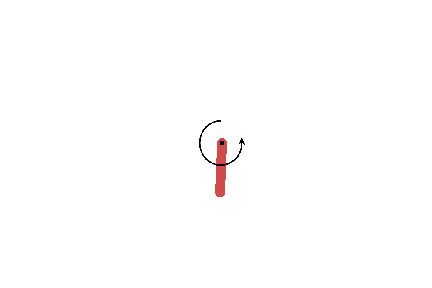
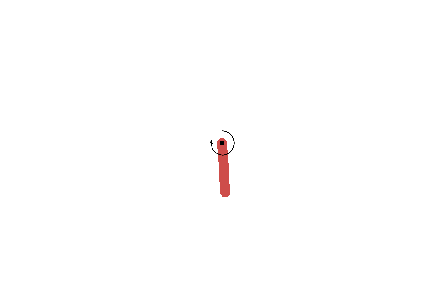
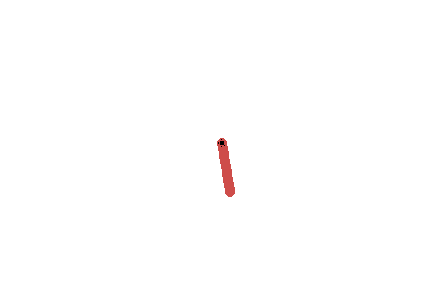
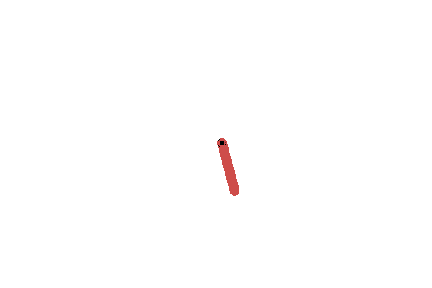
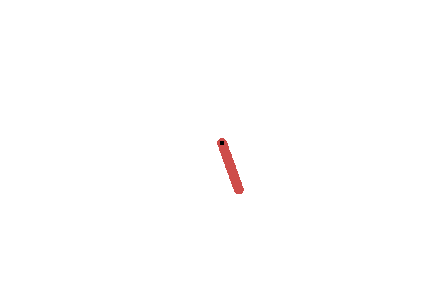
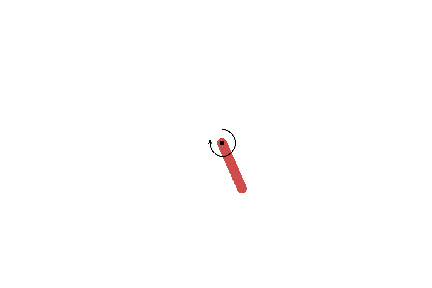
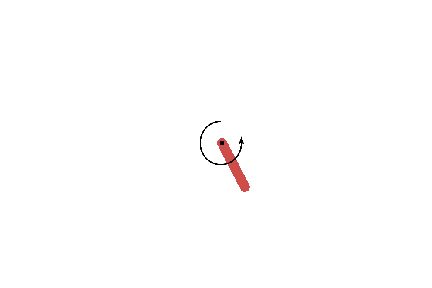
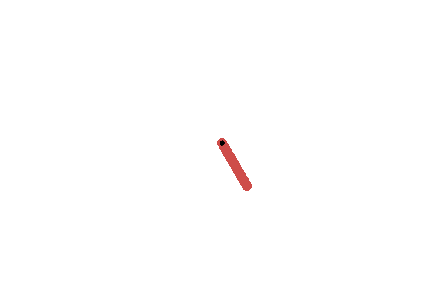
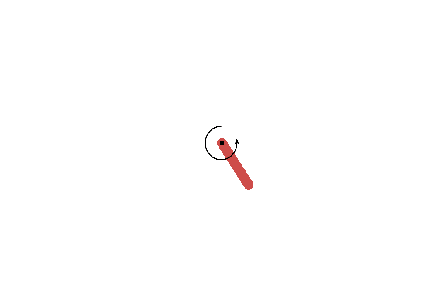
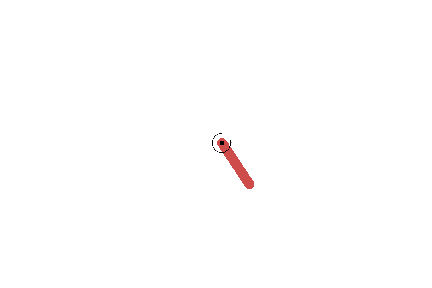
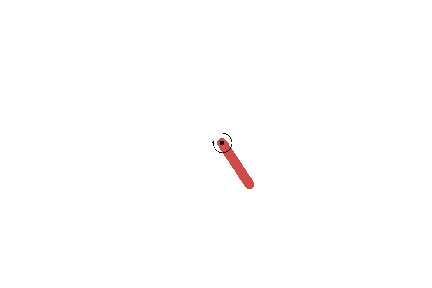
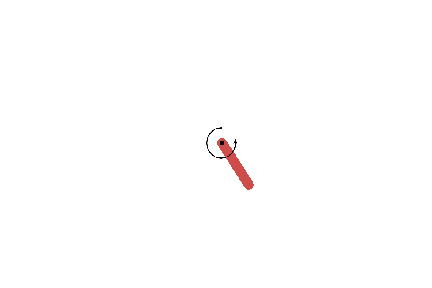
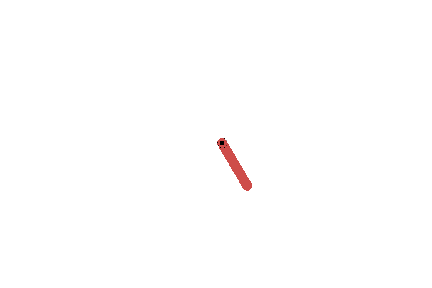
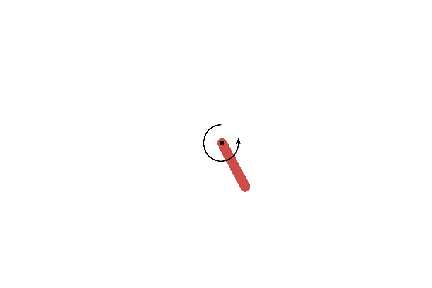
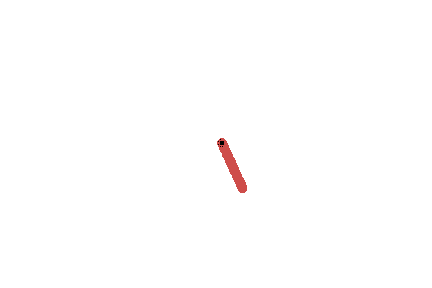
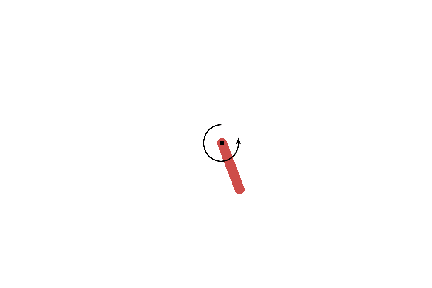
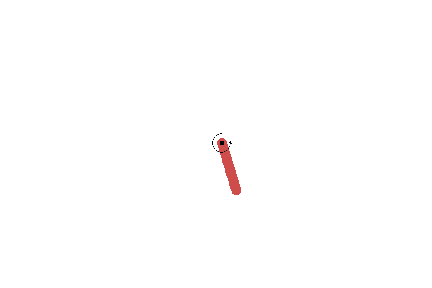
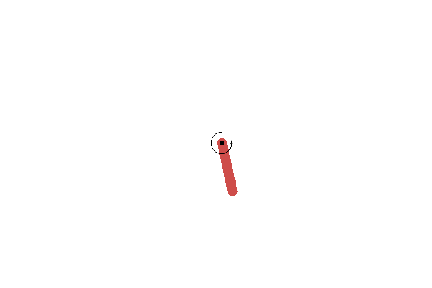
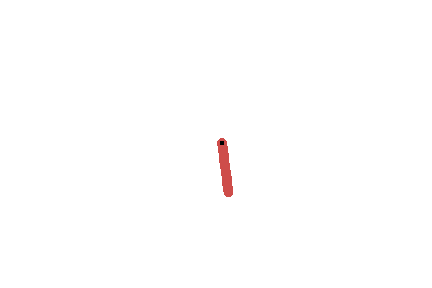
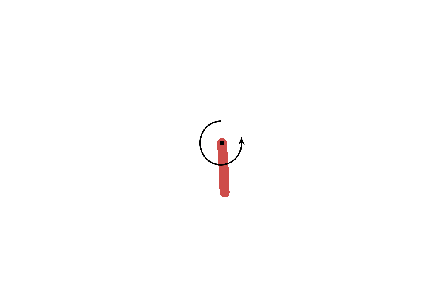
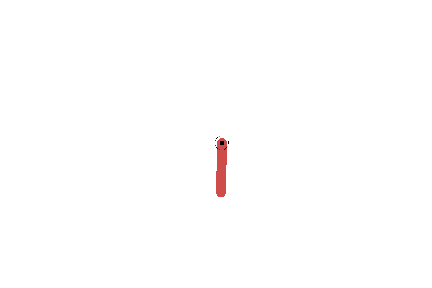
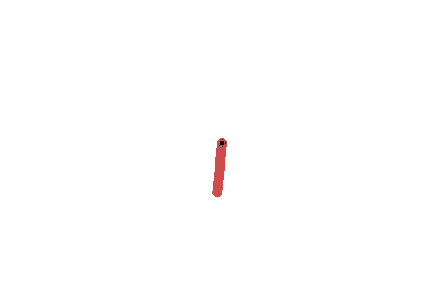
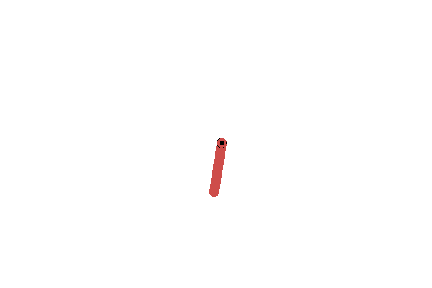
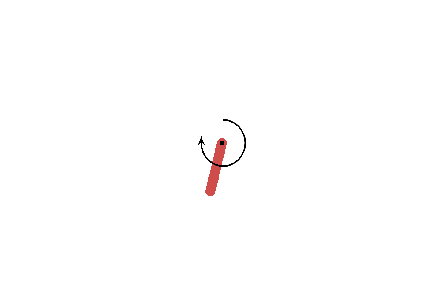
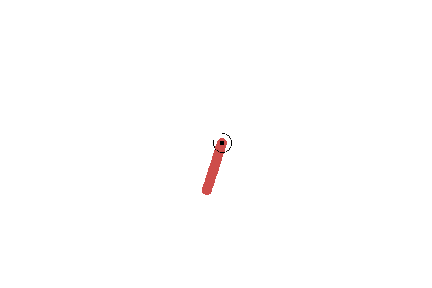
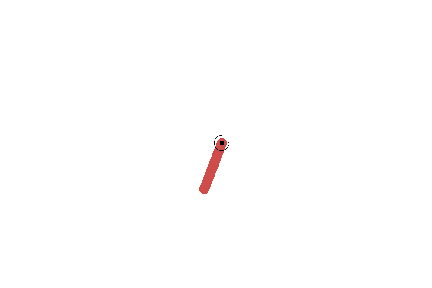
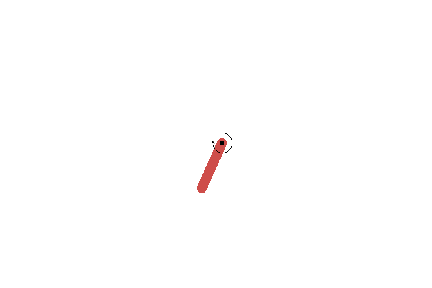
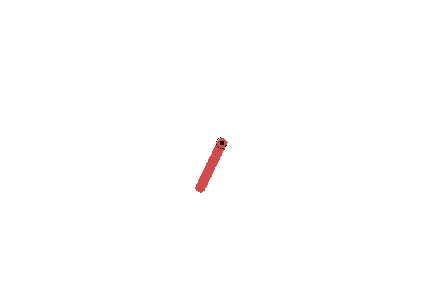
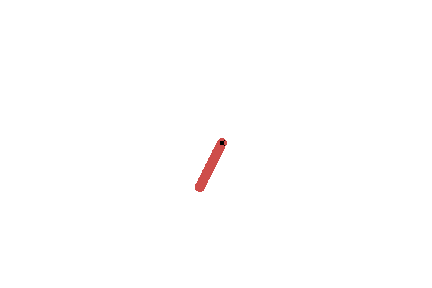
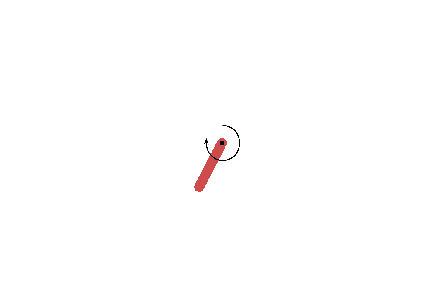
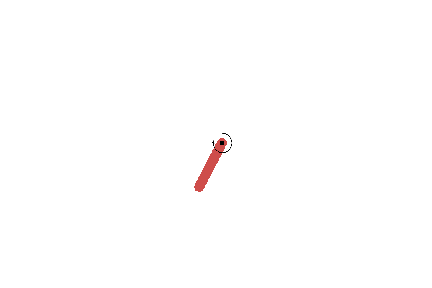
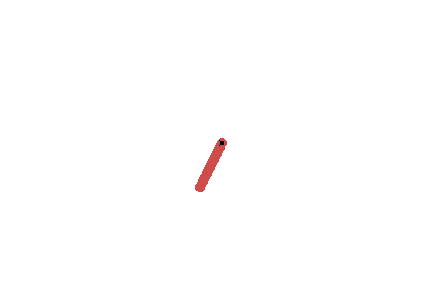
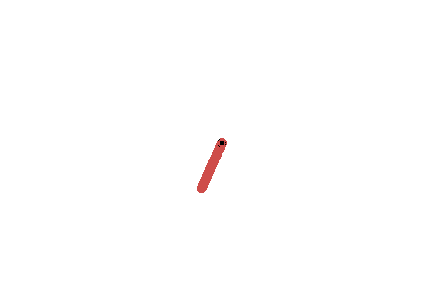
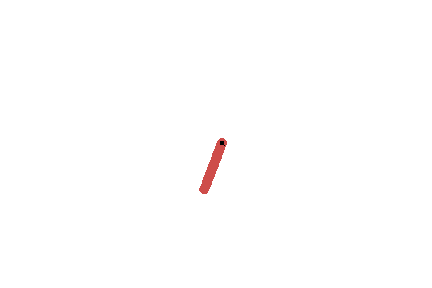
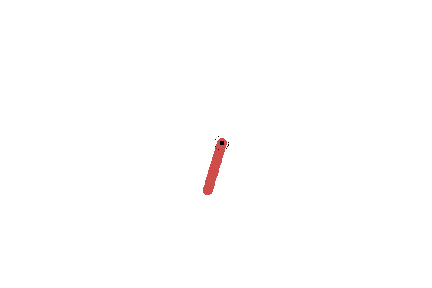
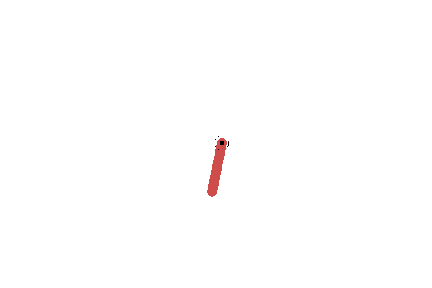
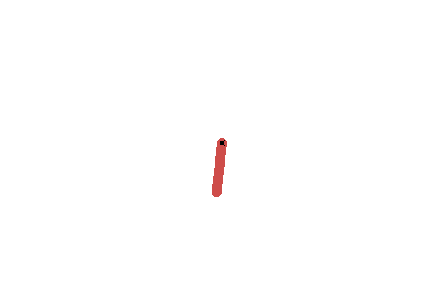
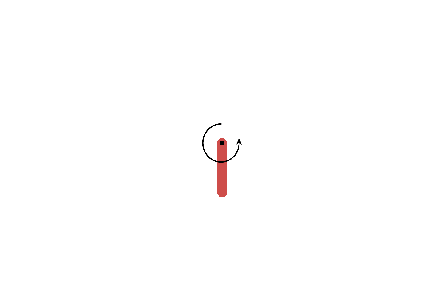
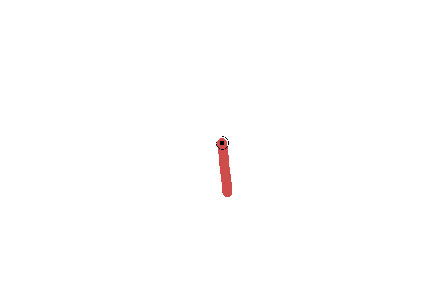
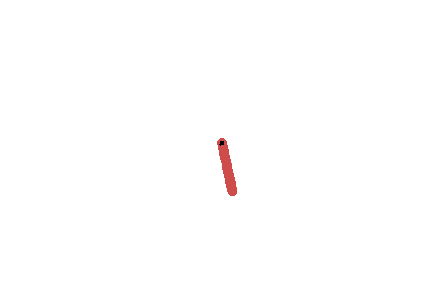
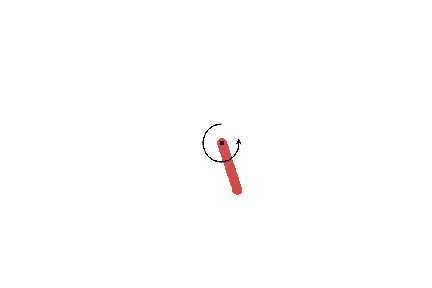
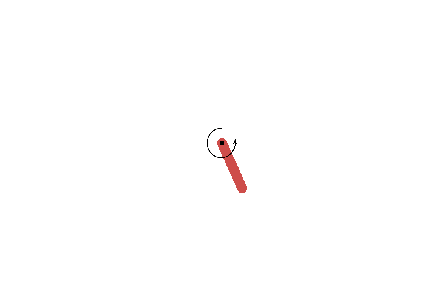
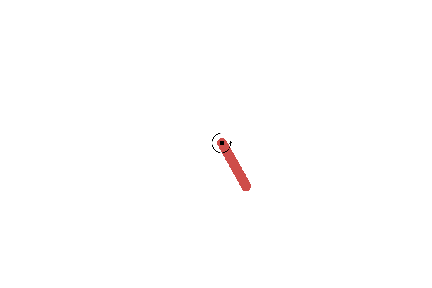
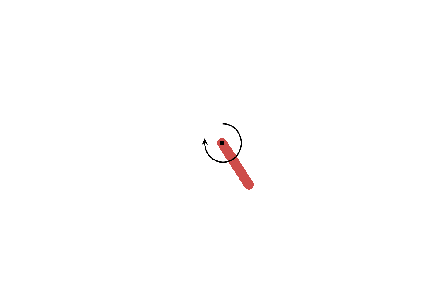
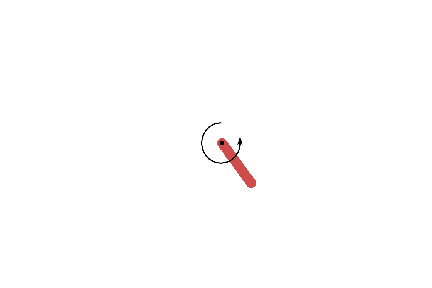
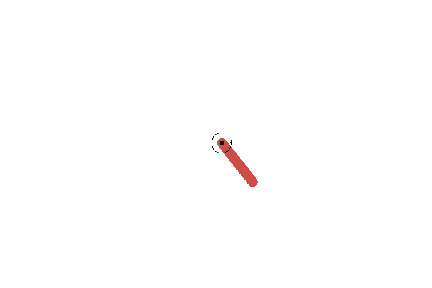
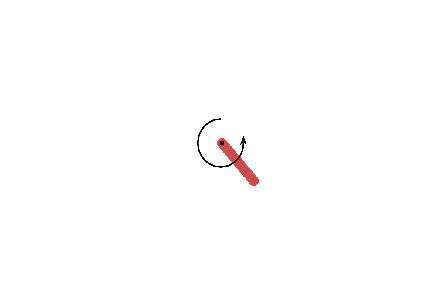
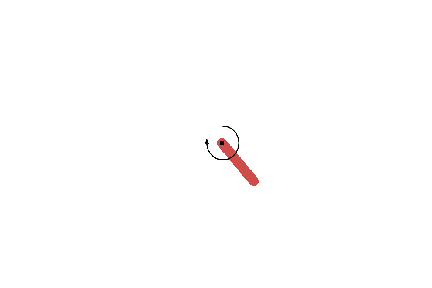
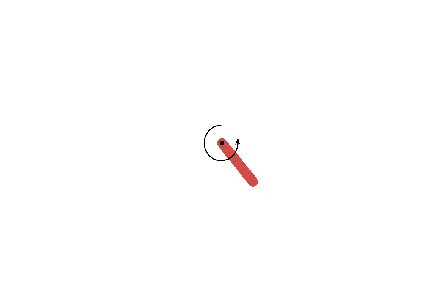
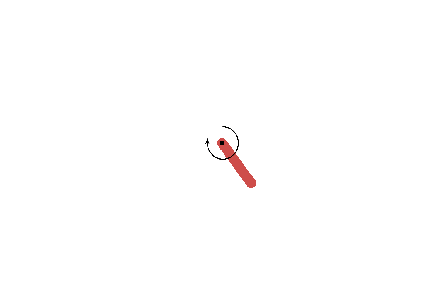
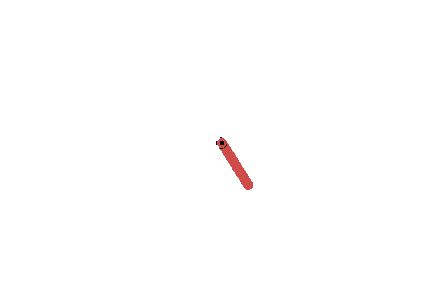
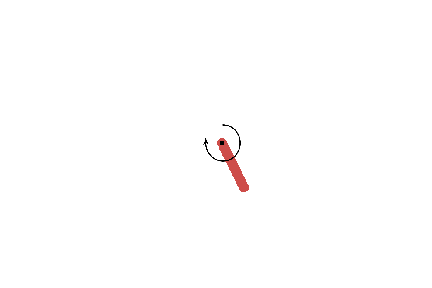
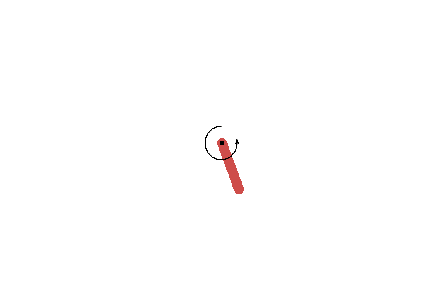
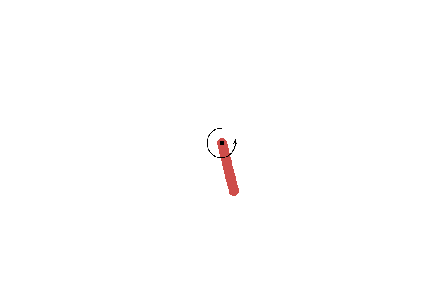
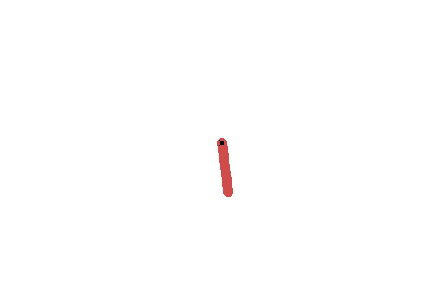
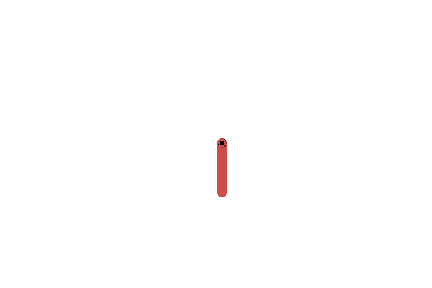
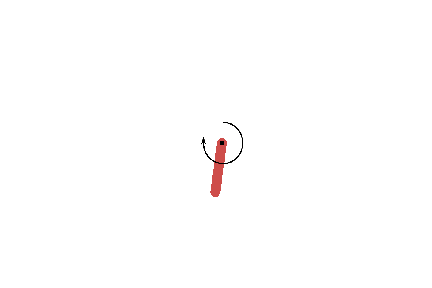
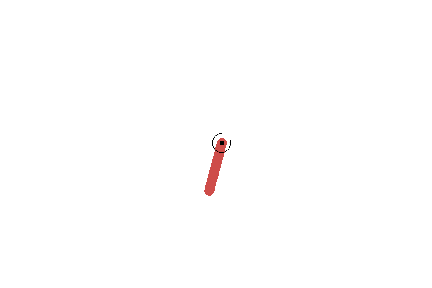
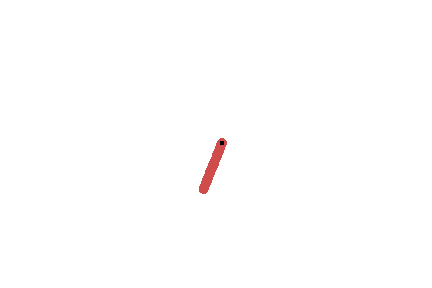
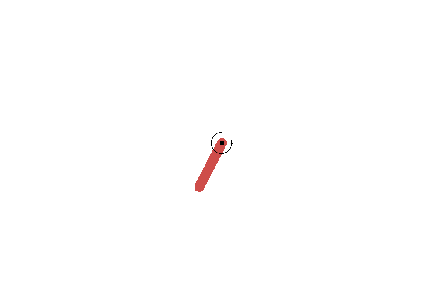
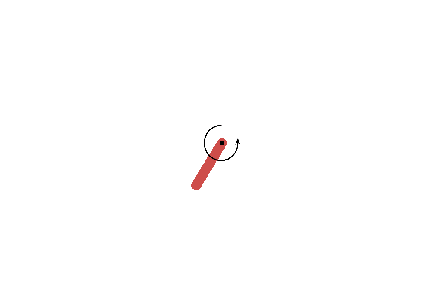
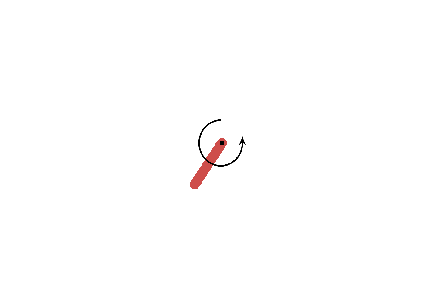
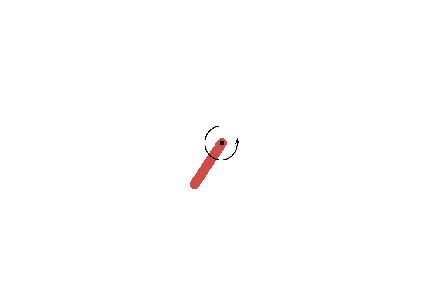
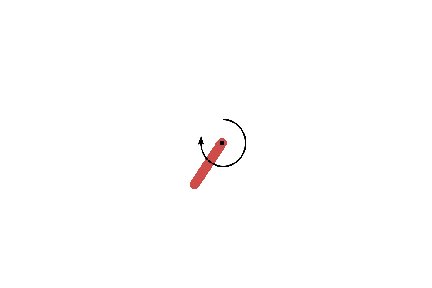
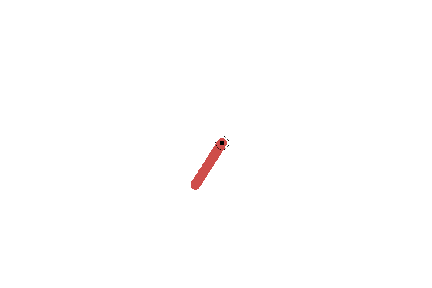
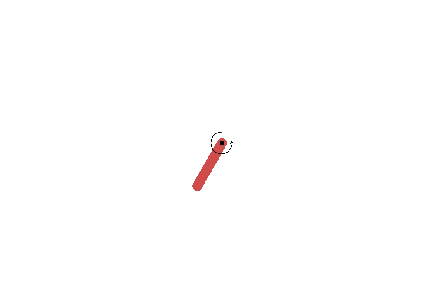
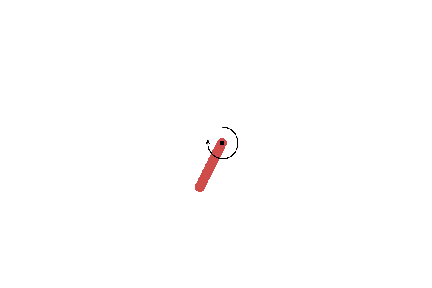
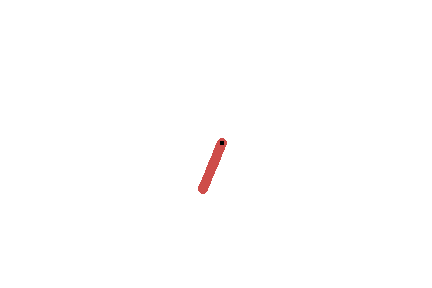
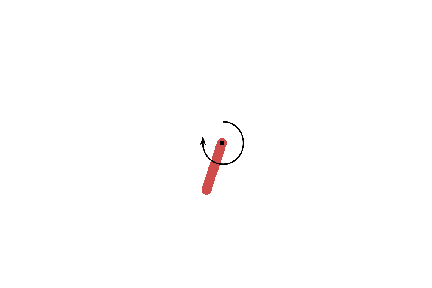
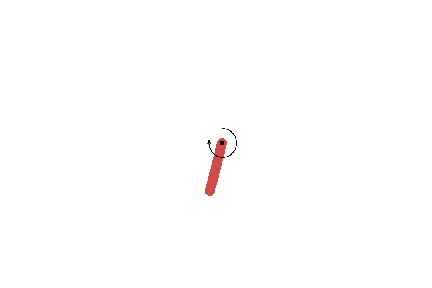
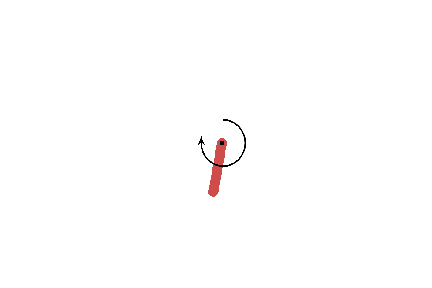
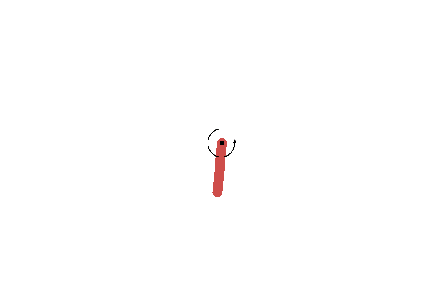
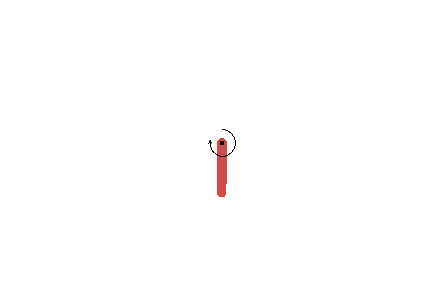
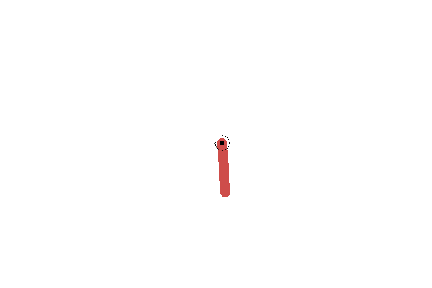
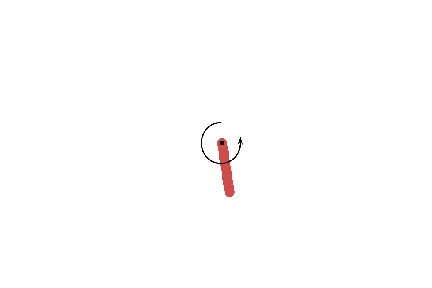
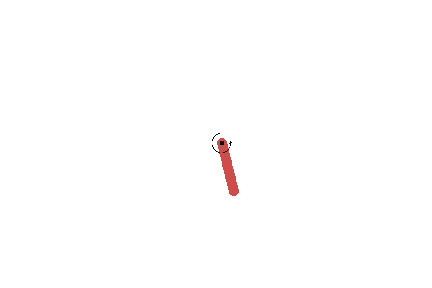
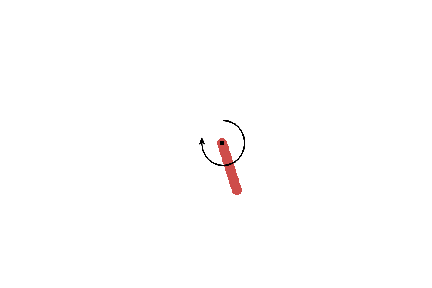
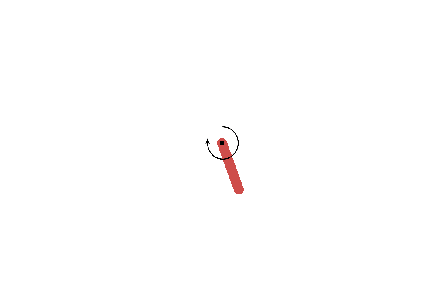
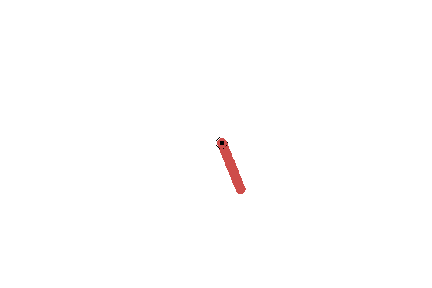
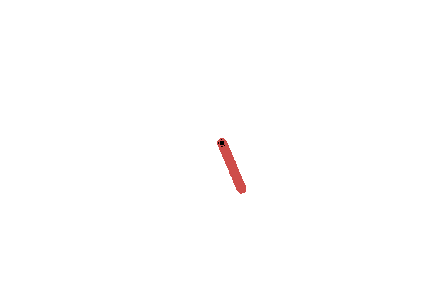
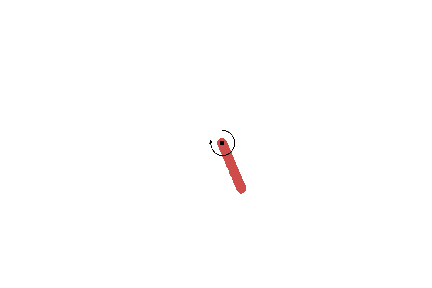
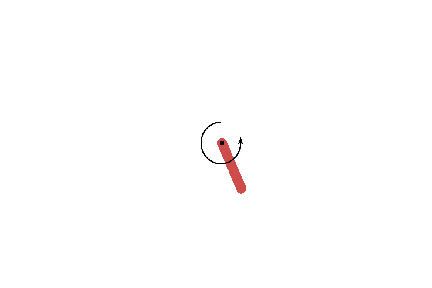
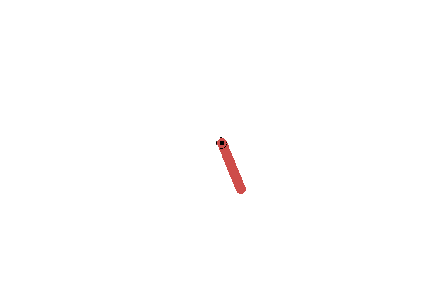
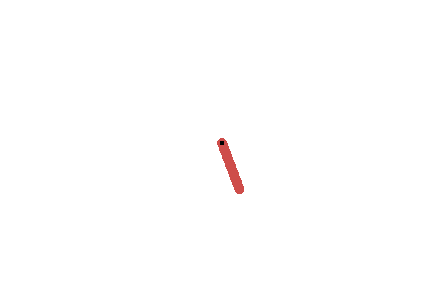
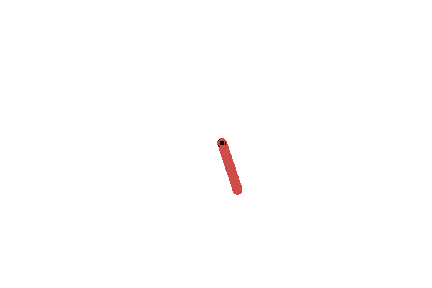
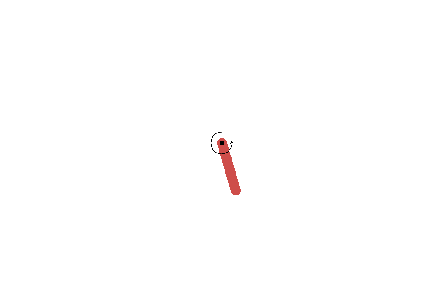
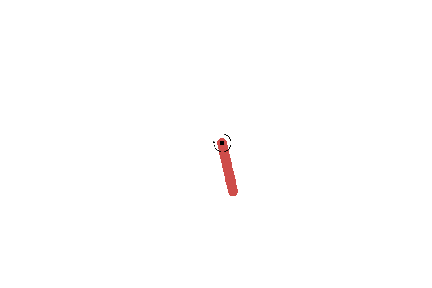
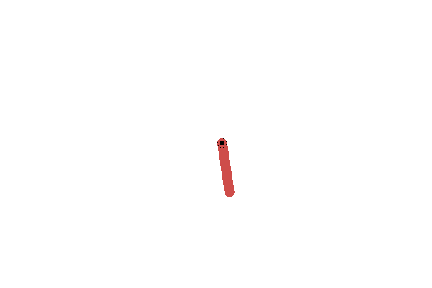
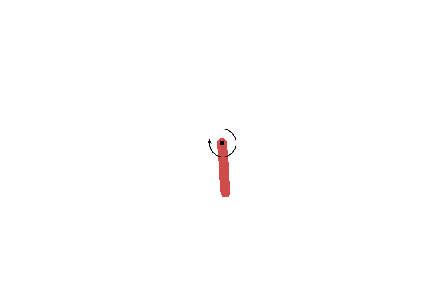
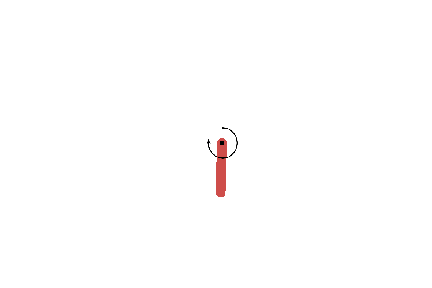
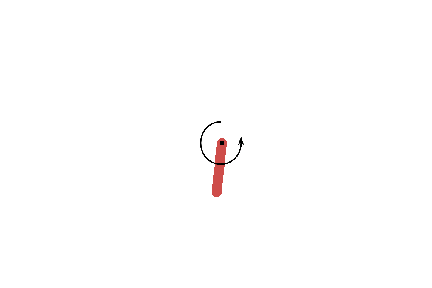
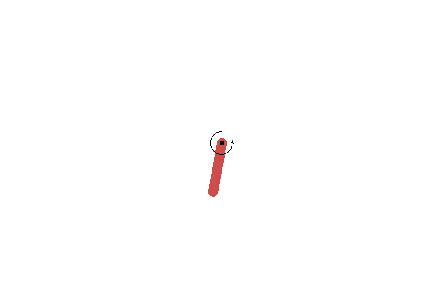
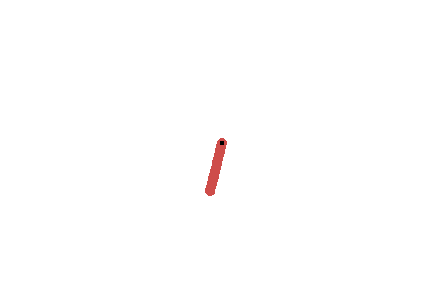
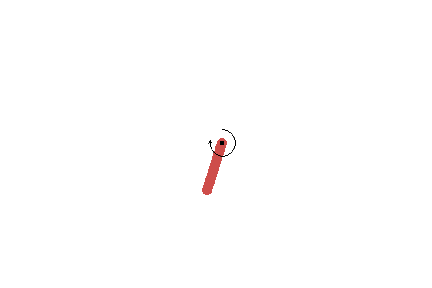
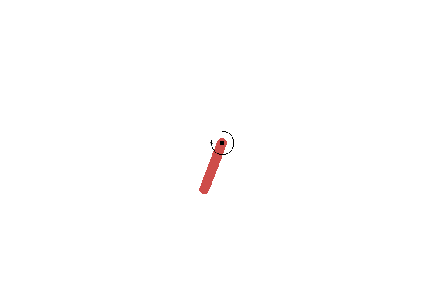
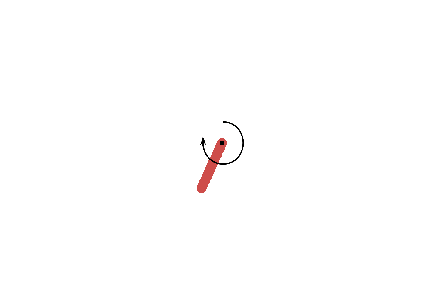
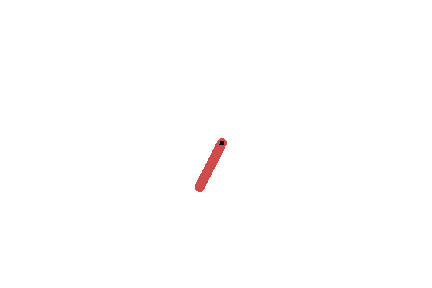

In [7]:
observation = env.reset()  # 環境はリセットする
frames = []  # 環境情報
while True:
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()
display_frames_as_gif(frames)

ランダム行動で1エピソード動かして、報酬の最大、最小、平均を計算する  
重くなるので画面表示は行わない

In [8]:
observation = env.reset()  # 環境はリセットする
rewards = []
while True:
    action = env.action_space.sample()
    obs, r, done, _ = env.step(action)  # 変数名は省略する
    rewards.append(r)
    if done:
        break
env.close()
print('MAX', max(rewards))
print('MIN', min(rewards))
print('AVG', sum(rewards)/len(rewards))

MAX -3.455422762298207
MIN -12.035825896272174
AVG -6.642656939312587


## 強化学習モデルの作成

`Pendulum-v0`の環境と、学習アルゴリズムを仲介するクラスを作成

In [9]:
class PendulumProcessor(Processor):

    def __init__(self):
        self.act2val = {0: [-1], 1: [+1]} # 行動を右に回す, 左に回すの2択にする
    
    def process_action(self, action):
        return self.act2val[action]
    
    def process_reward(self, reward):
        return (8 + reward) / 16

仲介クラスを定義

In [10]:
processor = PendulumProcessor()

入力の次元数を定義

In [11]:
input_shape = (1,) + env.observation_space.shape
input_shape

(1, 3)

とれる行動数を指定

In [12]:
n_act = 2

##### ニューラルネットワークを定義
全結合2層、ユニット数16

In [13]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(n_act))
model.add(Activation('linear'))

##### メモリーを定義  
1エピソードずつ、50000エピソード経験を保存しておく

In [14]:
memory = SequentialMemory(limit=50000, window_length=1)

##### 探索方針の設定
ε-greedyを使う

In [15]:
policy = EpsGreedyQPolicy(eps=0.01)

##### エージェントの設定

In [16]:
dqn = DQNAgent(model=model,
               nb_actions=n_act,
               memory=memory,
               policy=policy,
               processor=processor,
               nb_steps_warmup=10,  # パラメータ更新を行う間隔
               target_model_update=1e-2,  # 1割ずつモデルの更新を行う
               gamma=0.99,  # 割引率
)

エージェントを定義

In [17]:
dqn.compile(Adam(lr=1e-3), metrics=["mae"])
print(dqn.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total para

##### エージェントを環境で学習させる
50000ステップ学習させる

In [18]:
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 24:01 - reward: 0.4979

/home/takamichi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 71s 7ms/step - reward: 0.1879
50 episodes - episode_reward: 37.573 [-4.744, 53.477] - loss: 0.151 - mean_absolute_error: 3.305 - mean_q: 6.576

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 75s 7ms/step - reward: 0.2412
50 episodes - episode_reward: 48.241 [30.580, 62.027] - loss: 0.484 - mean_absolute_error: 6.832 - mean_q: 13.634

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 63s 6ms/step - reward: 0.2605
50 episodes - episode_reward: 52.106 [34.629, 61.424] - loss: 0.700 - mean_absolute_error: 8.220 - mean_q: 16.380

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 65s 7ms/step - reward: 0.2698
50 episodes - episode_reward: 53.965 [36.490, 68.557] - loss: 0.847 - mean_absolute_error: 9.073 - mean_q: 18.080

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 65s 6ms/step - reward: 0.3188
done, took 340.0

テストしてみる

In [19]:
dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 20.768, steps: 200
Episode 2: reward: 40.491, steps: 200
Episode 3: reward: 92.080, steps: 200
Episode 4: reward: 92.328, steps: 200
Episode 5: reward: 34.726, steps: 200


学習結果を使ってエージェントに制御させる


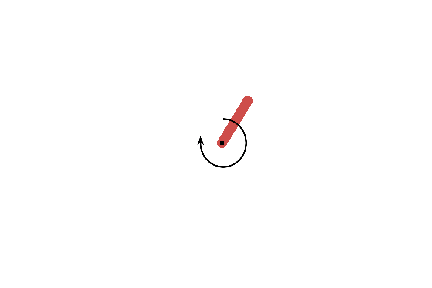
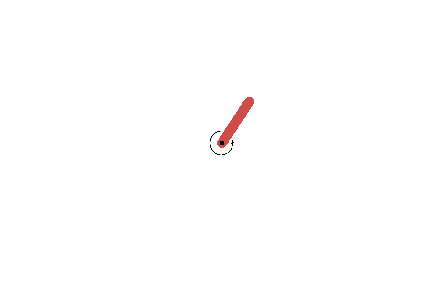
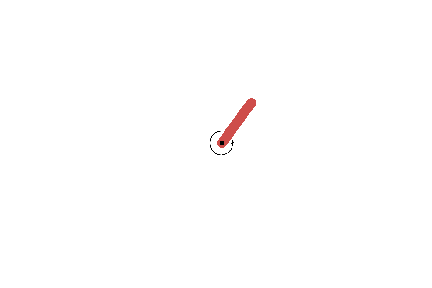
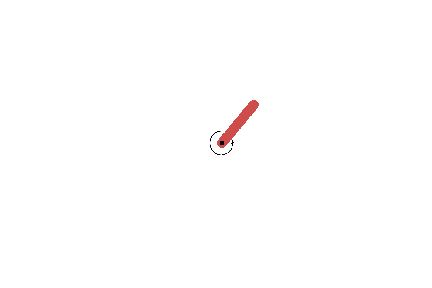
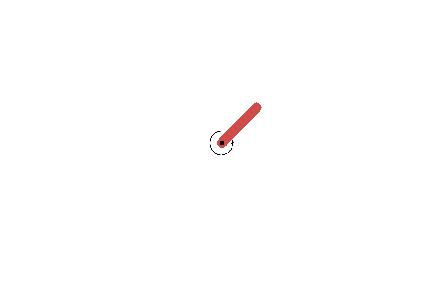
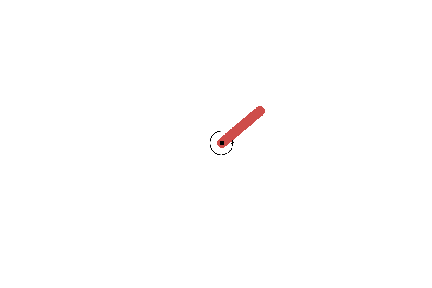
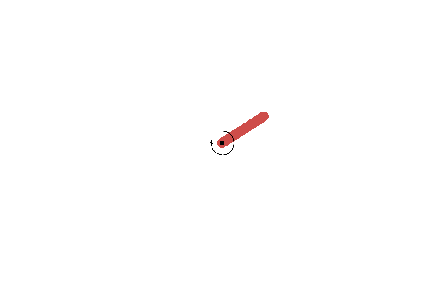
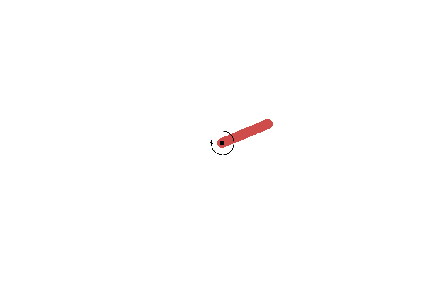
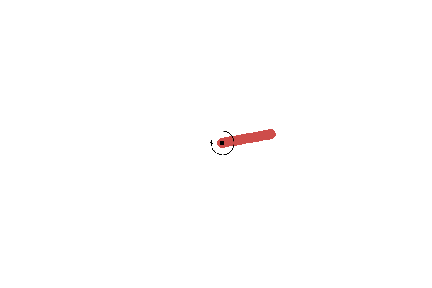
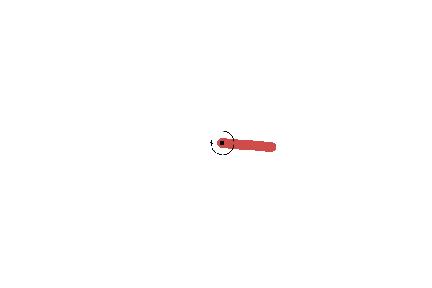
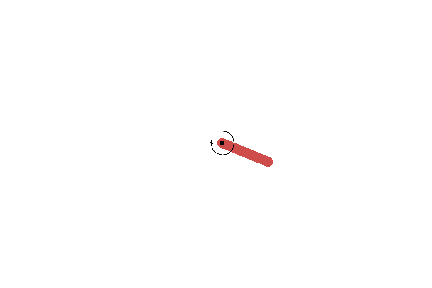
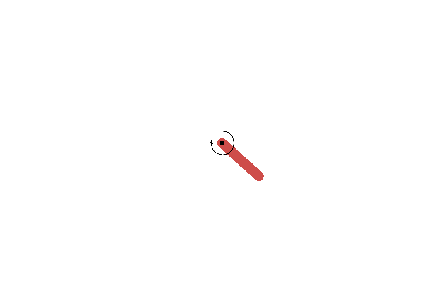
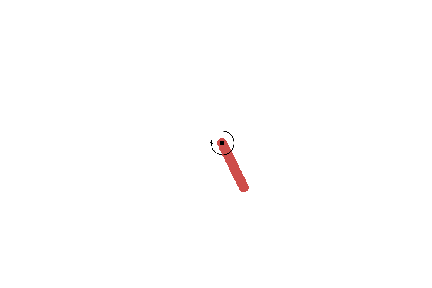
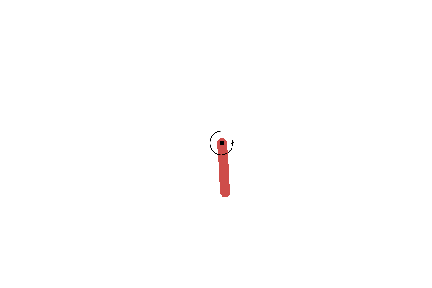
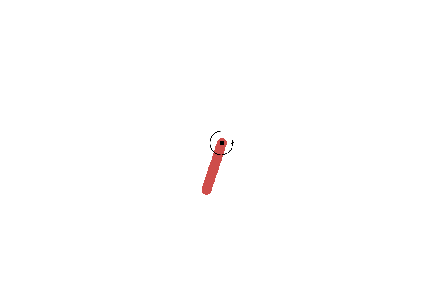
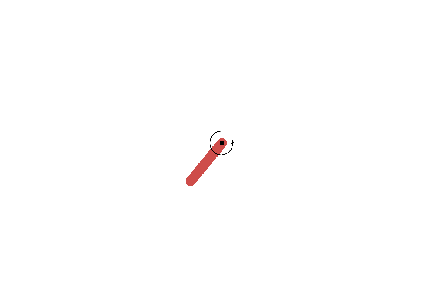
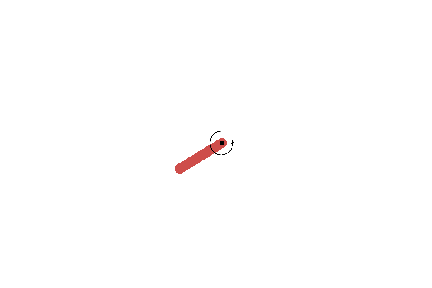
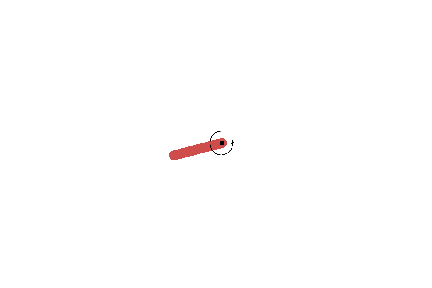
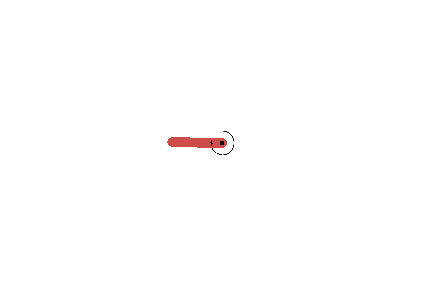
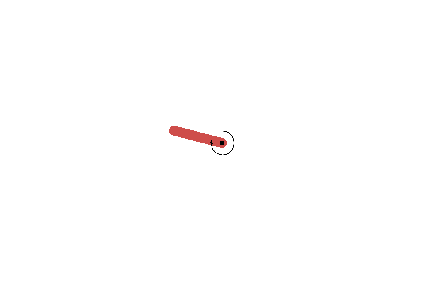
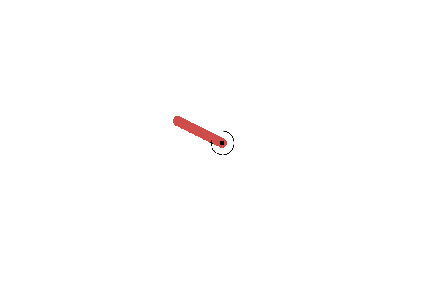
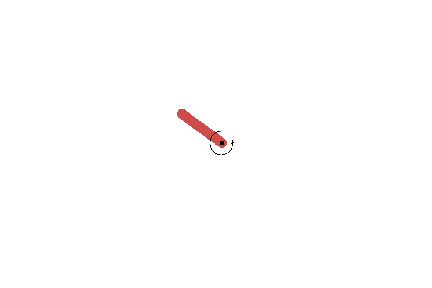
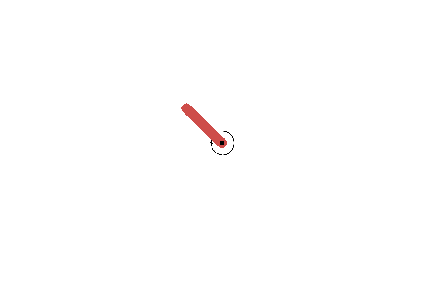
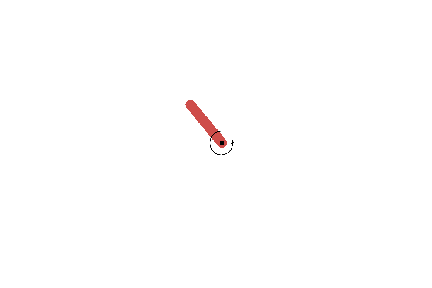
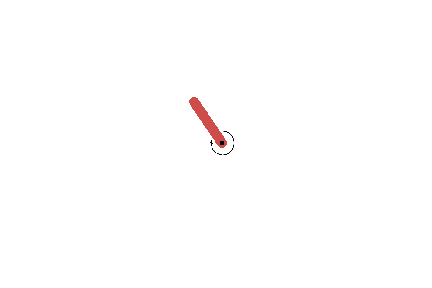
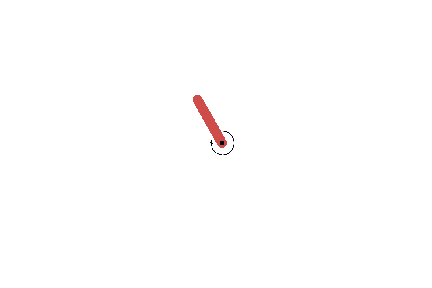
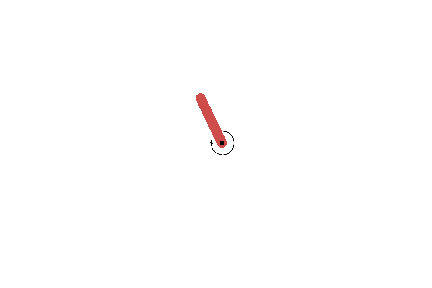
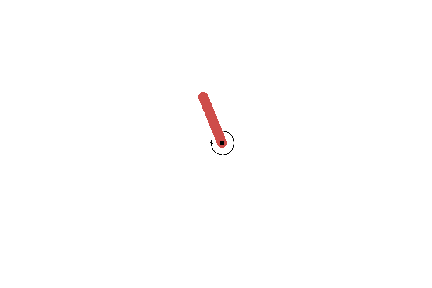
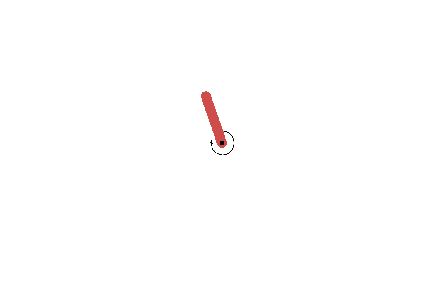
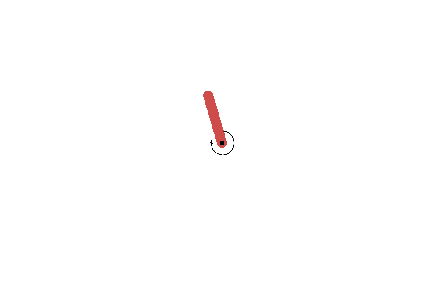
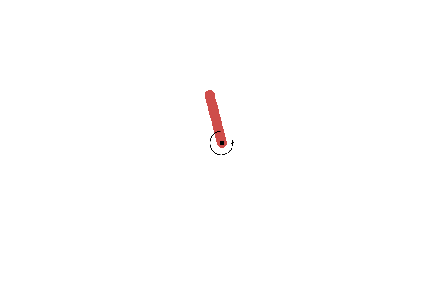
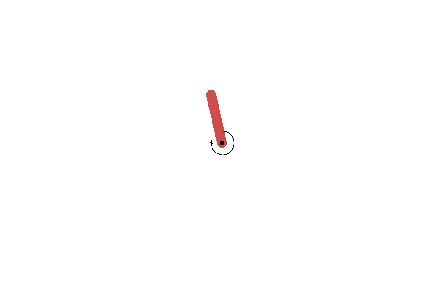
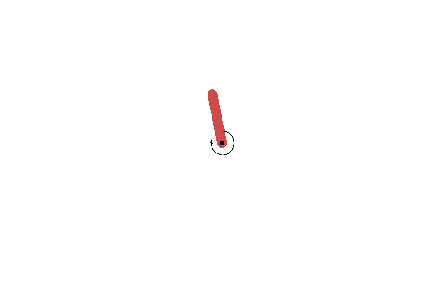
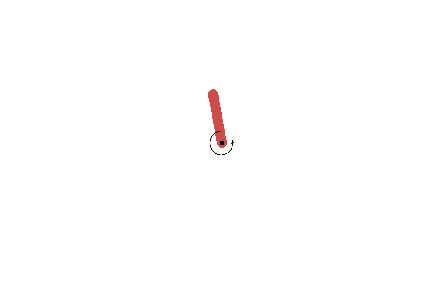
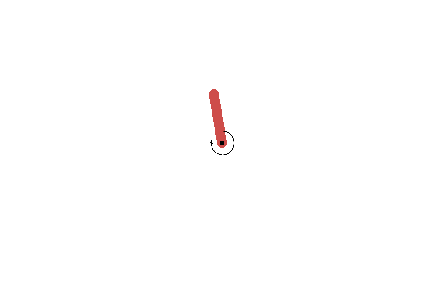
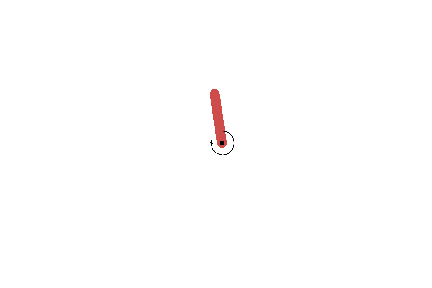
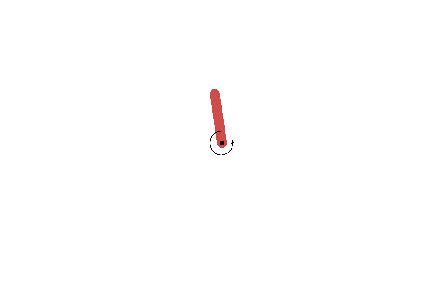
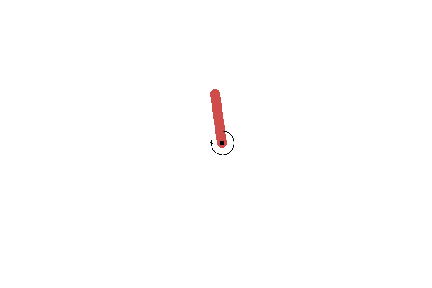
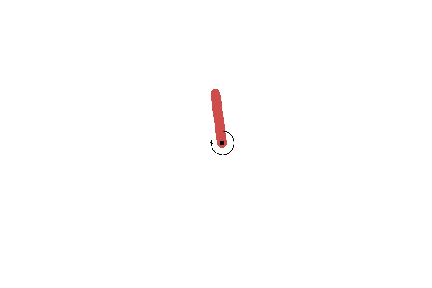
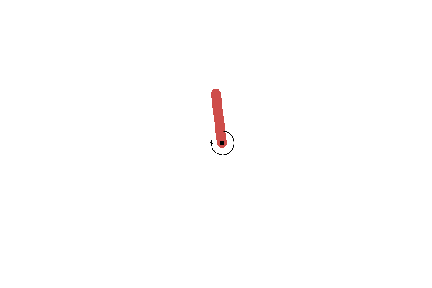
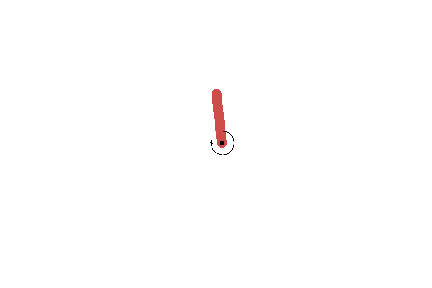
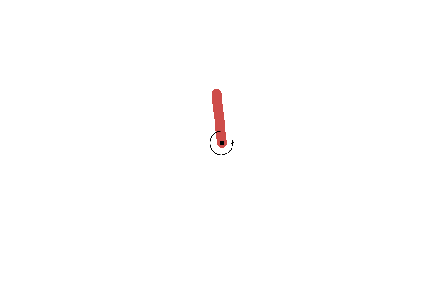
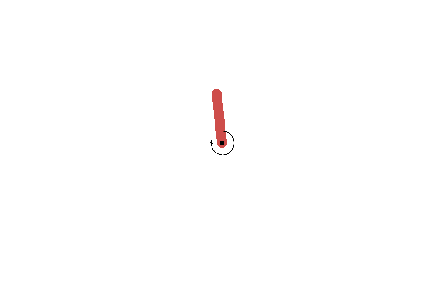
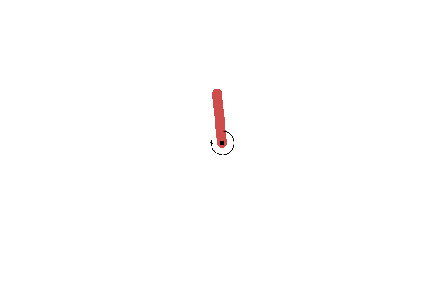
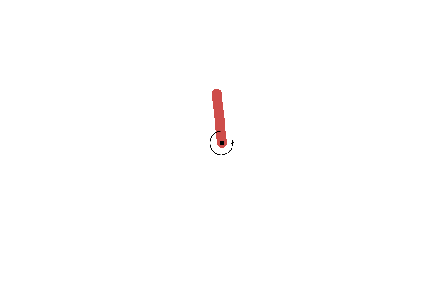
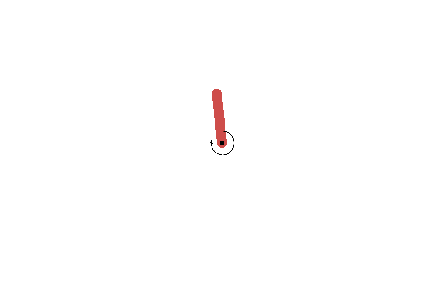
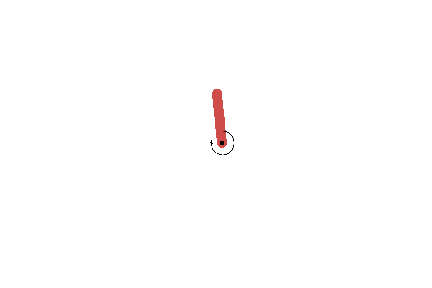
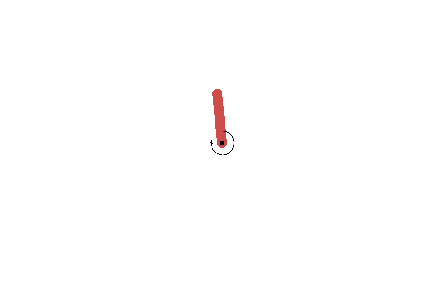
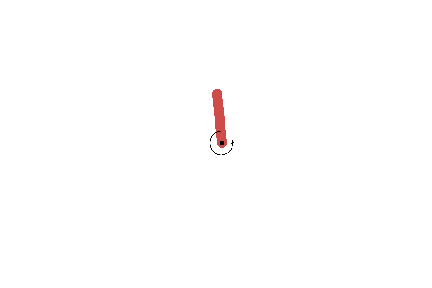
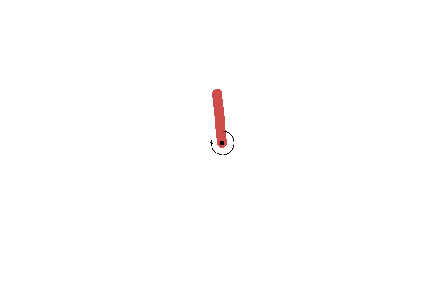
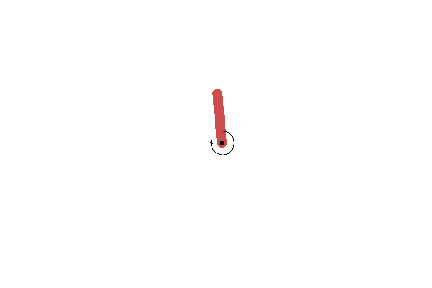
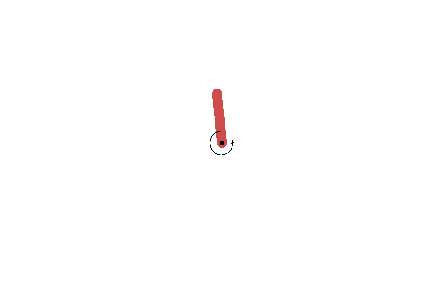
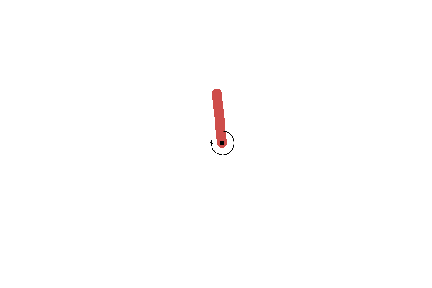
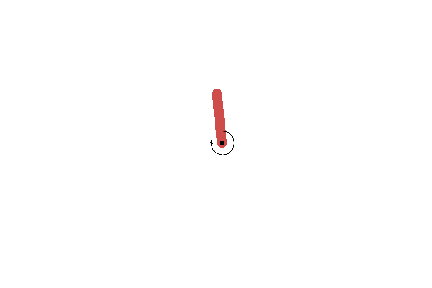
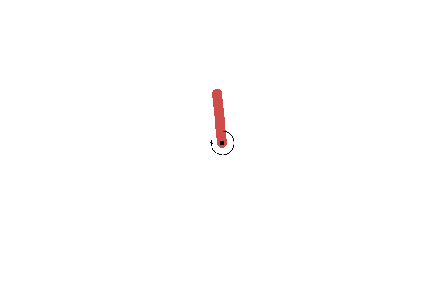
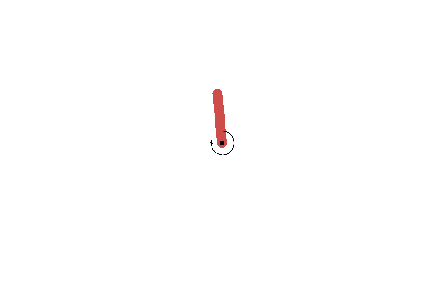
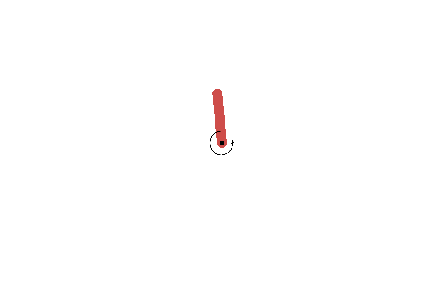
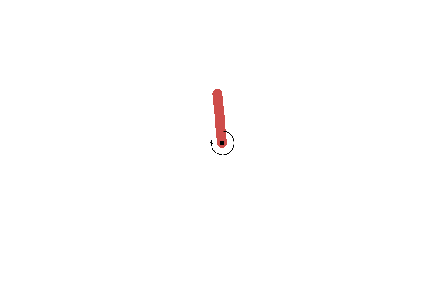
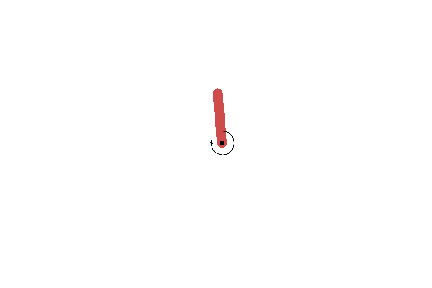
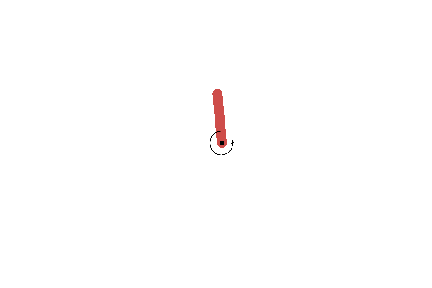
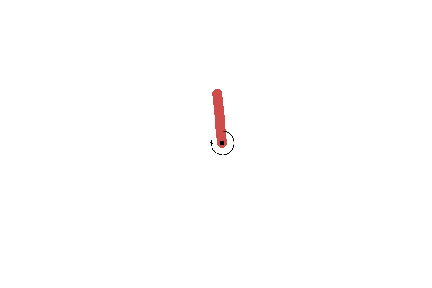
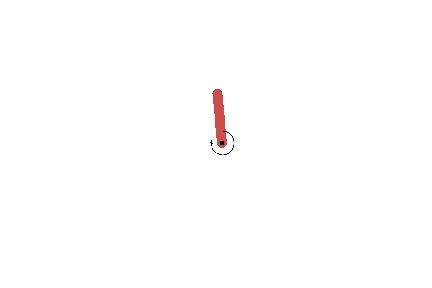
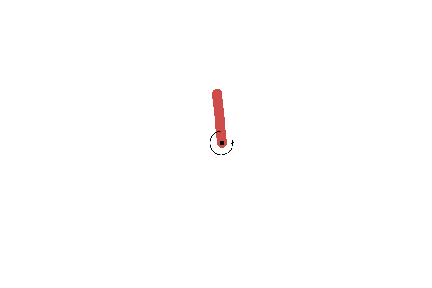
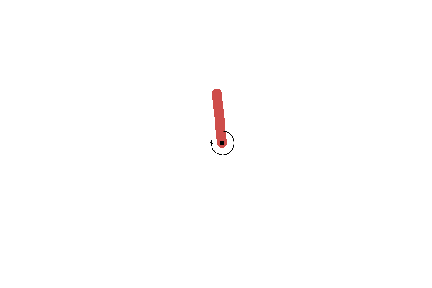
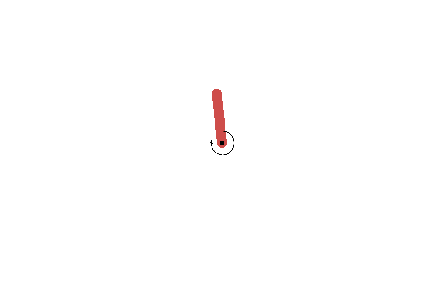
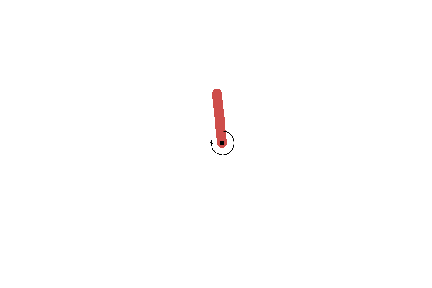
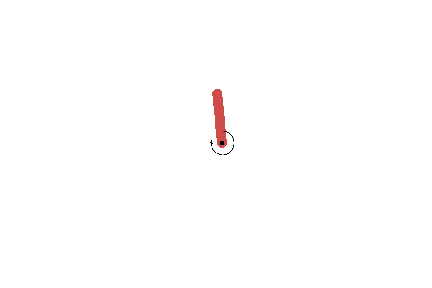
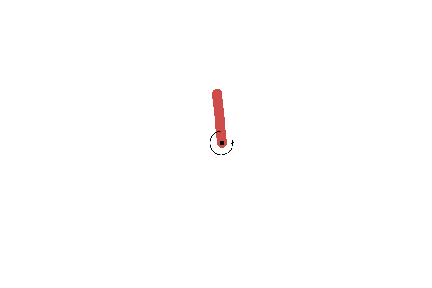
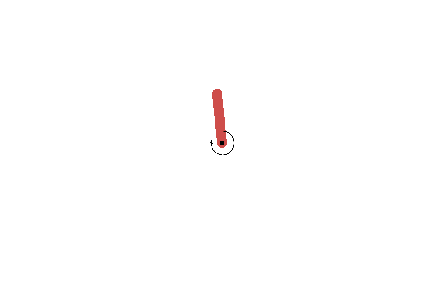
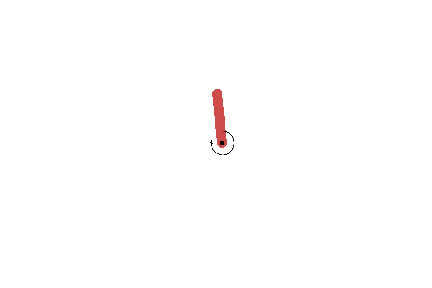
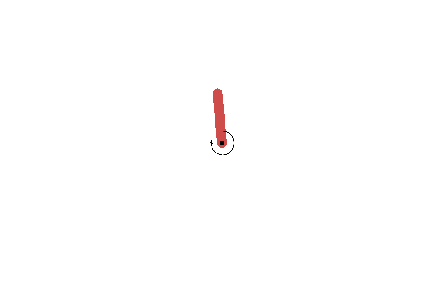
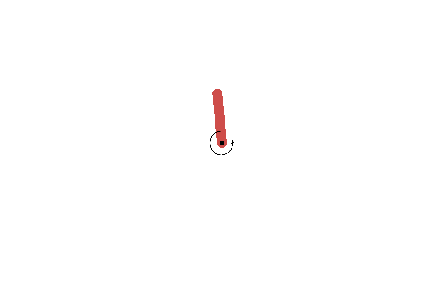
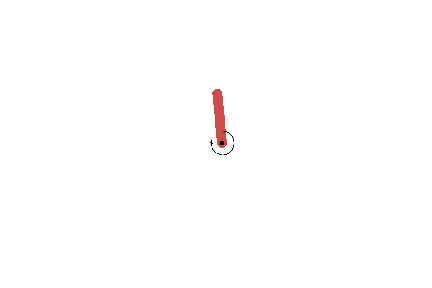
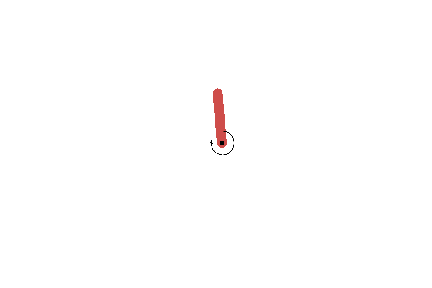
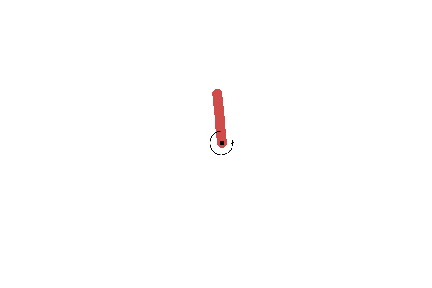
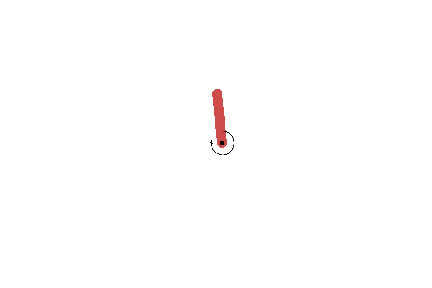
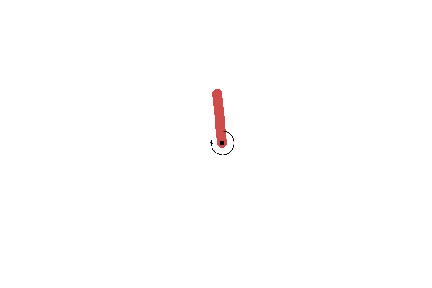
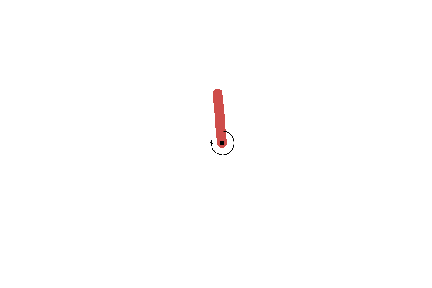
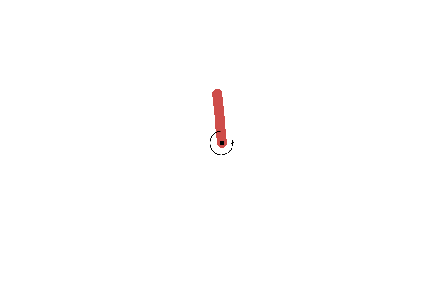
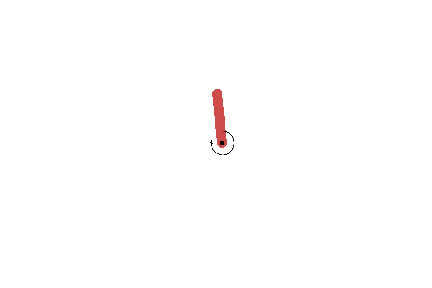
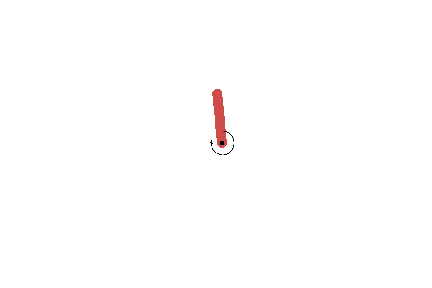
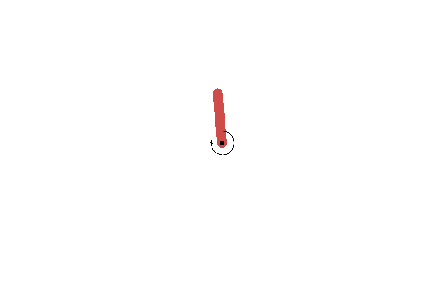
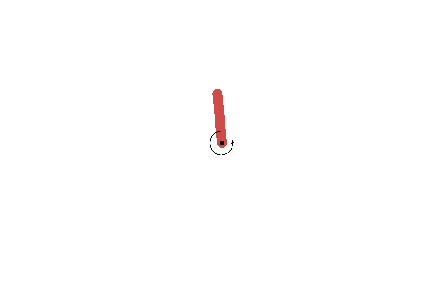
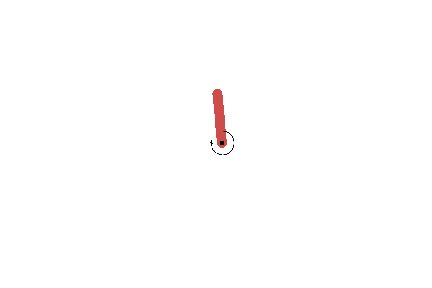
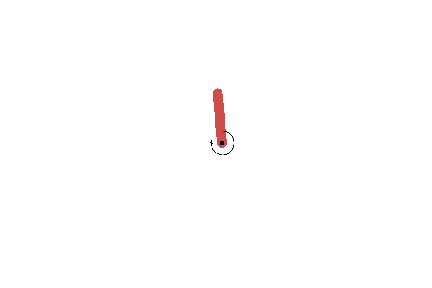
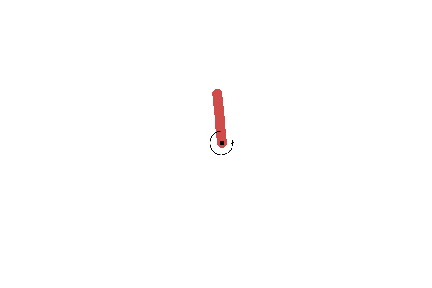
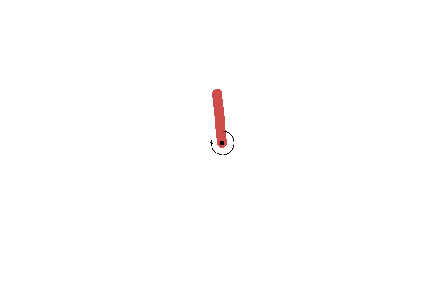
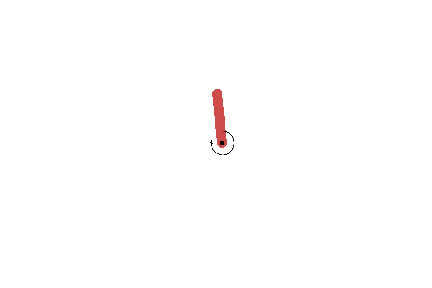
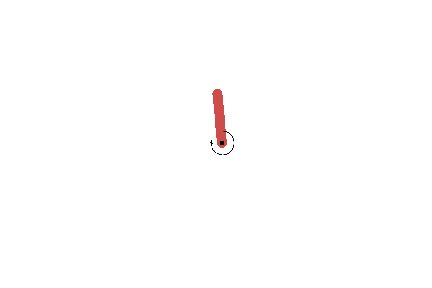
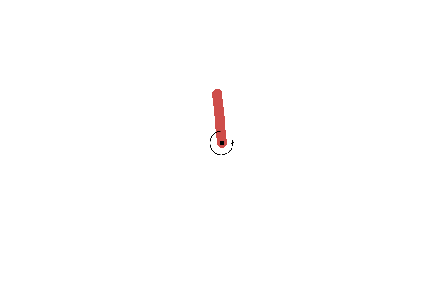
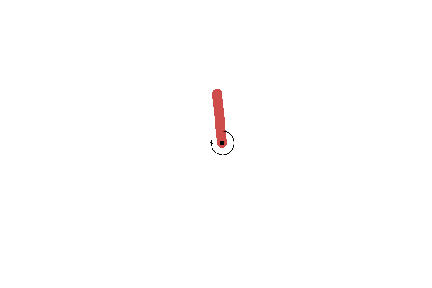
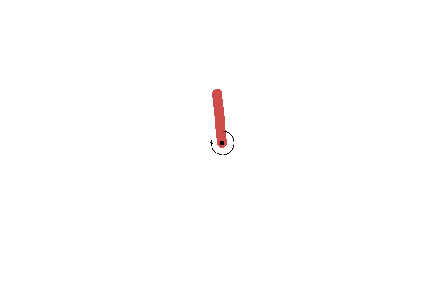
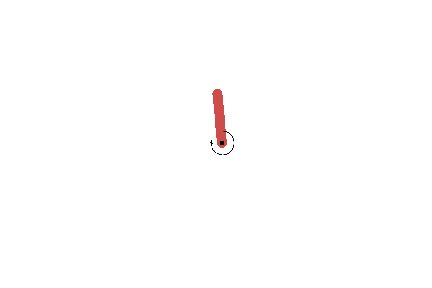
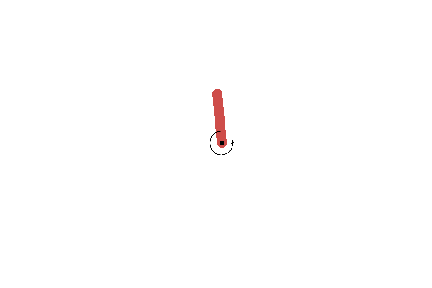
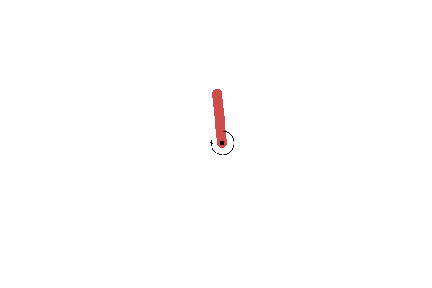
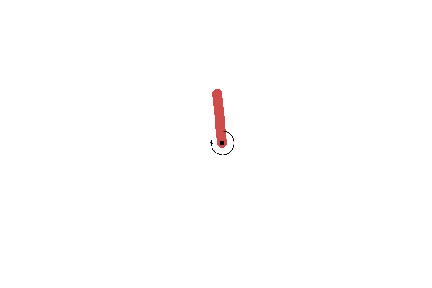
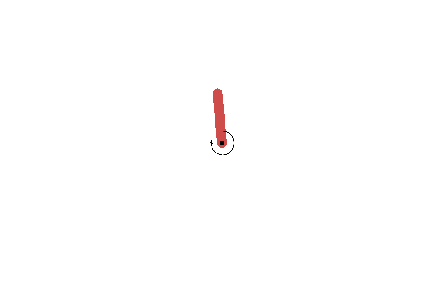
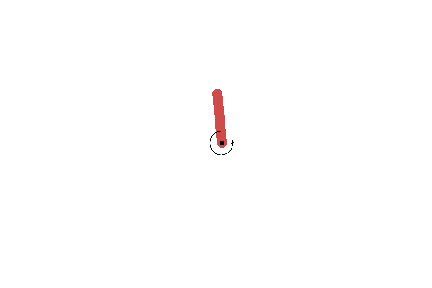
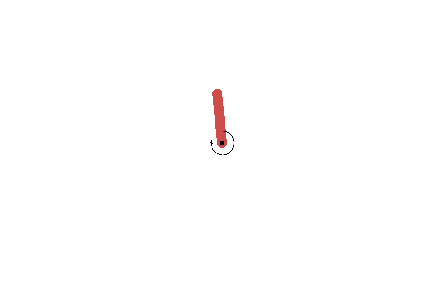
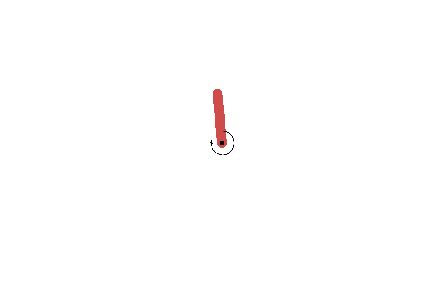
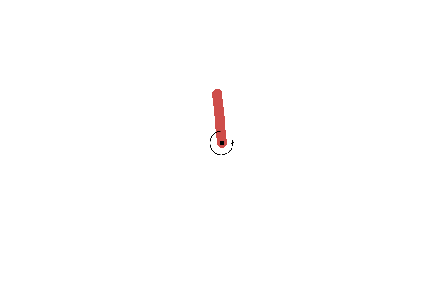
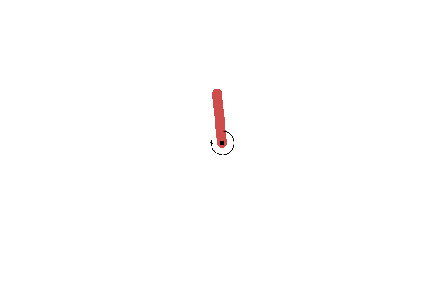
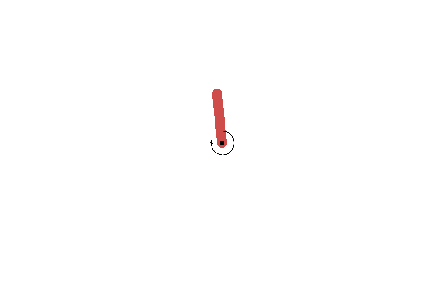
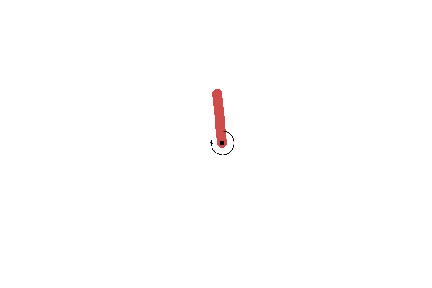
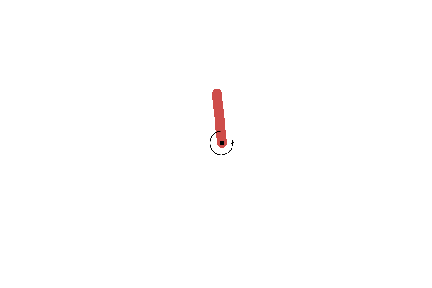
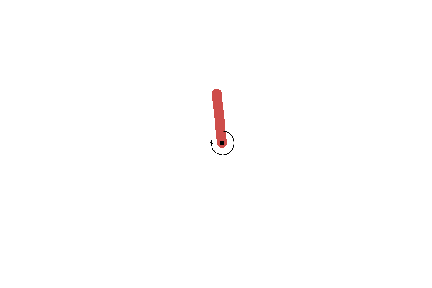
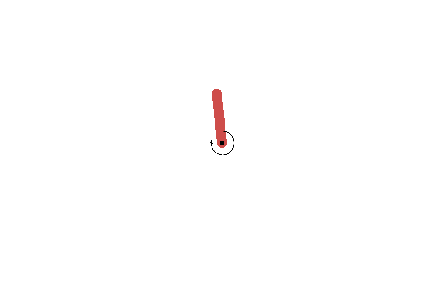
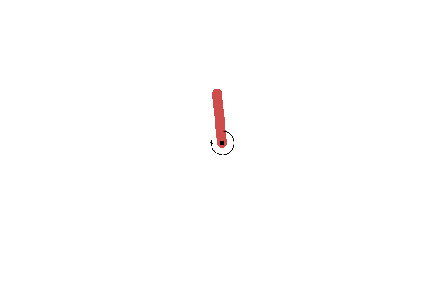
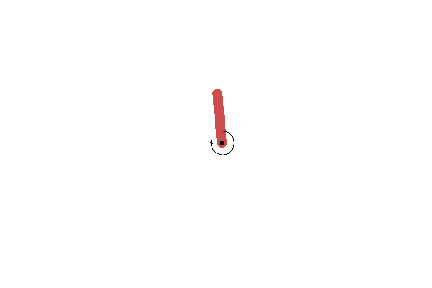
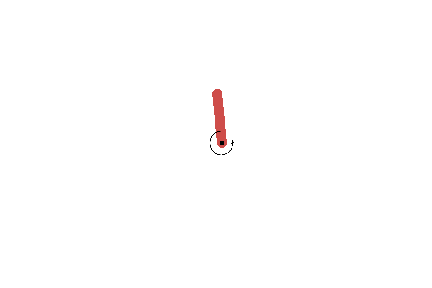
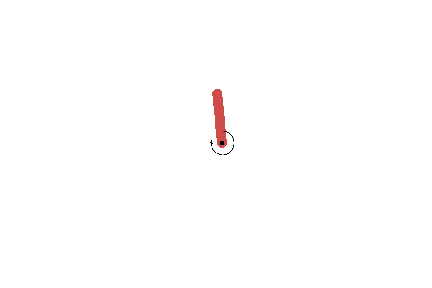
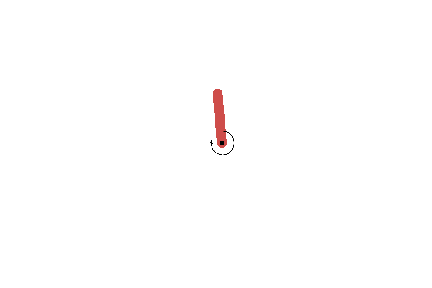
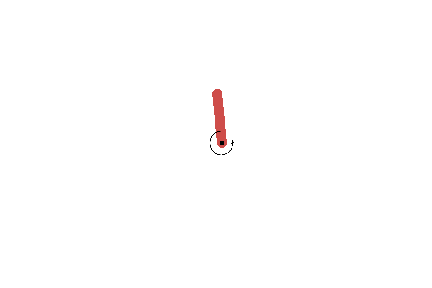
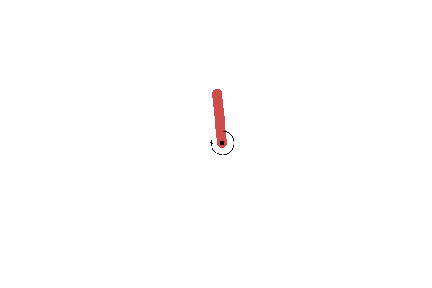
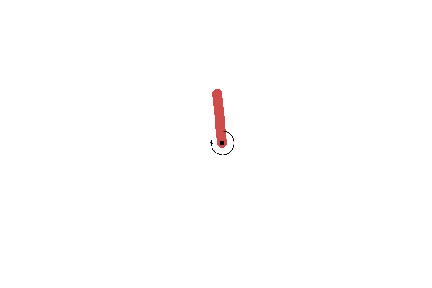
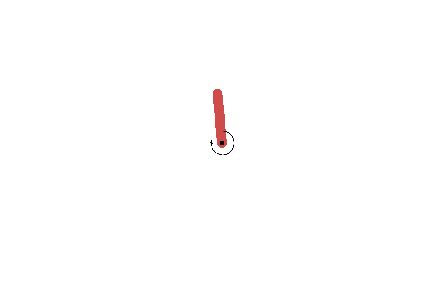
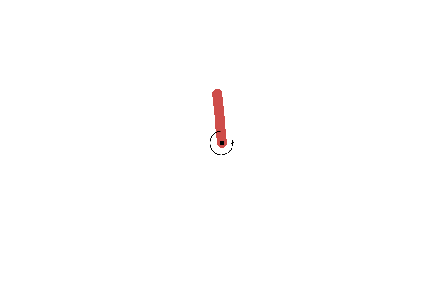
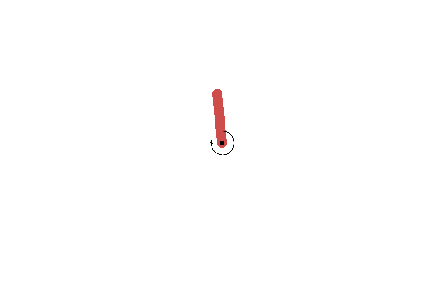
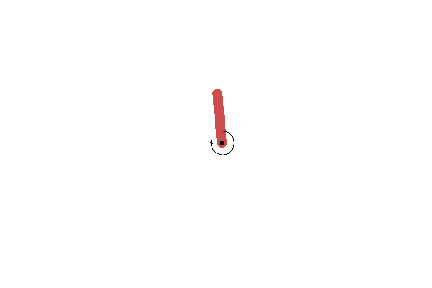
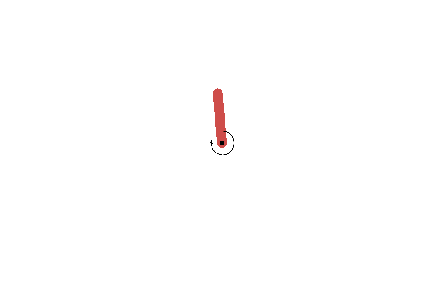
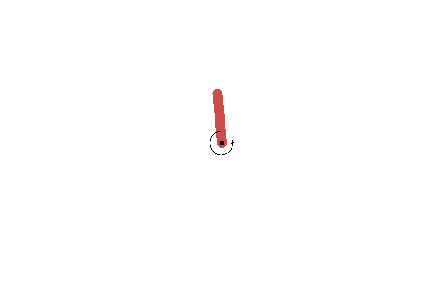
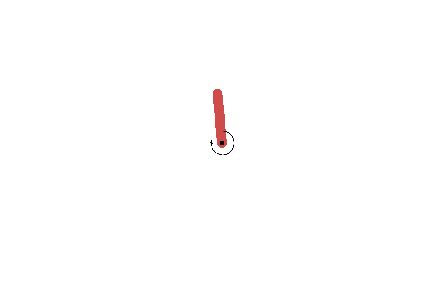
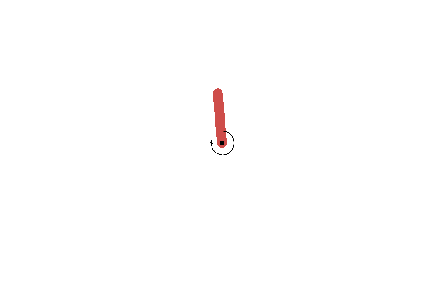
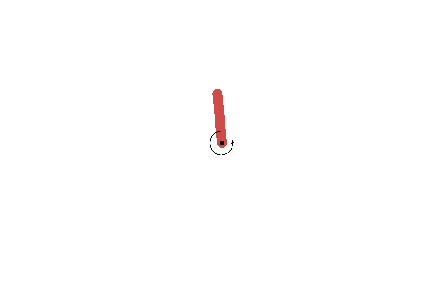
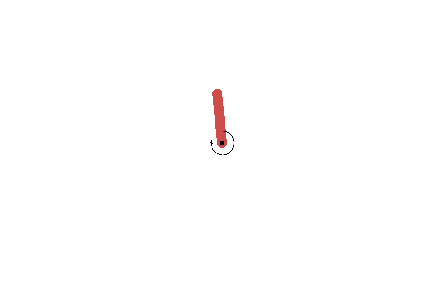
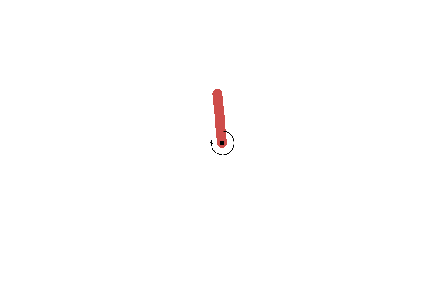
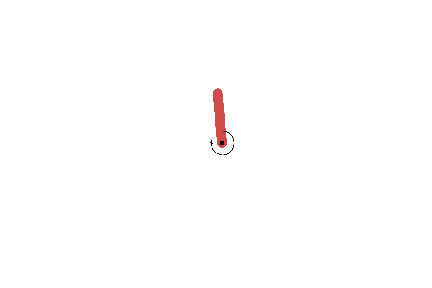
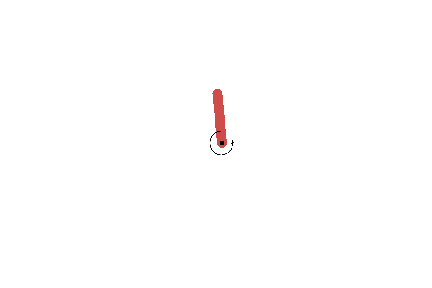
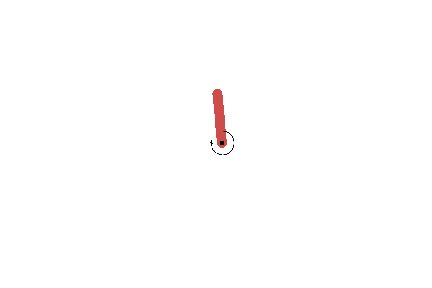
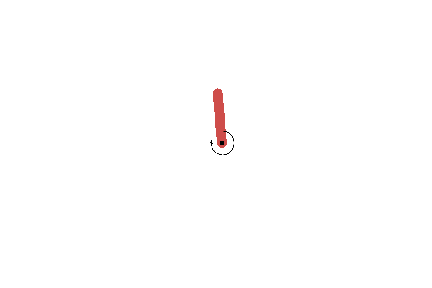
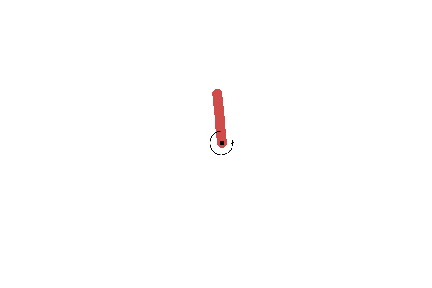
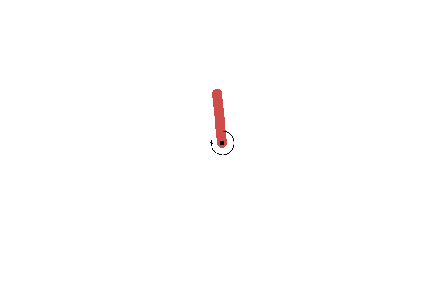
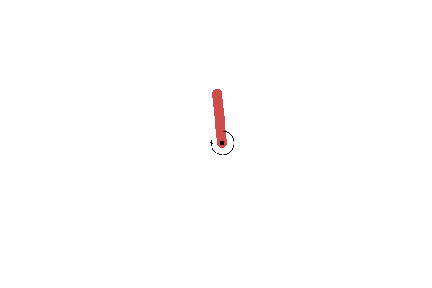
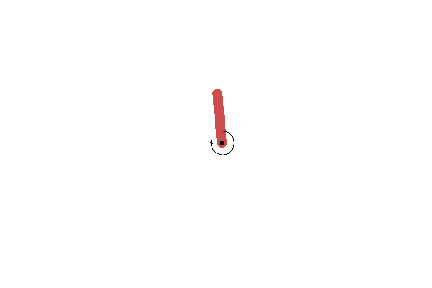
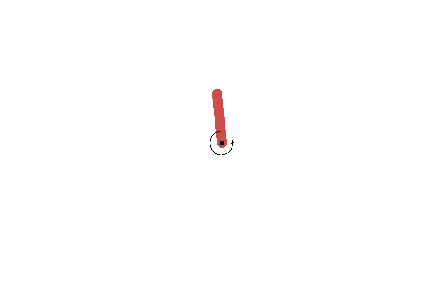
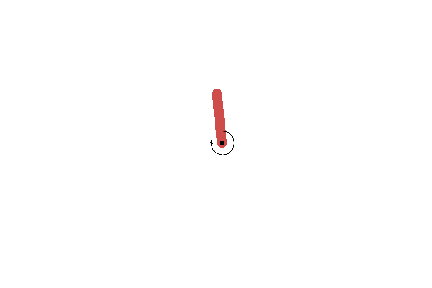
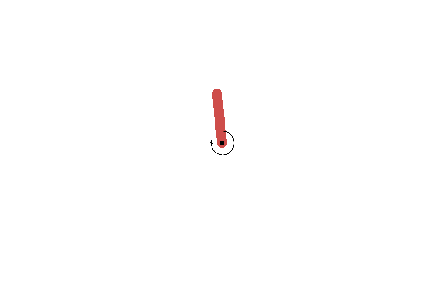
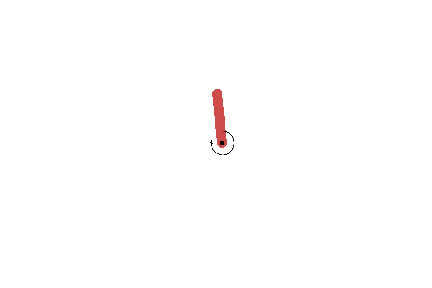
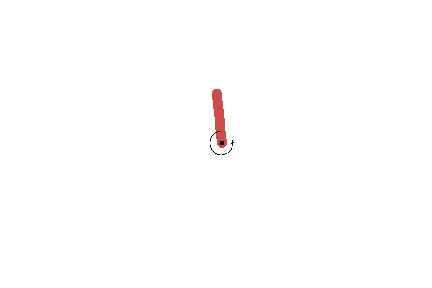
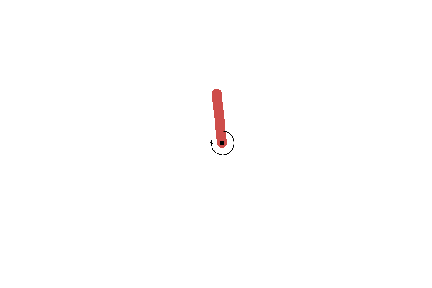
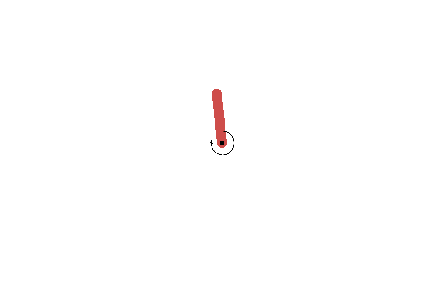
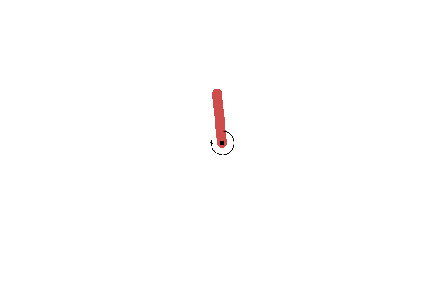
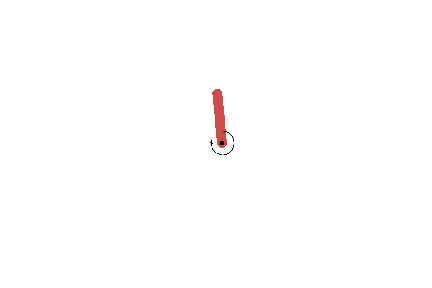
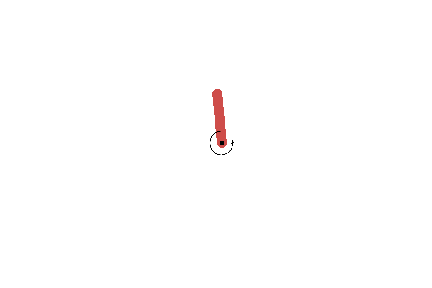
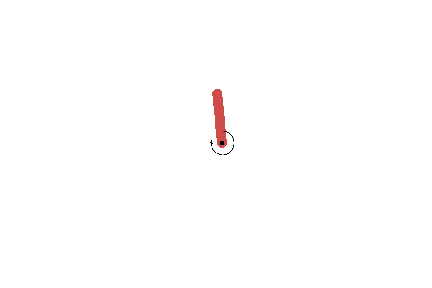
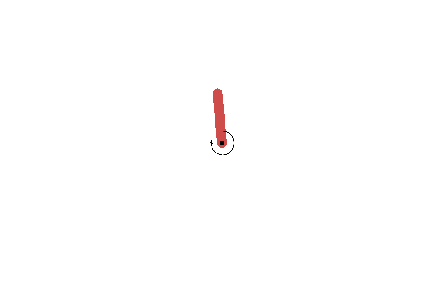
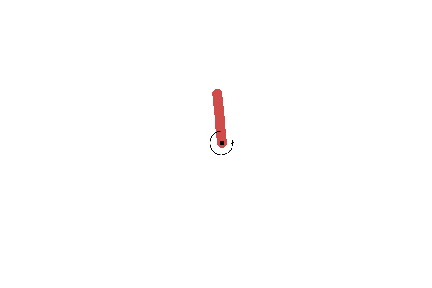
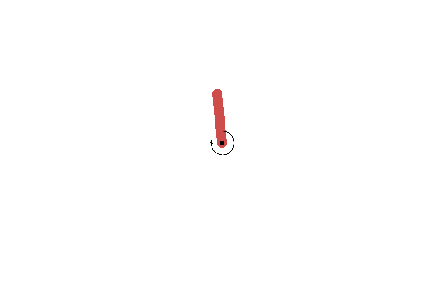
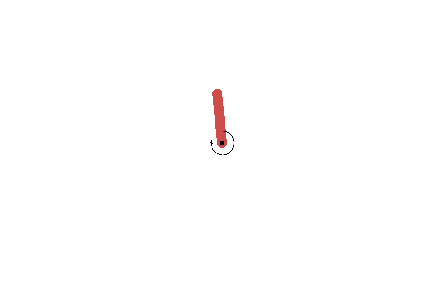
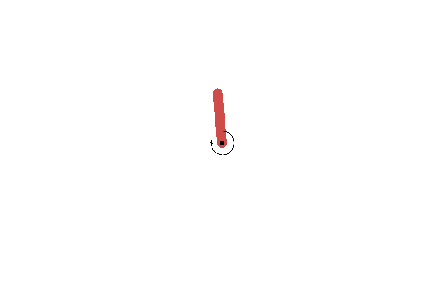
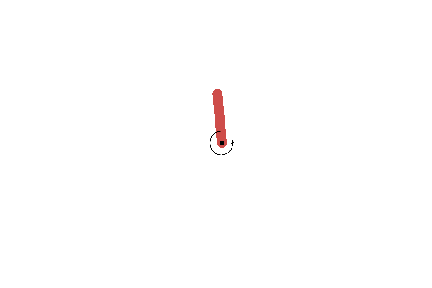
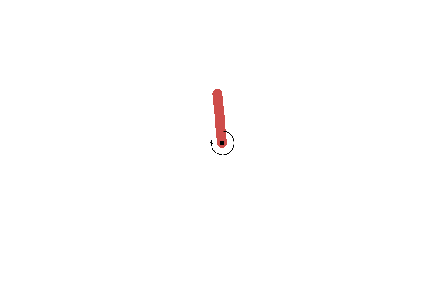
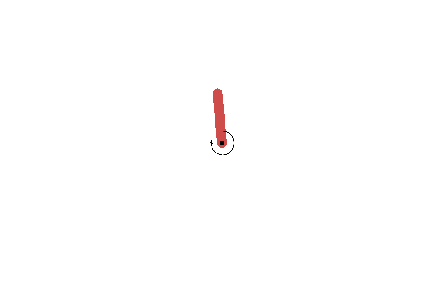
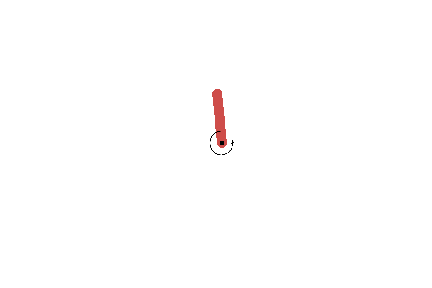
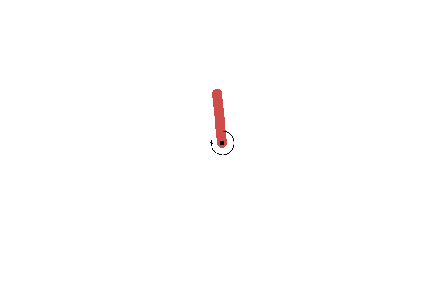
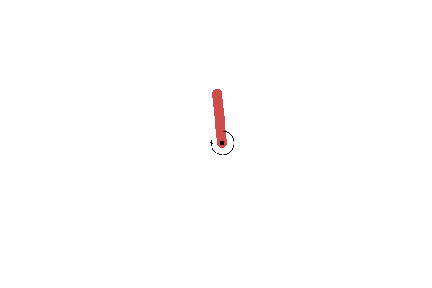
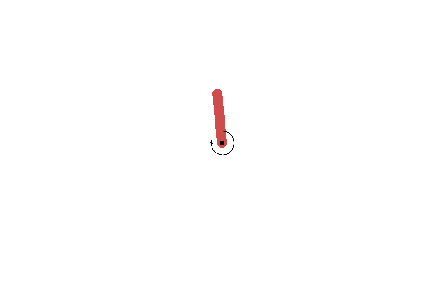
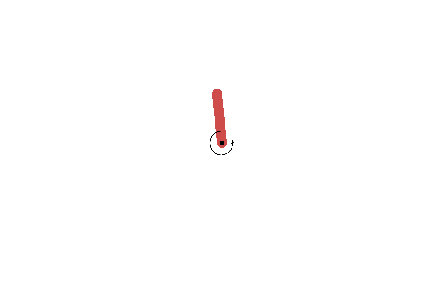
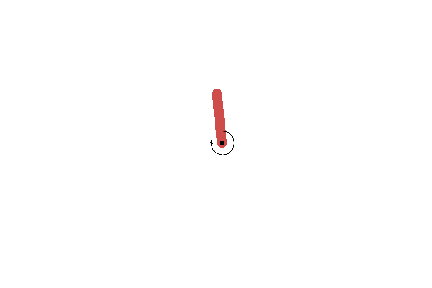
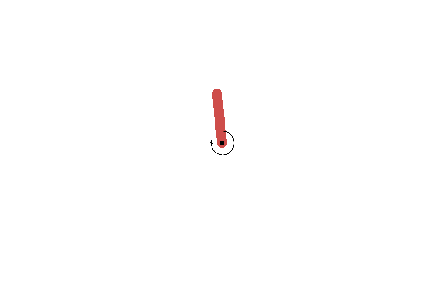
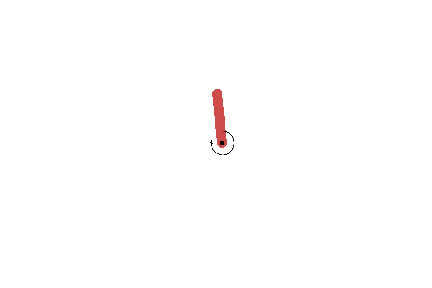
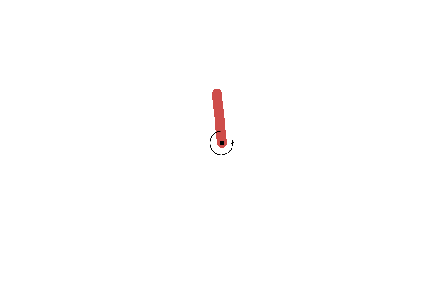
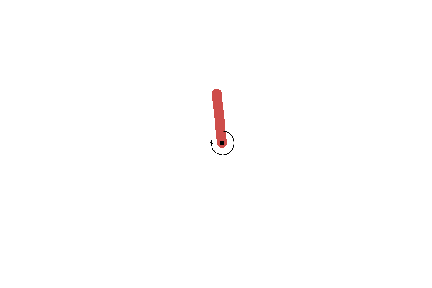
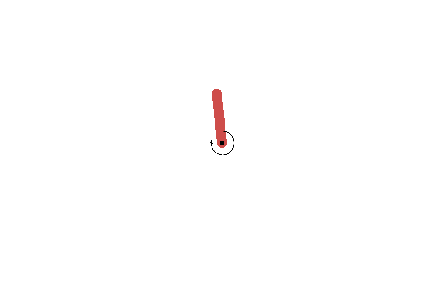
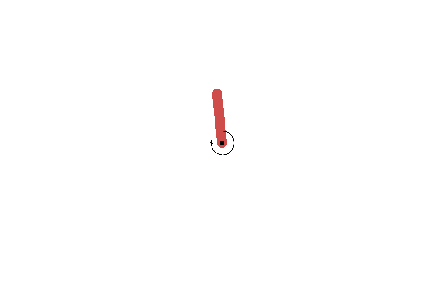
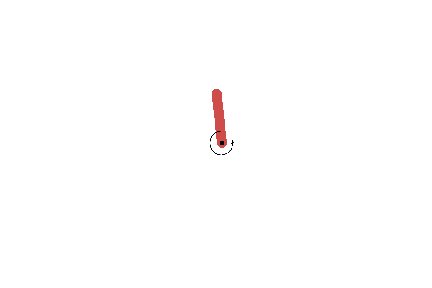
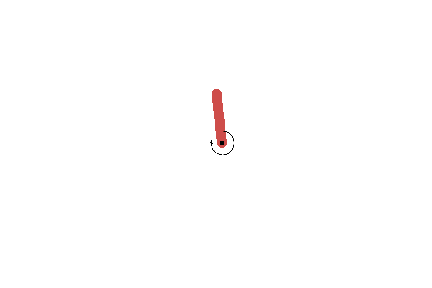
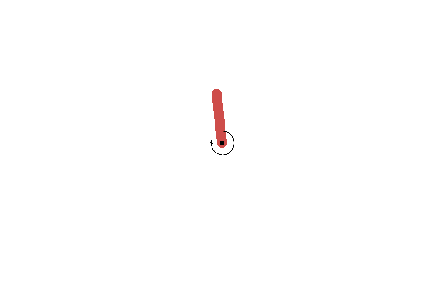
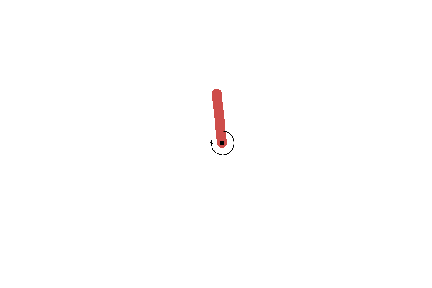
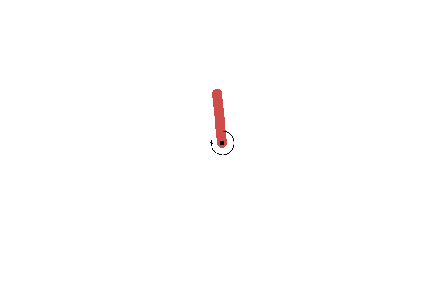
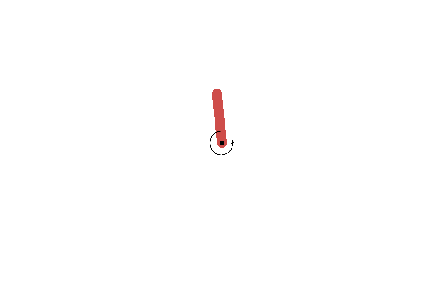
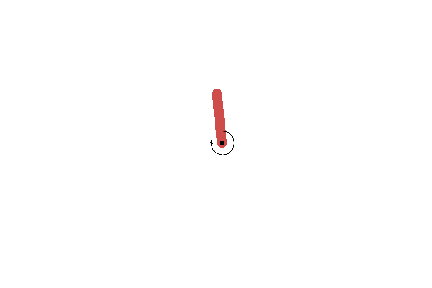
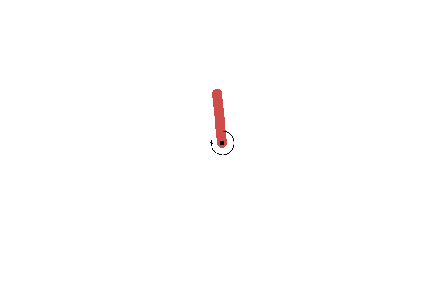
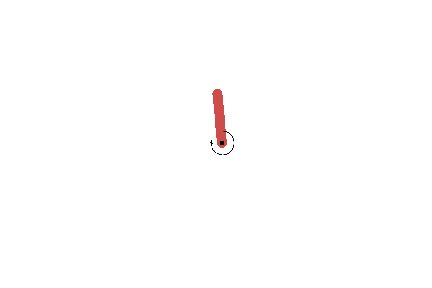
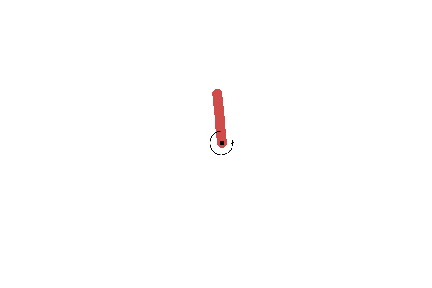
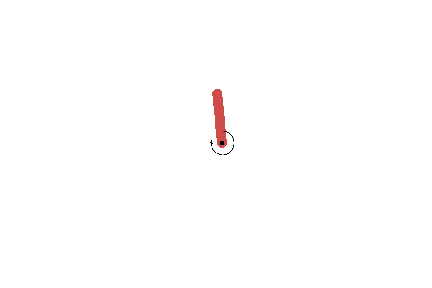
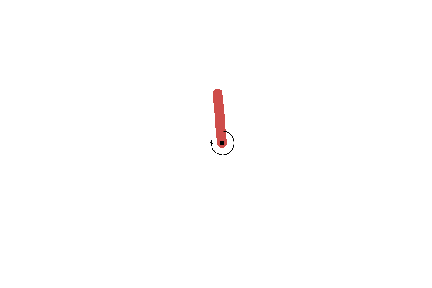
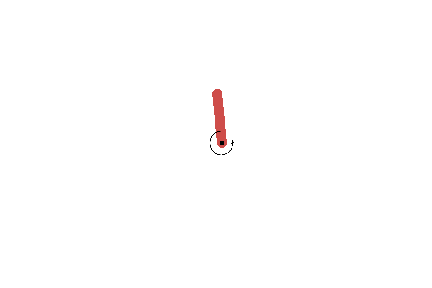
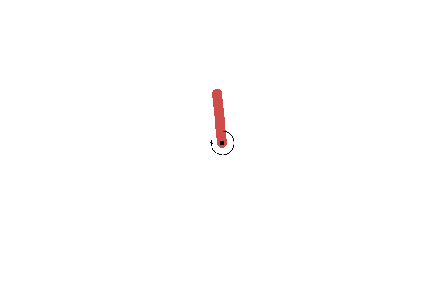
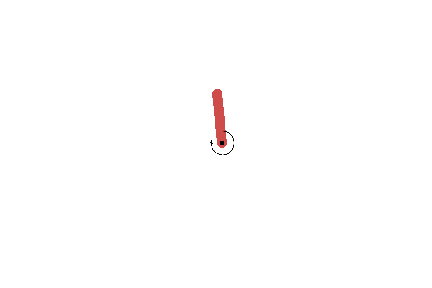
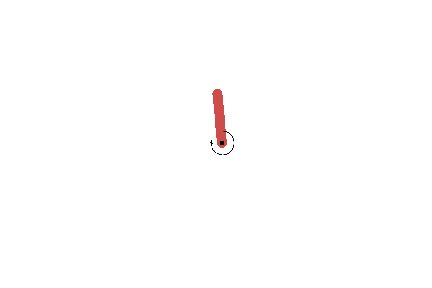
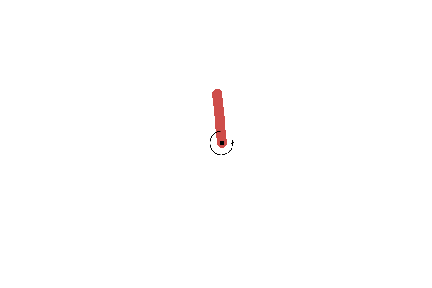
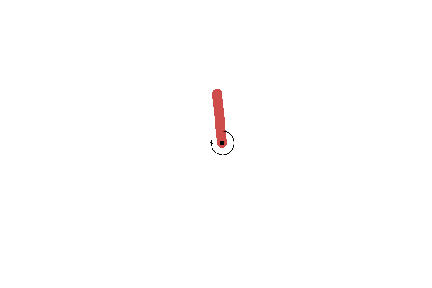
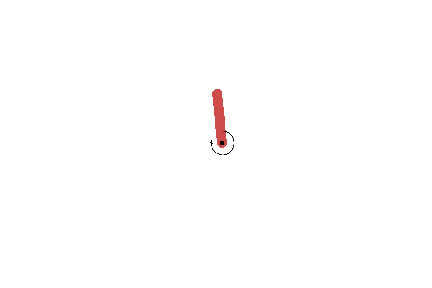
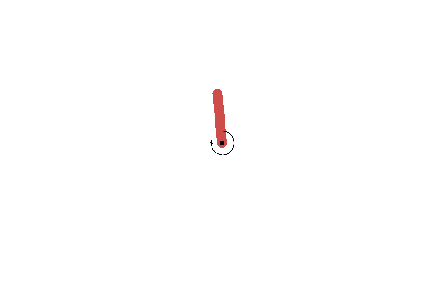
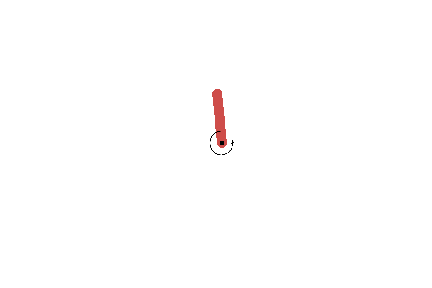
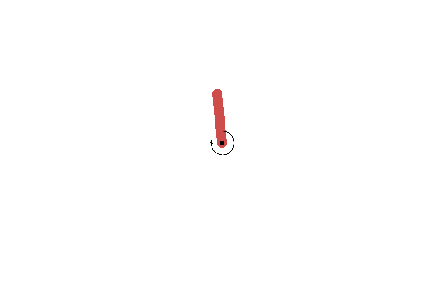
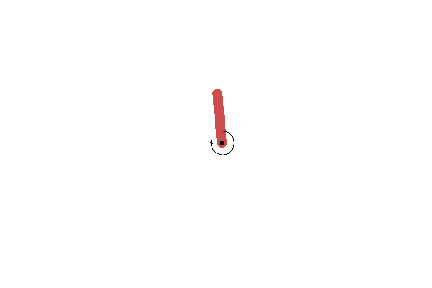
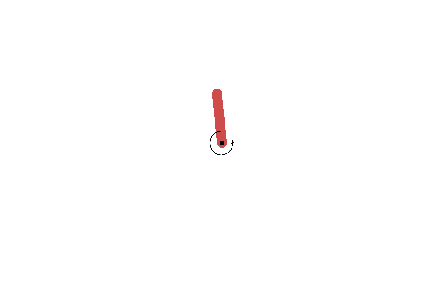
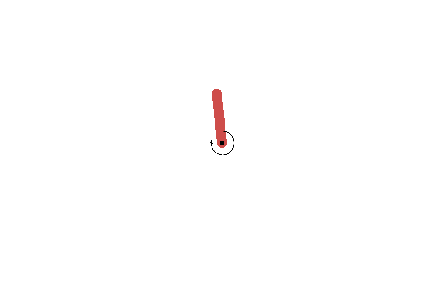
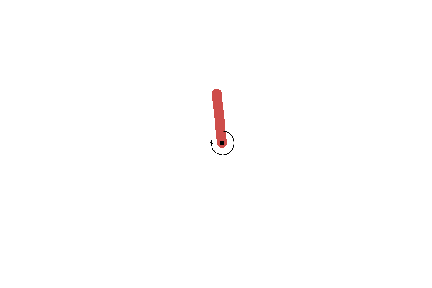
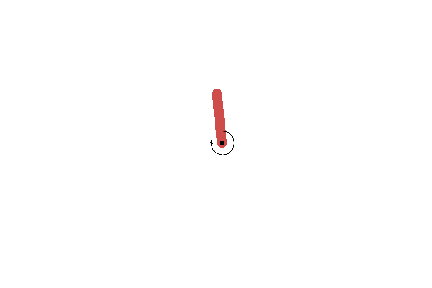
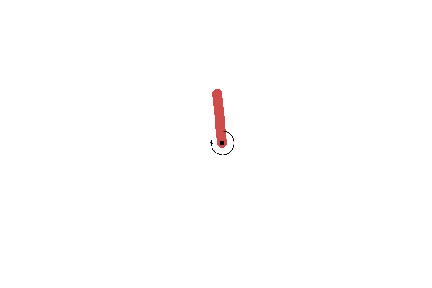
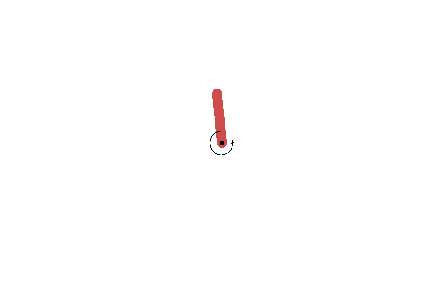
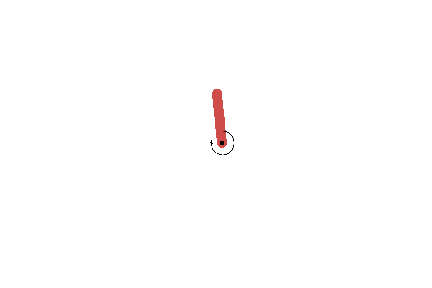
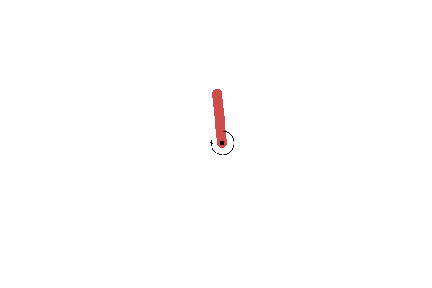
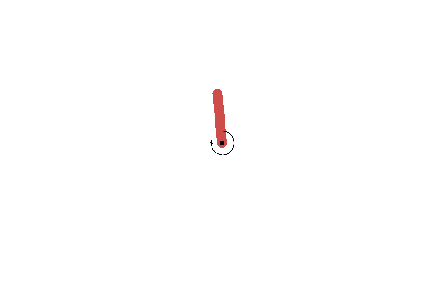
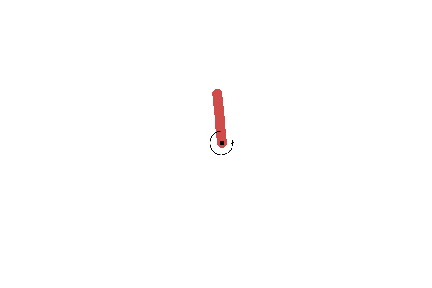
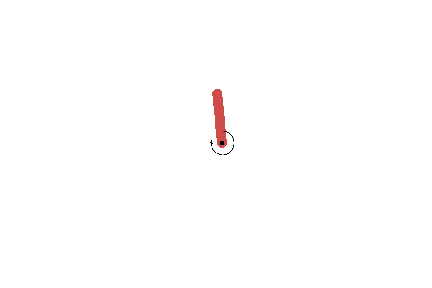
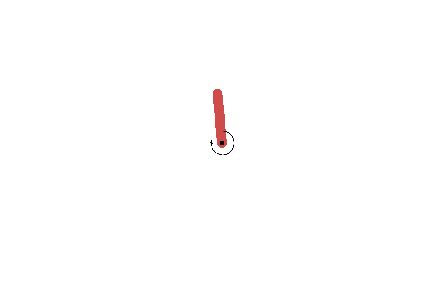

In [20]:
observation = env.reset()  # 環境はリセットする
dqn.reset_states()  # エージェントのメモリーをリセット
dqn.training = False  # 学習モードをOFF
frames = []  # 環境情報
while True:
    frames.append(env.render(mode='rgb_array'))
    action = processor.act2val[dqn.forward(observation)]
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()
display_frames_as_gif(frames)

##### 別のシミュレーション環境を試してみる([Acrobot-v1](https://gym.openai.com/envs/Acrobot-v1/))

環境を定義

In [21]:
env = gym.make('Acrobot-v1')
observation = env.reset()
print('環境情報', observation)
action = env.action_space.sample()
print('アクション例', action)
print('アクション数', env.action_space.n)
# action→右に回すか左に回すか何もしないか

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
環境情報 [ 0.99835892  0.05726659  0.99763008 -0.06880574  0.03293251 -0.02852598]
アクション例 1
アクション数 3


報酬はwikiに載っていないので、[コード](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py)を直接確認する
```python
reward = -1. if not terminal else 0.
```
-1 or 0

今後`env.reward_space`でアクションのように取得できるようにする予定らしい(→[issue33](https://github.com/openai/gym/issues/33))

どんな環境か、ランダムに動かして確認


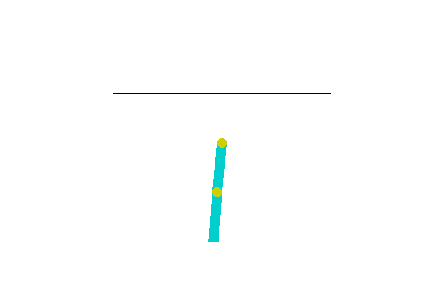
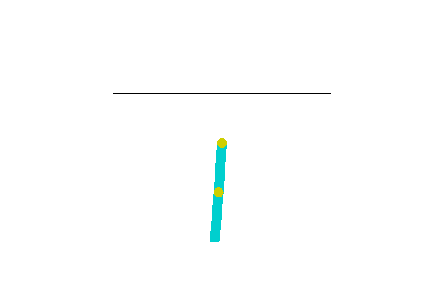
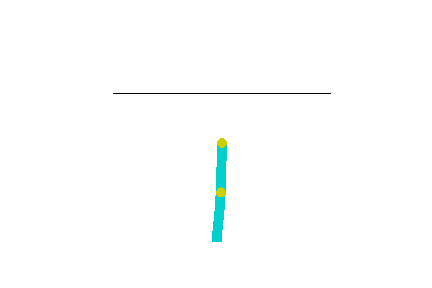
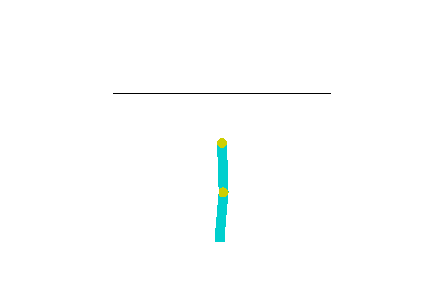
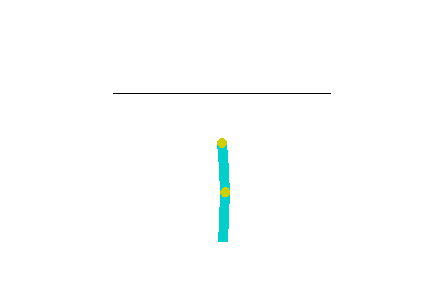
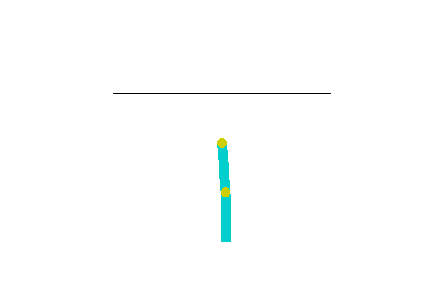
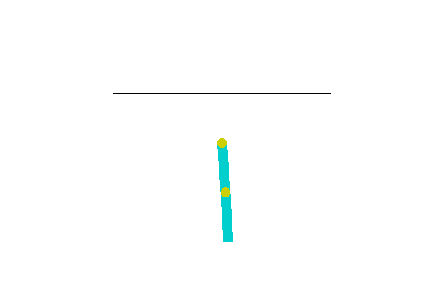
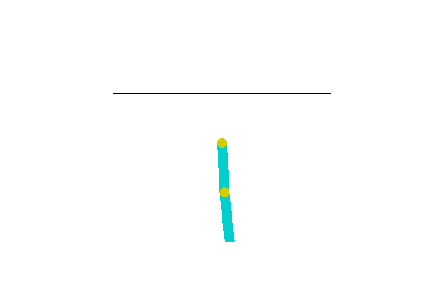
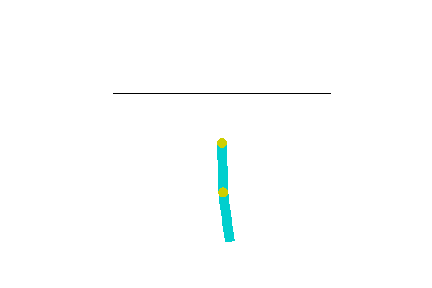
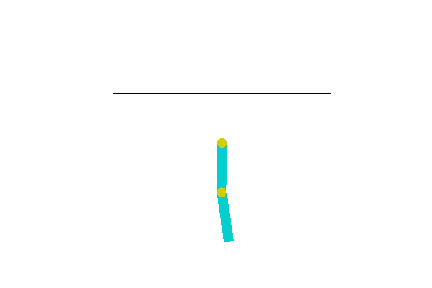
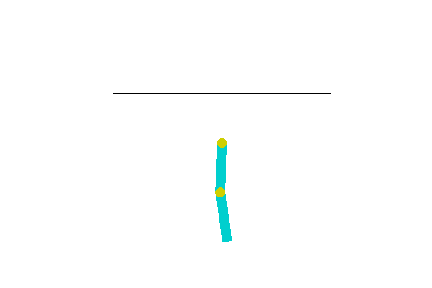
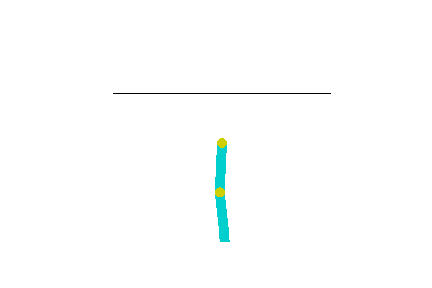
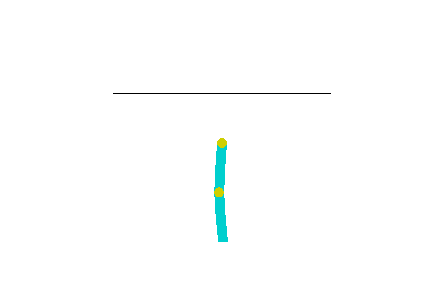
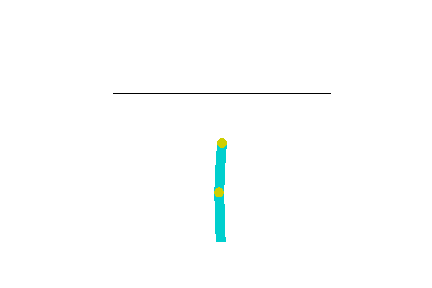
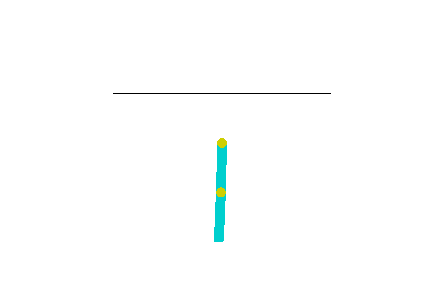
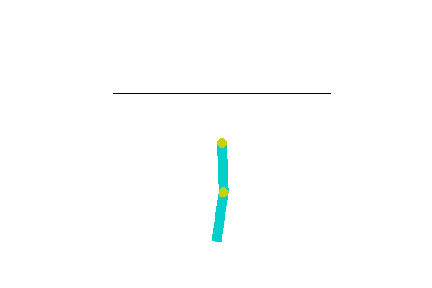
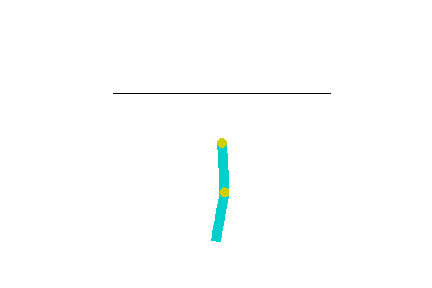
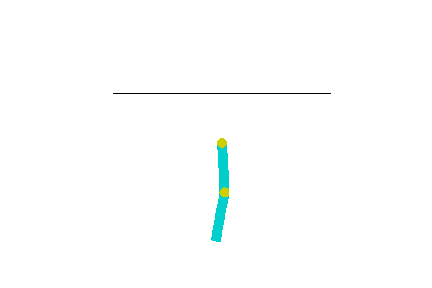
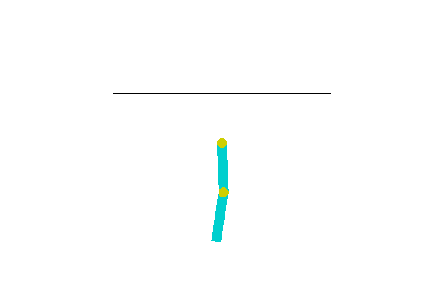
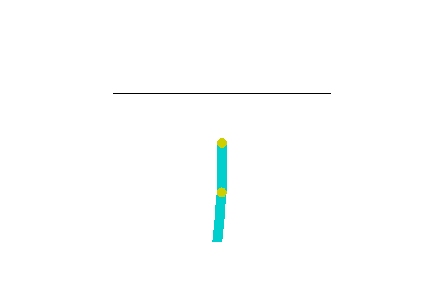
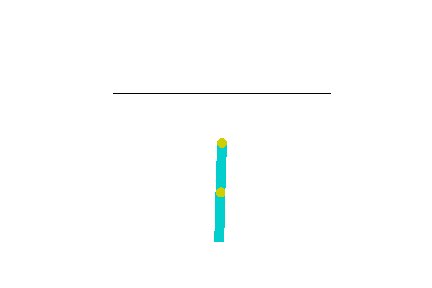
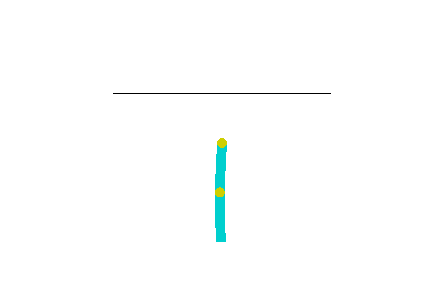
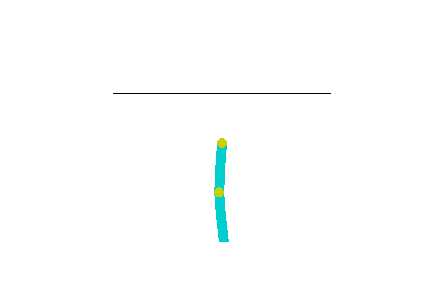
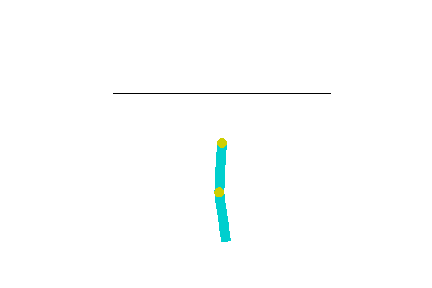
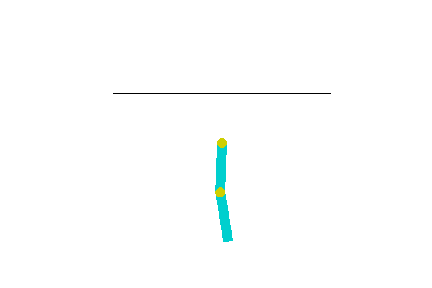
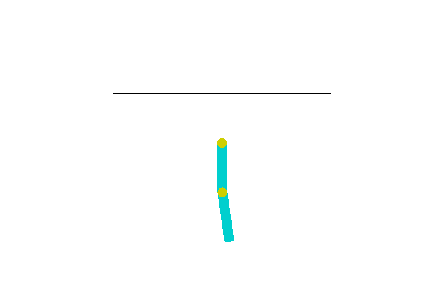
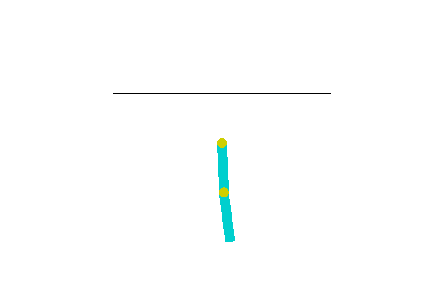
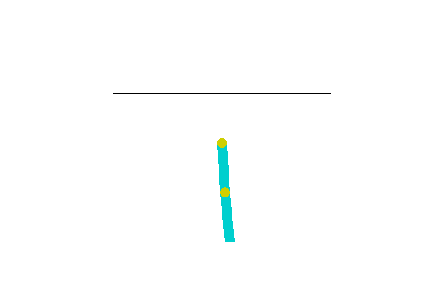
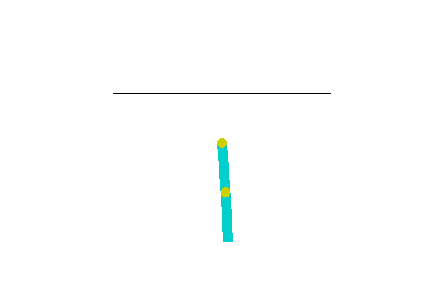
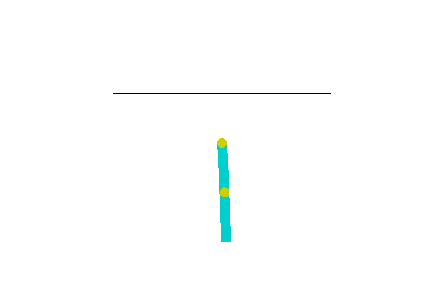
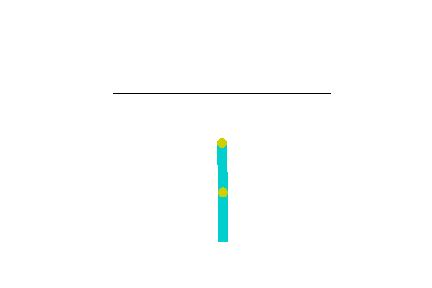
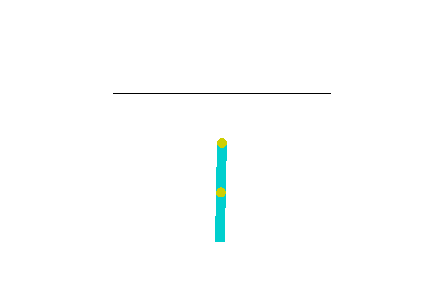
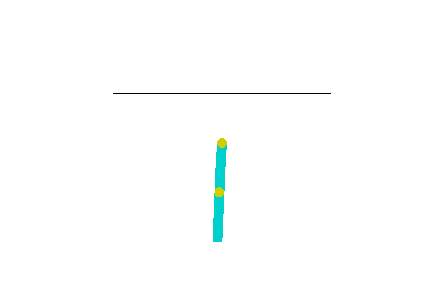
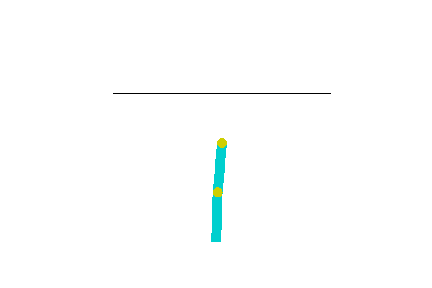
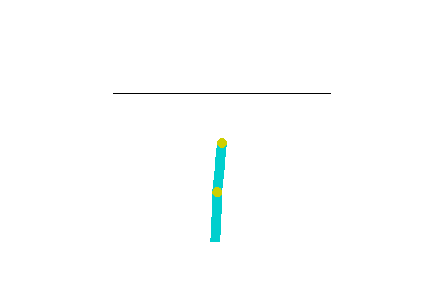
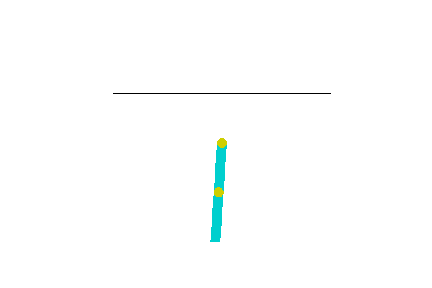
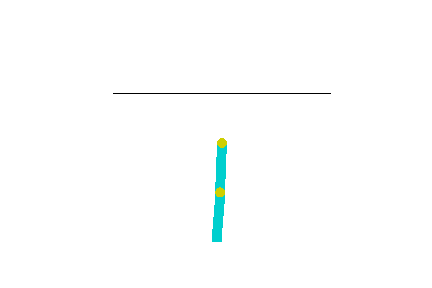
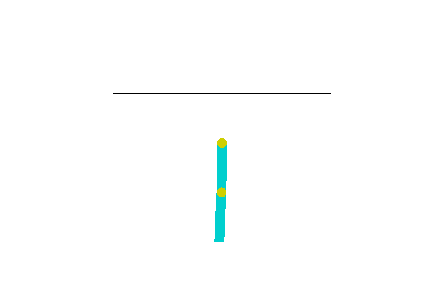
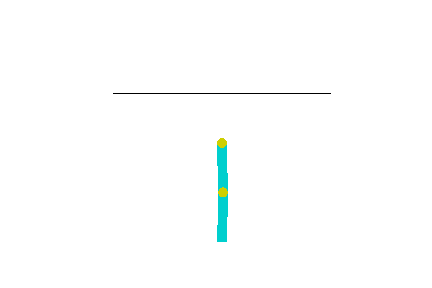
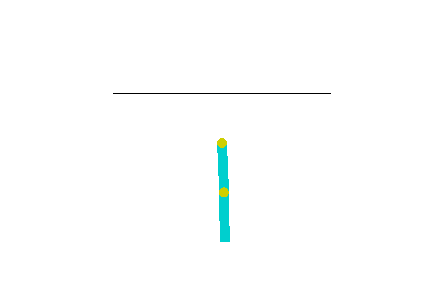
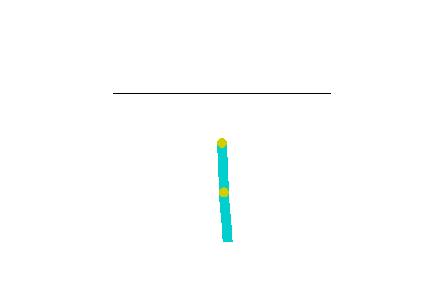
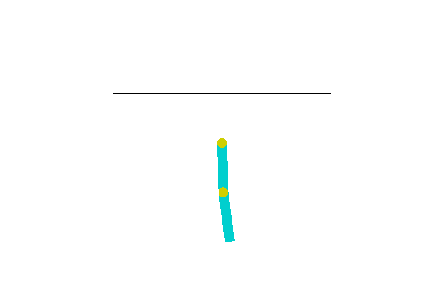
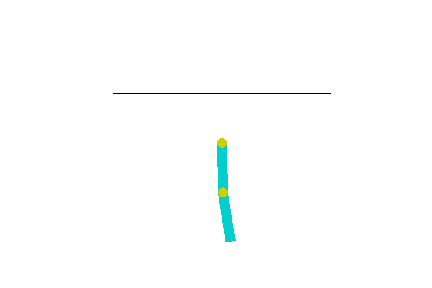
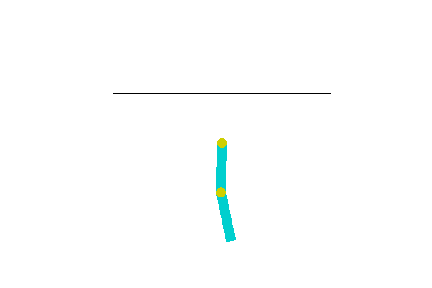
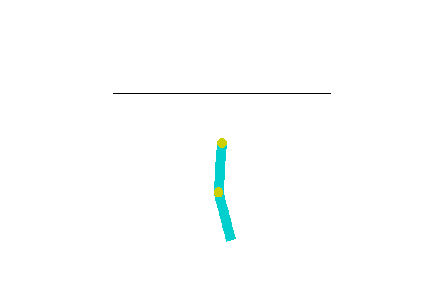
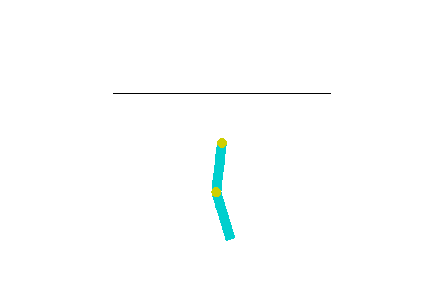
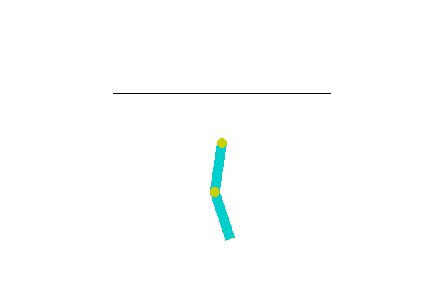
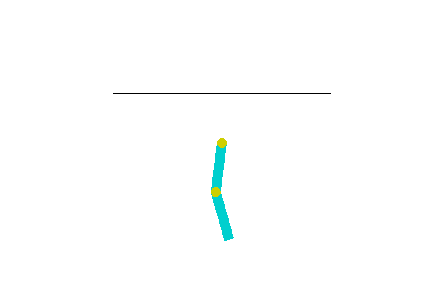
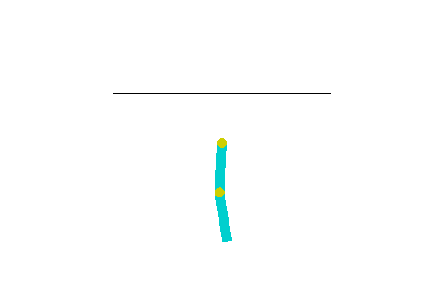
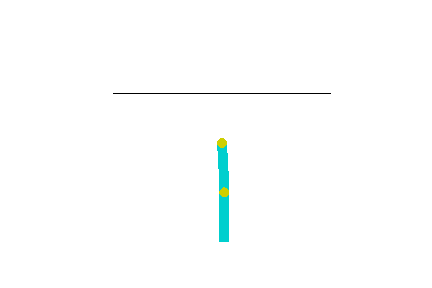
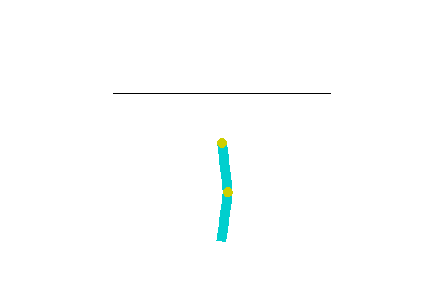
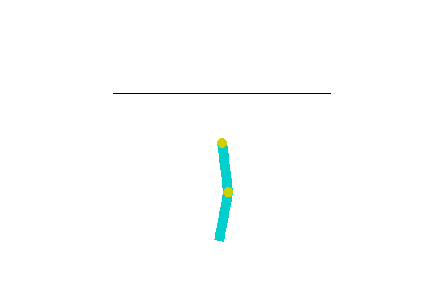
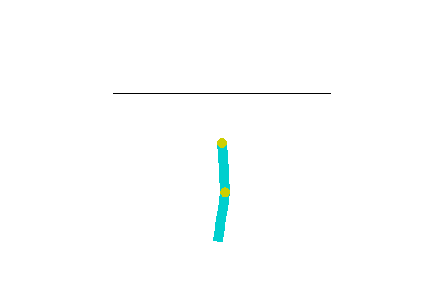
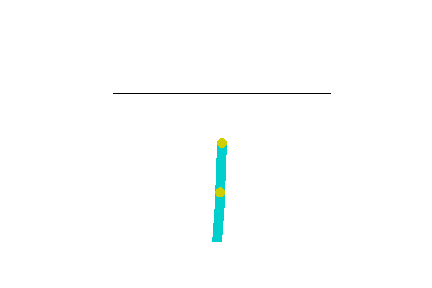
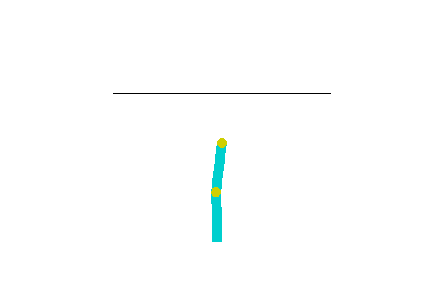
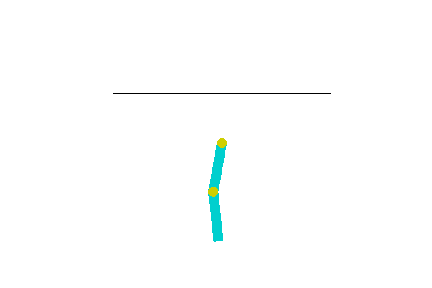
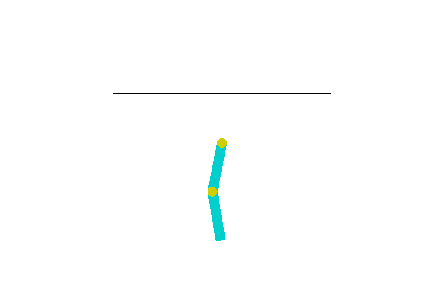
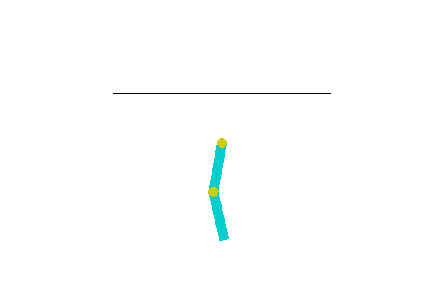
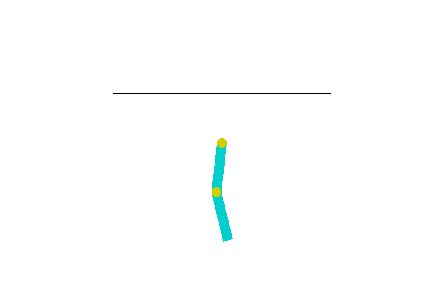
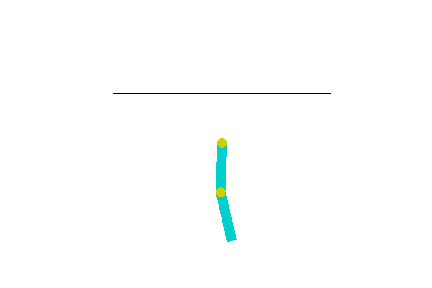
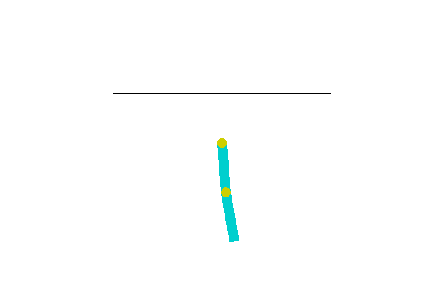
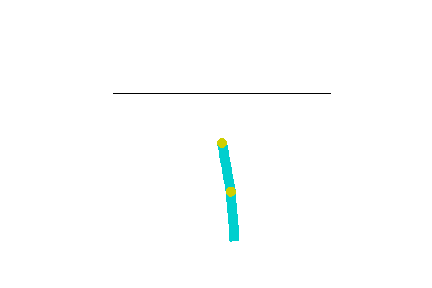
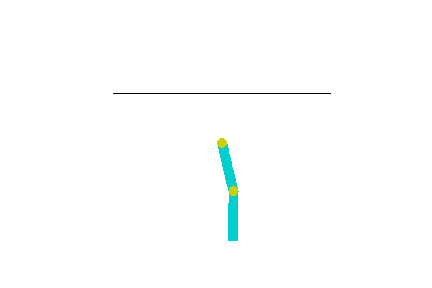
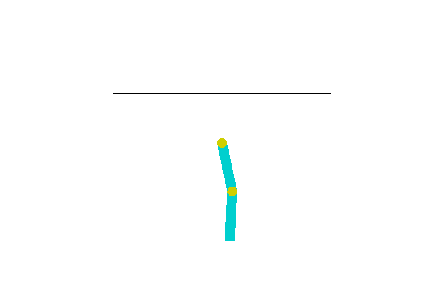
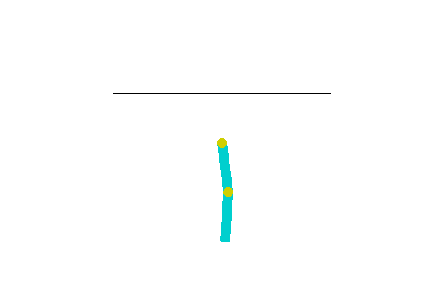
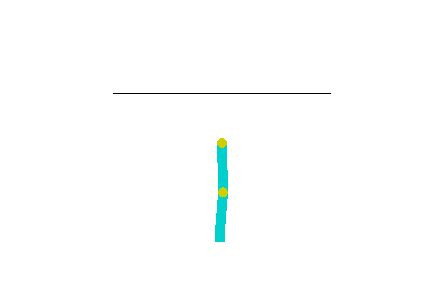
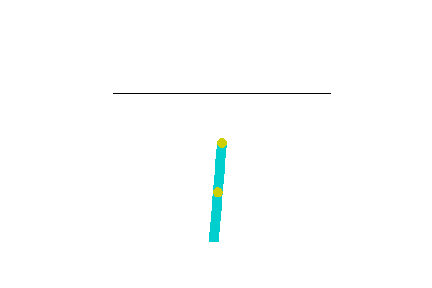
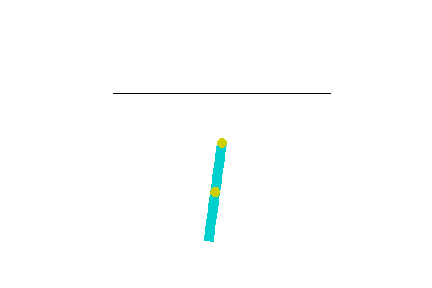
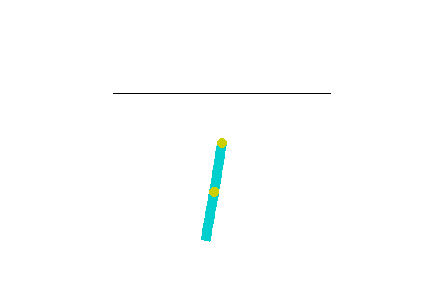
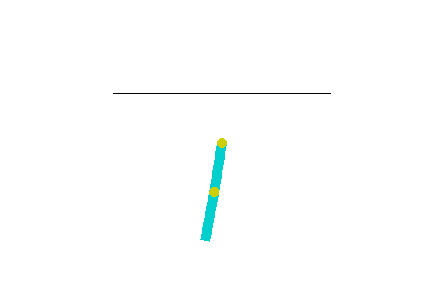
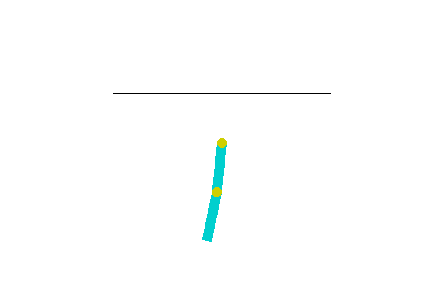
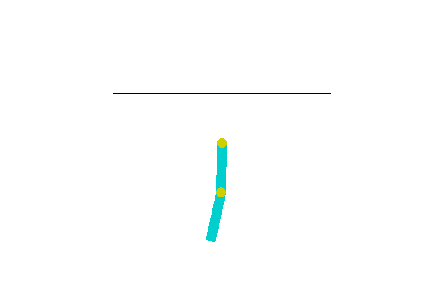
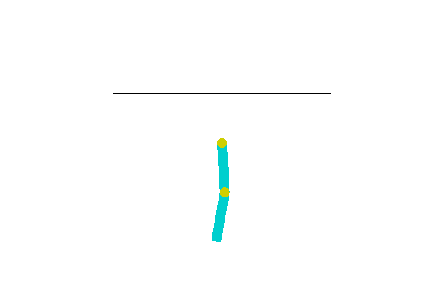
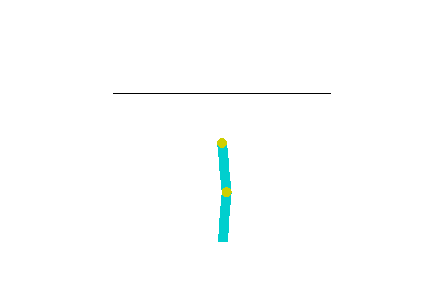
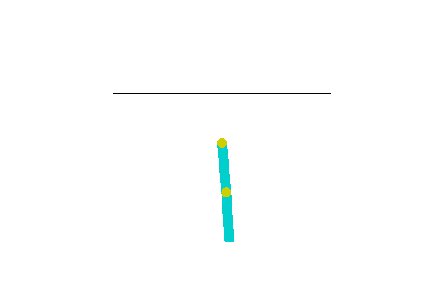
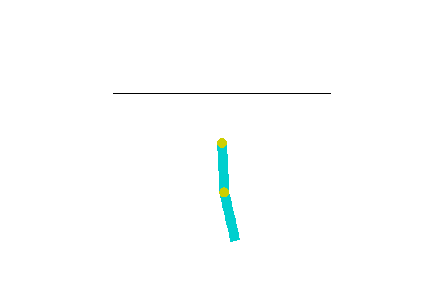
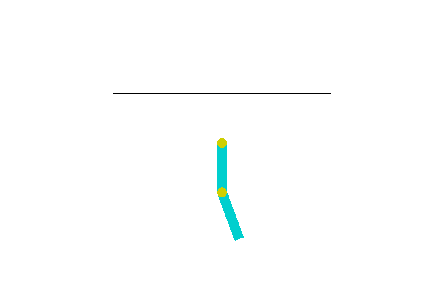
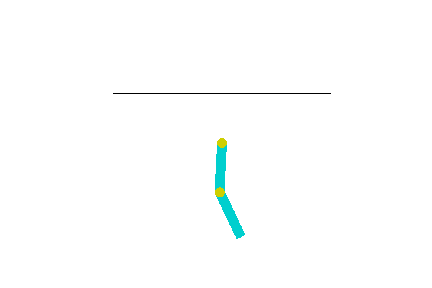
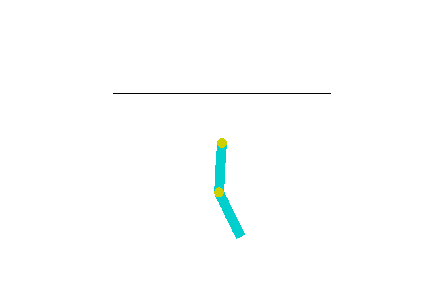
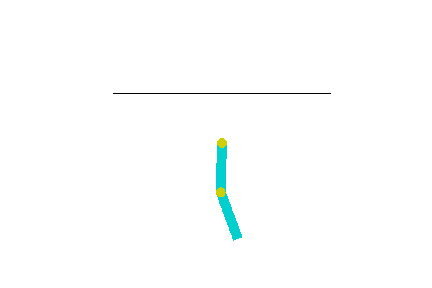
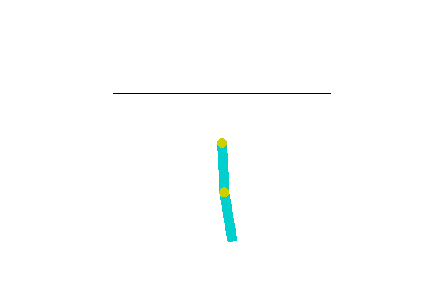
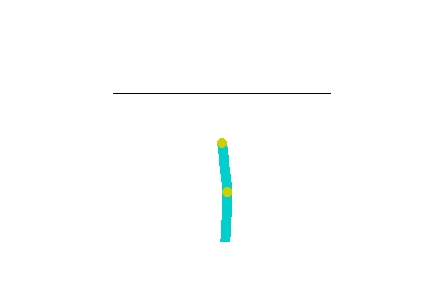
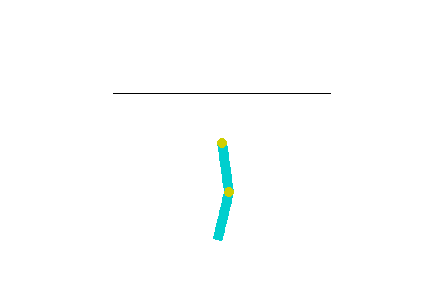
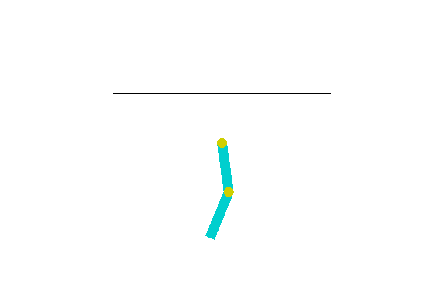
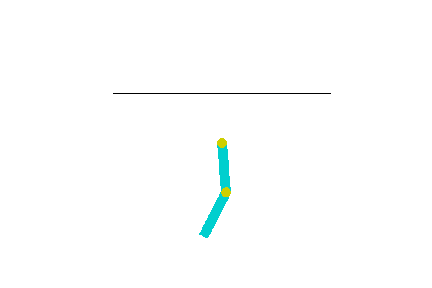
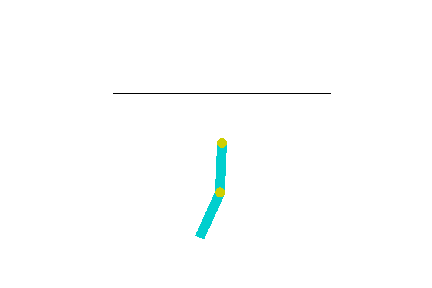
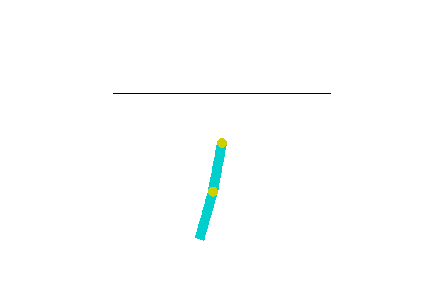
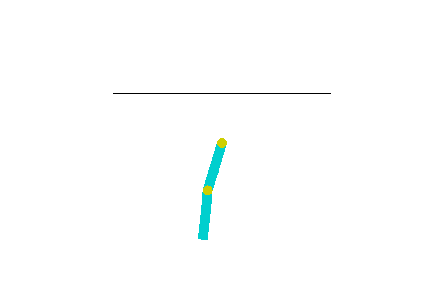
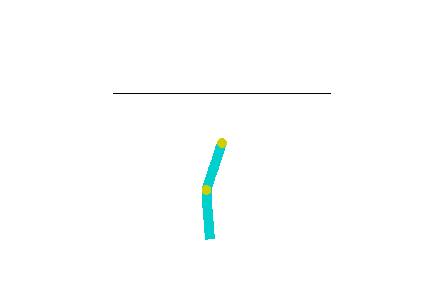
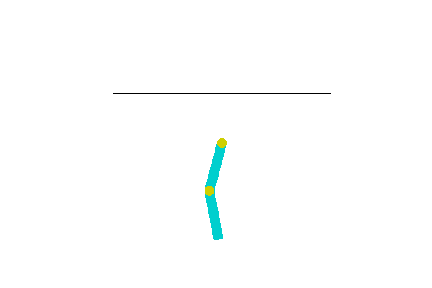
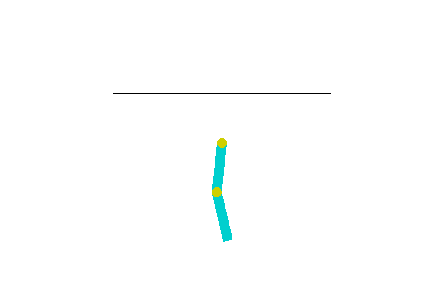
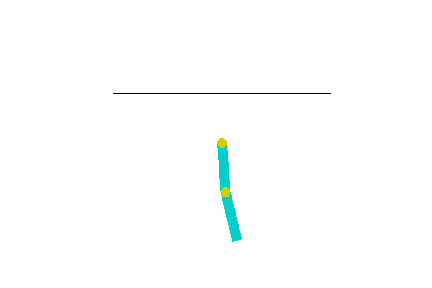
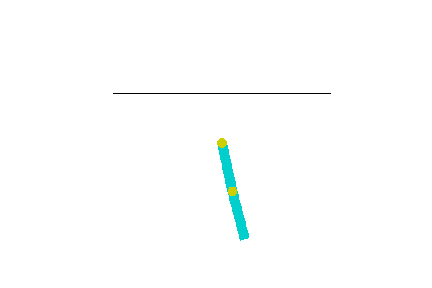
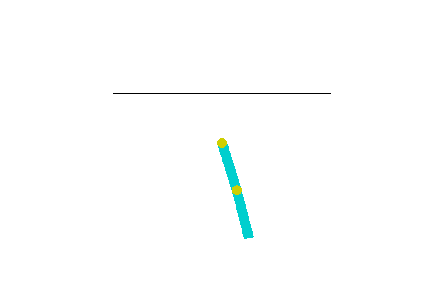
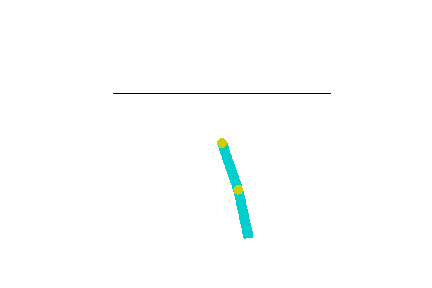
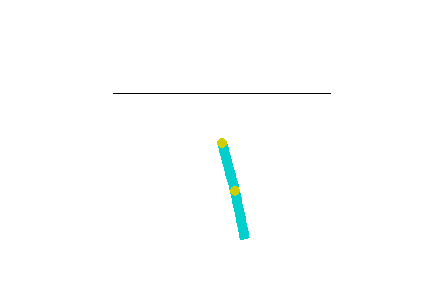
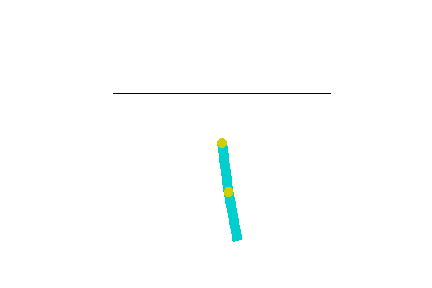
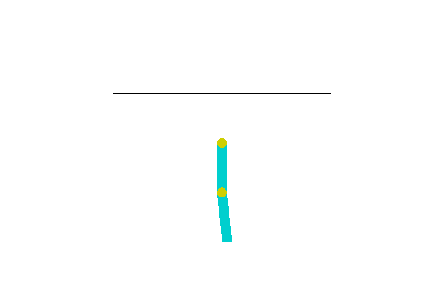
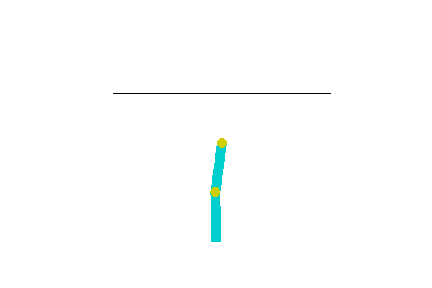
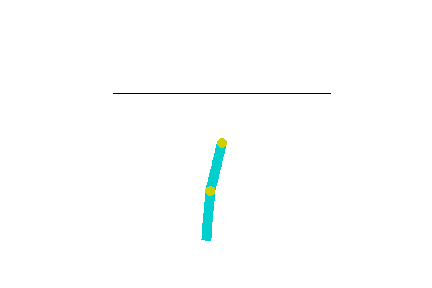
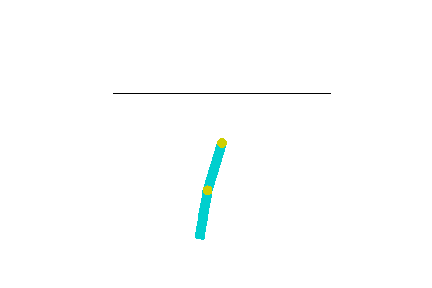
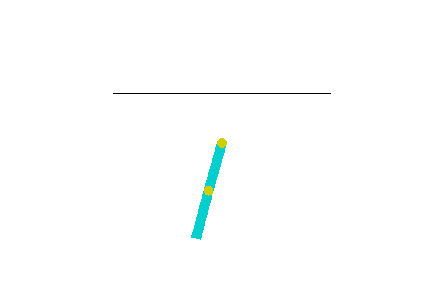
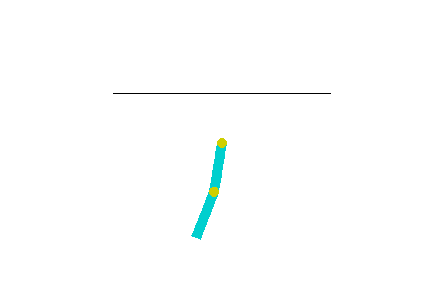
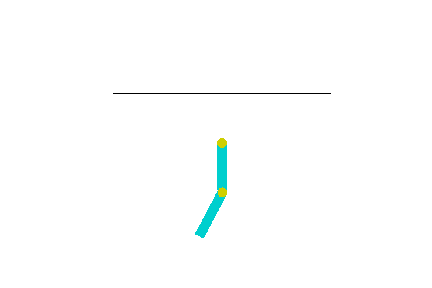
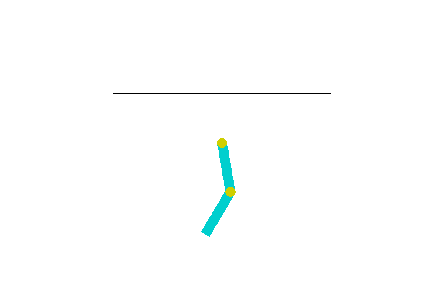
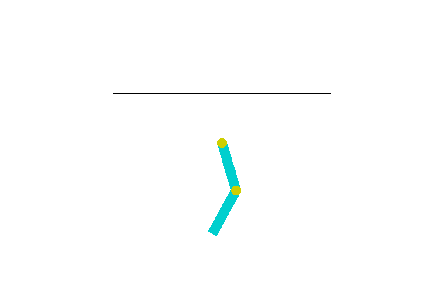
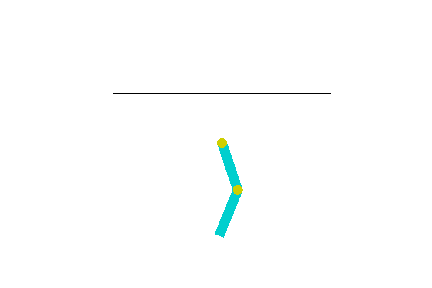
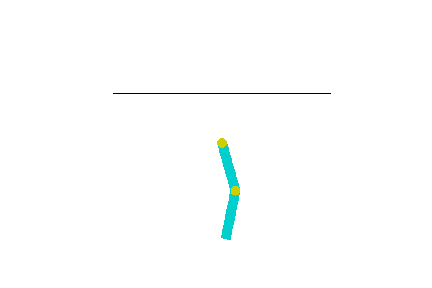
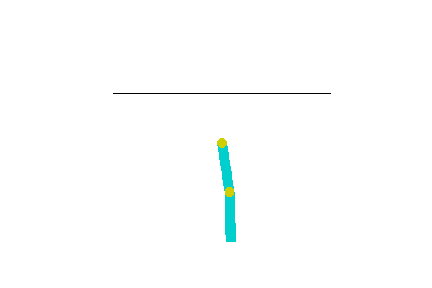
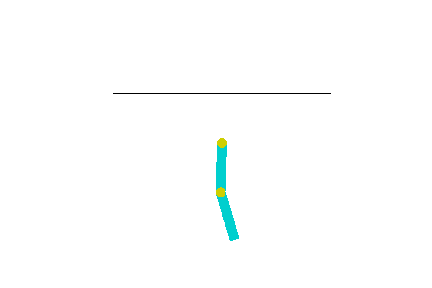
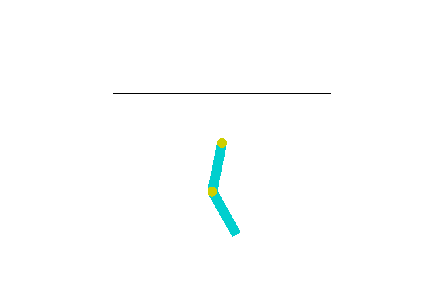
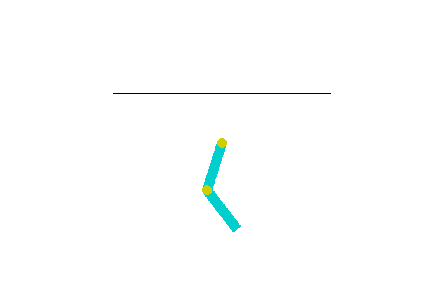
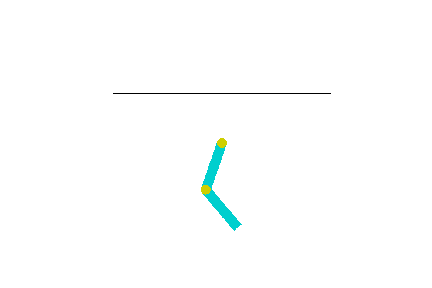
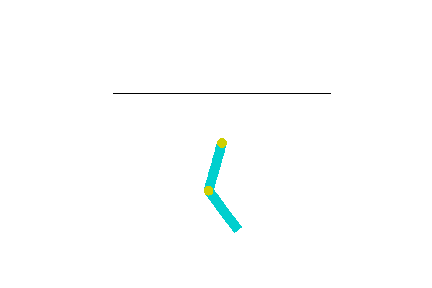
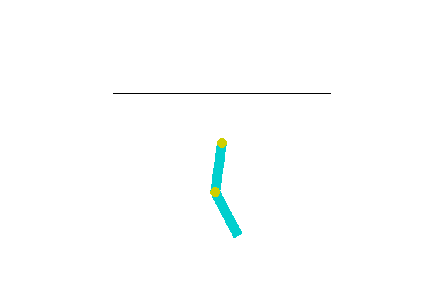
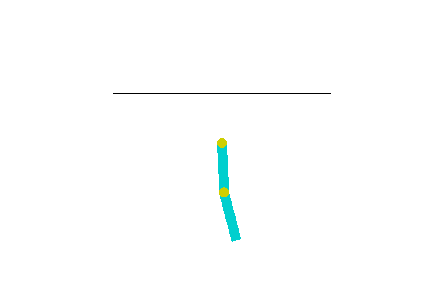
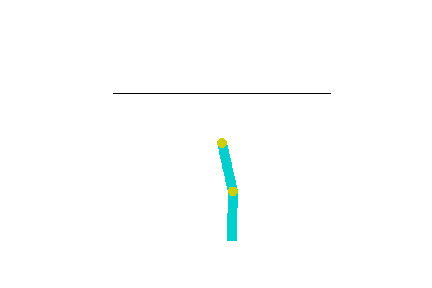
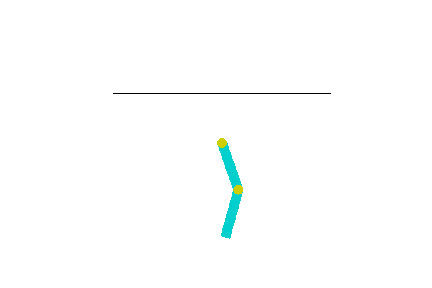
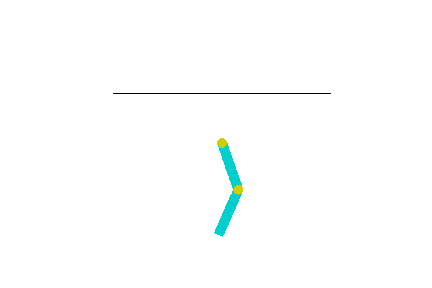
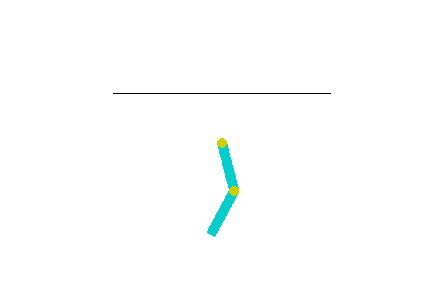
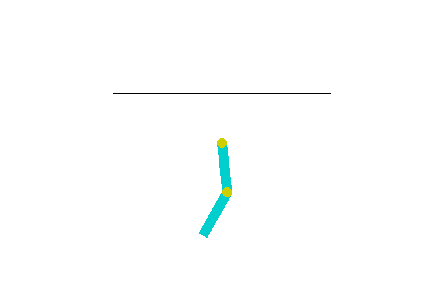
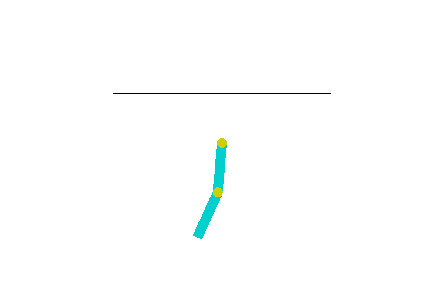
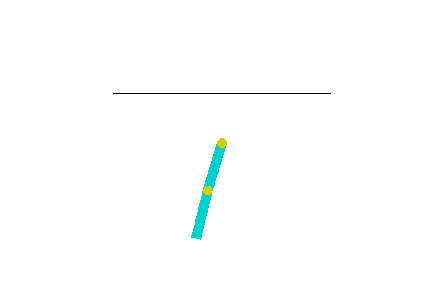
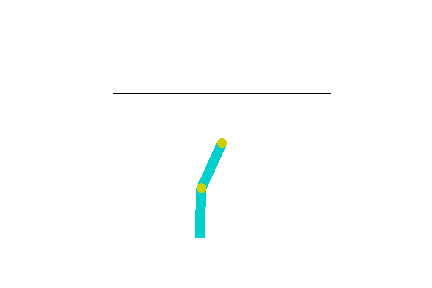
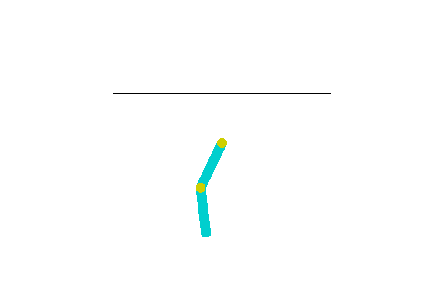
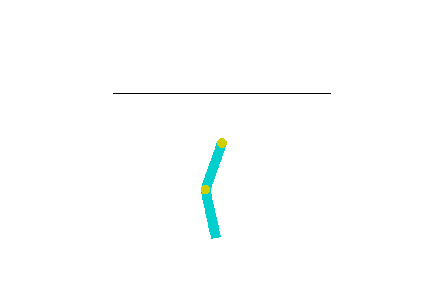
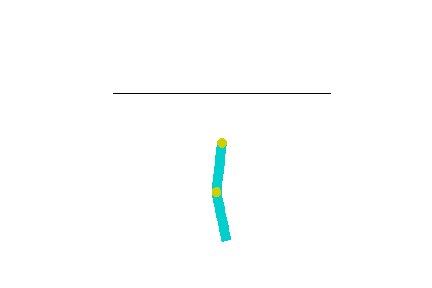
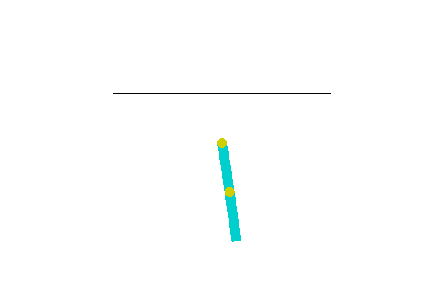
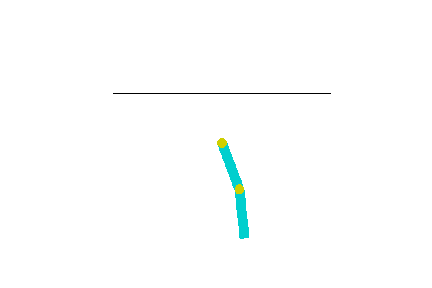
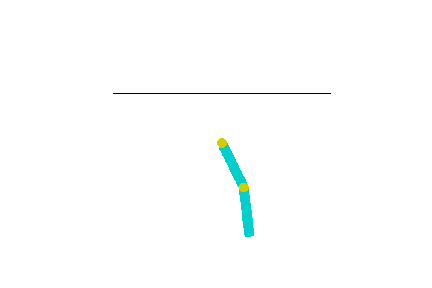
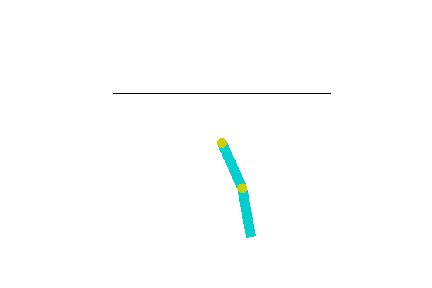
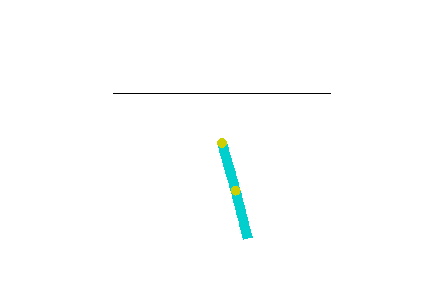
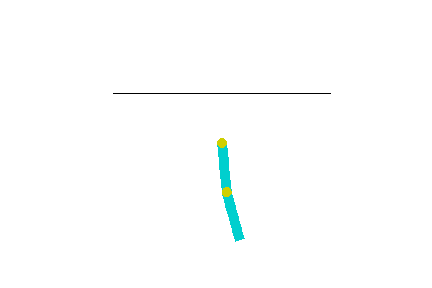
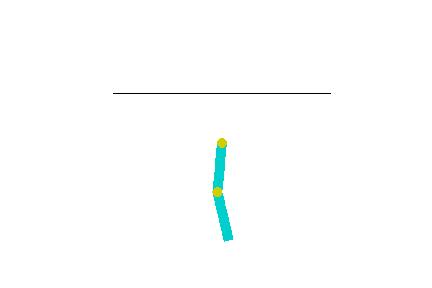
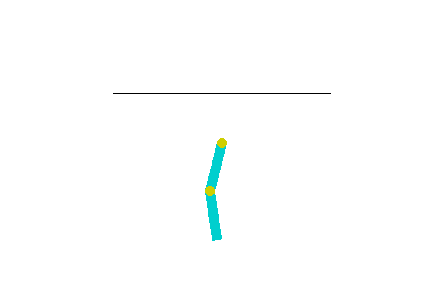
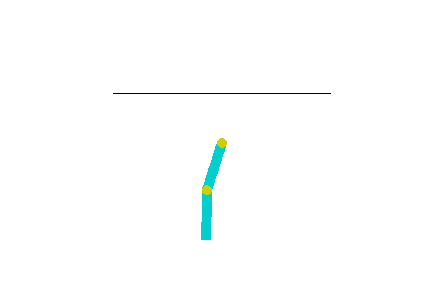
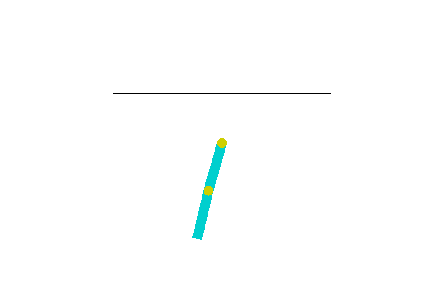
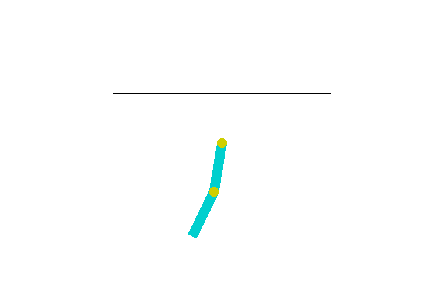
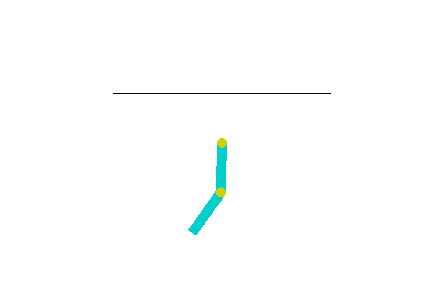
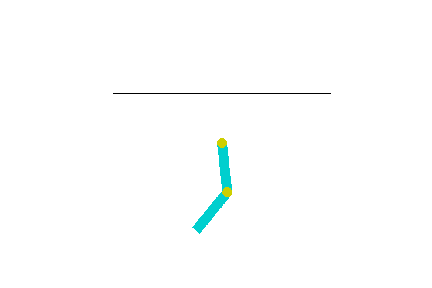
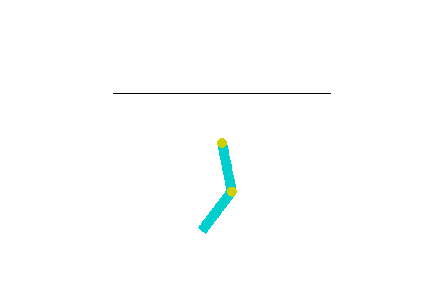
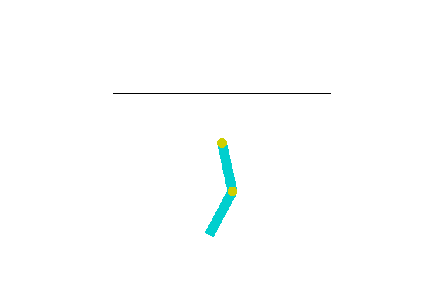
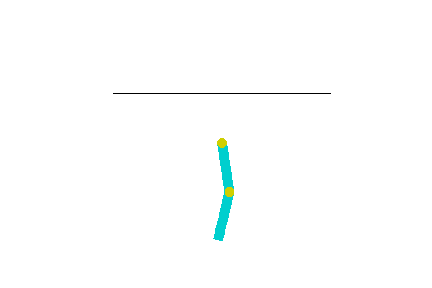
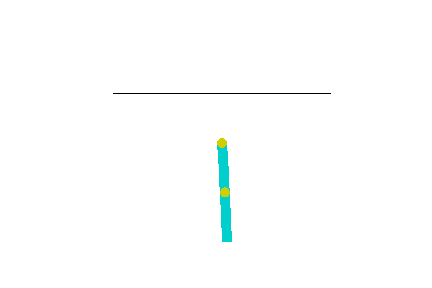
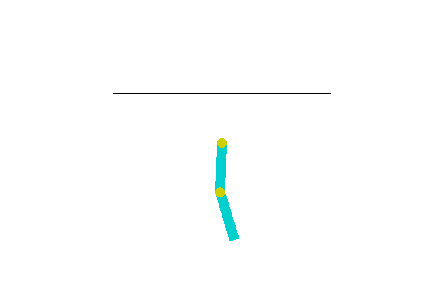
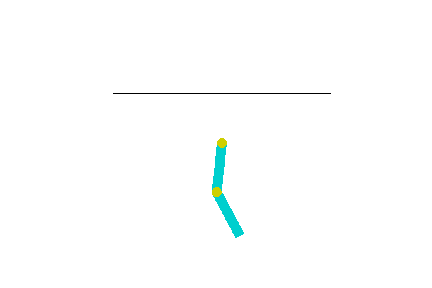
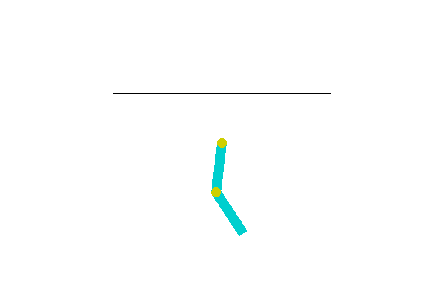
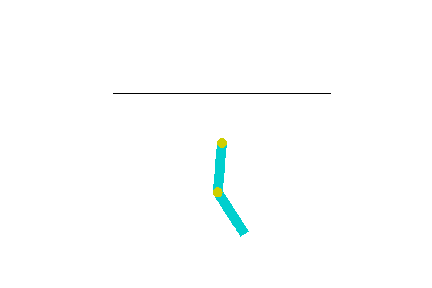
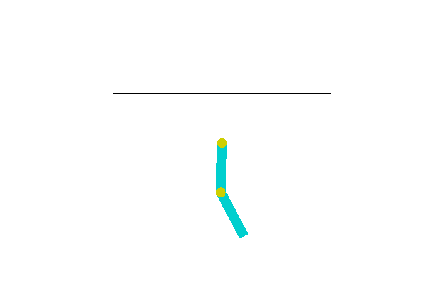
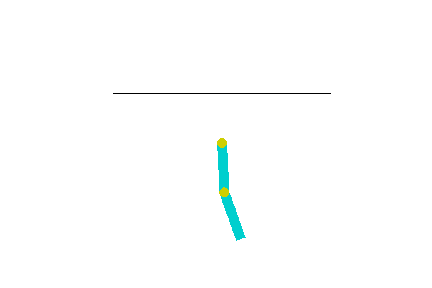
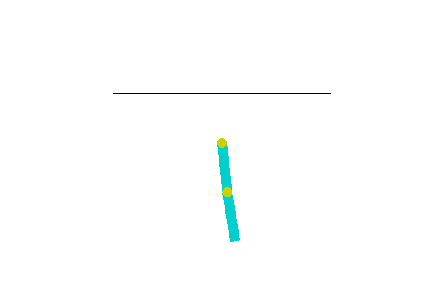
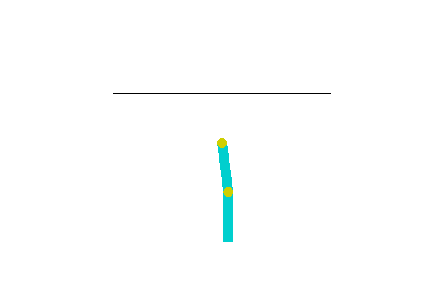
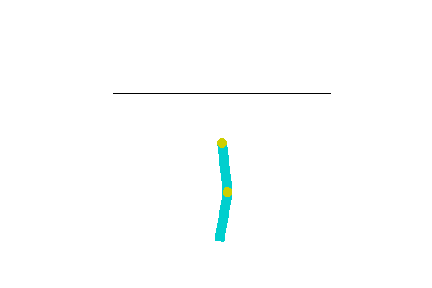
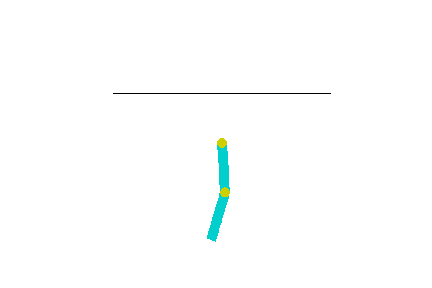
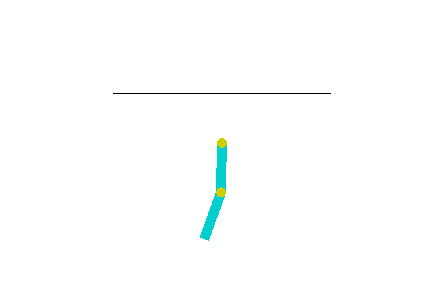
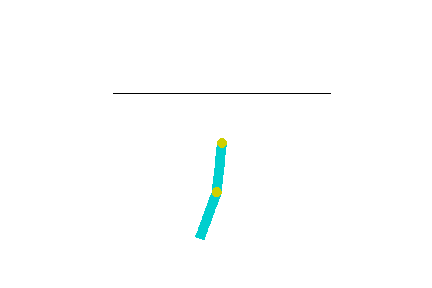
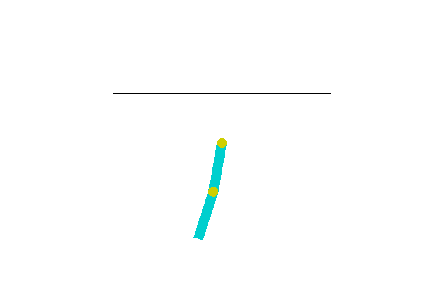
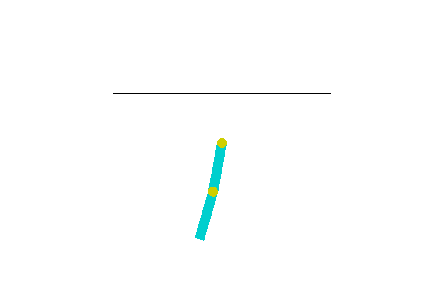
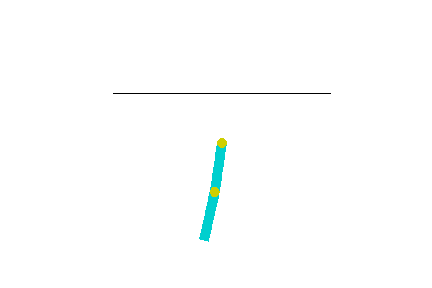
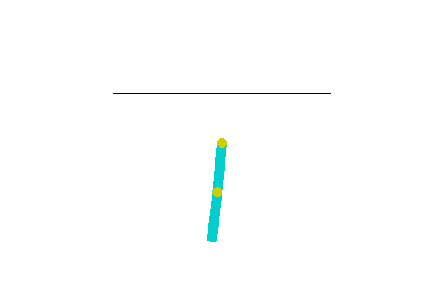
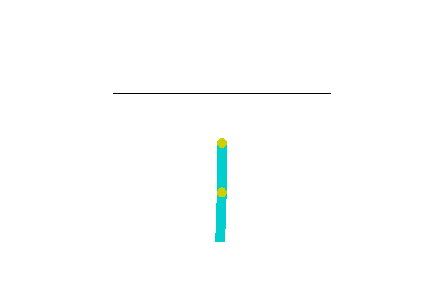
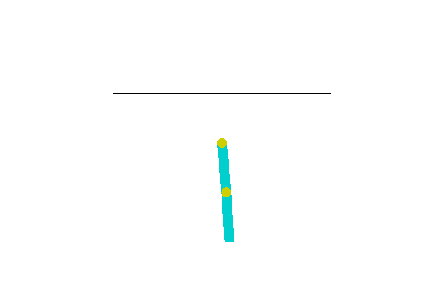
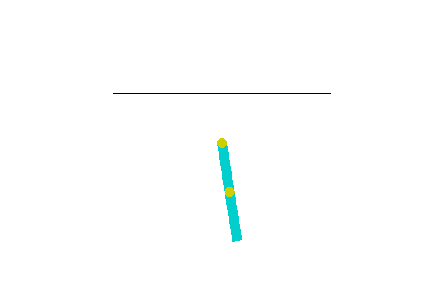
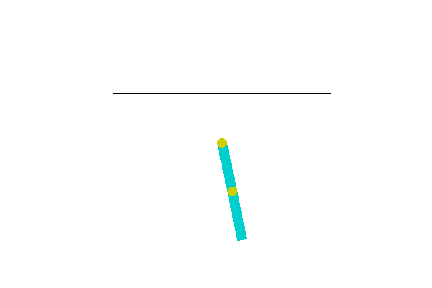
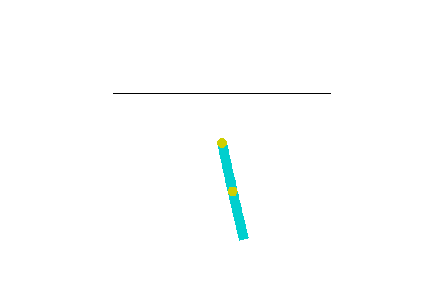
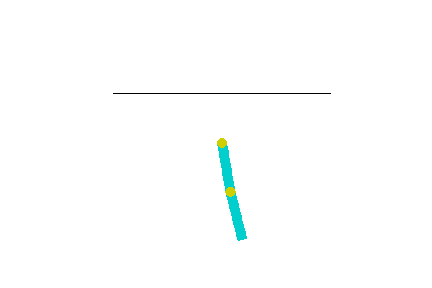
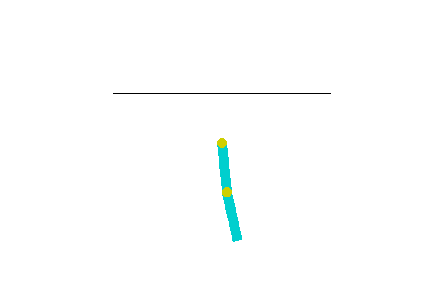
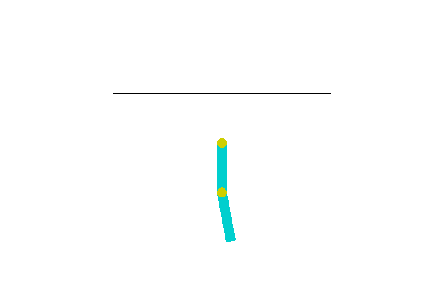
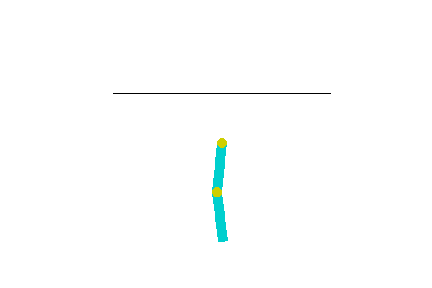
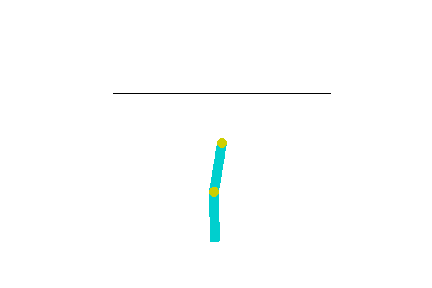
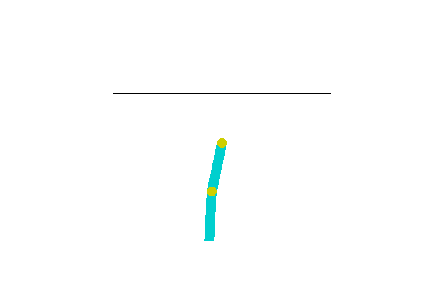
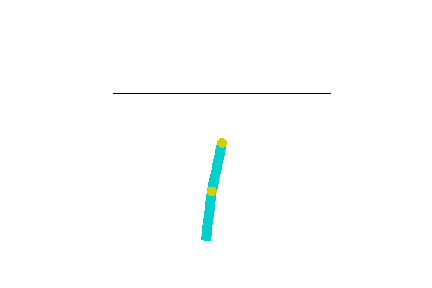
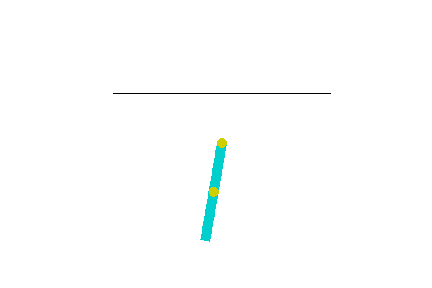
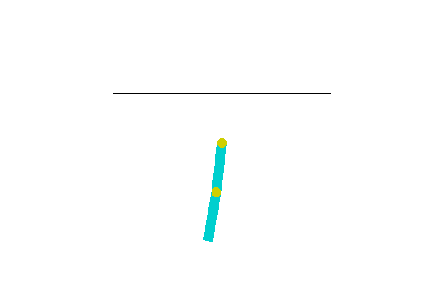
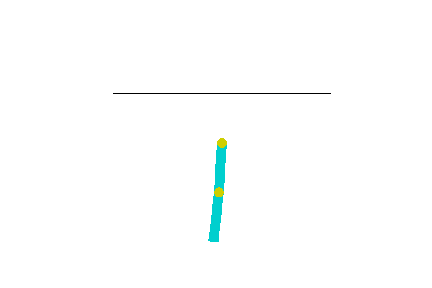
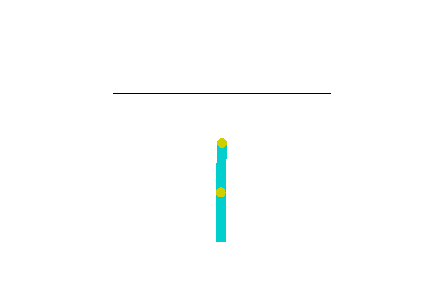
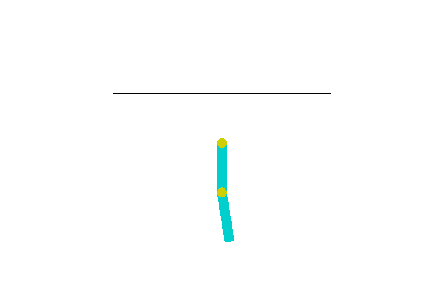
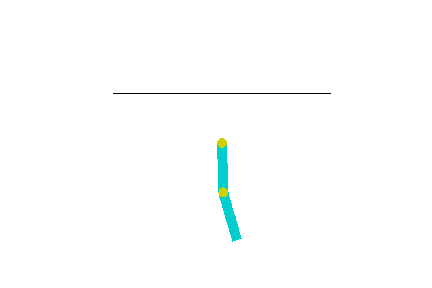
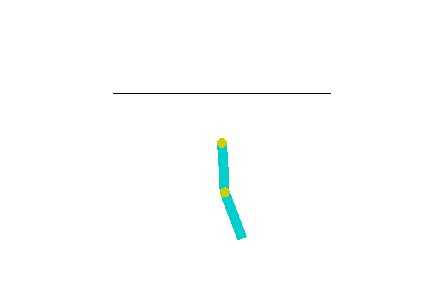
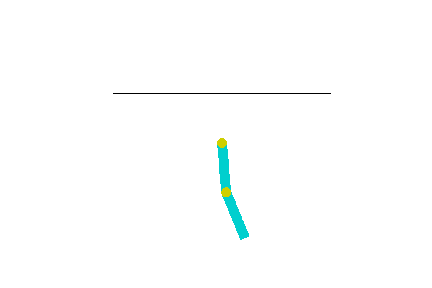
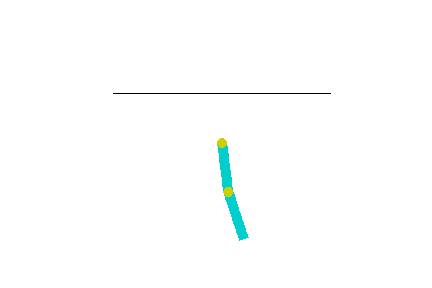
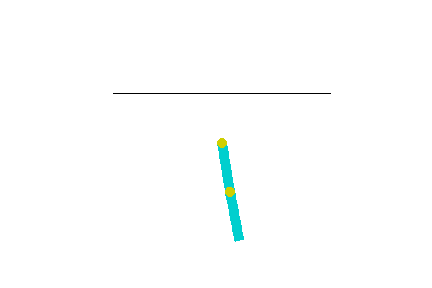
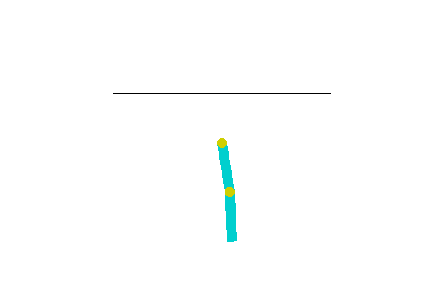
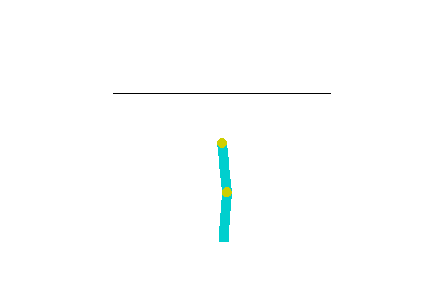
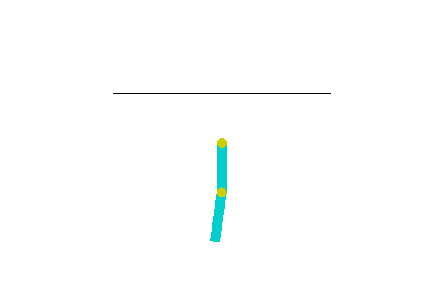
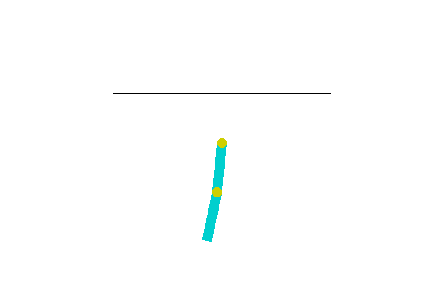
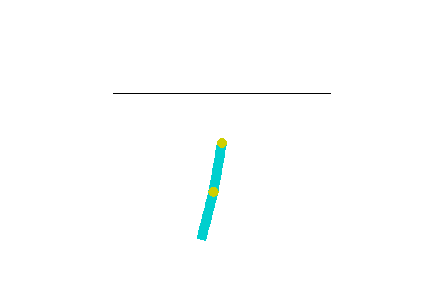
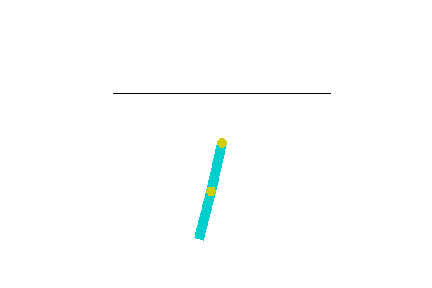
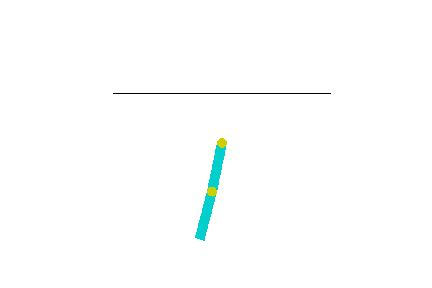
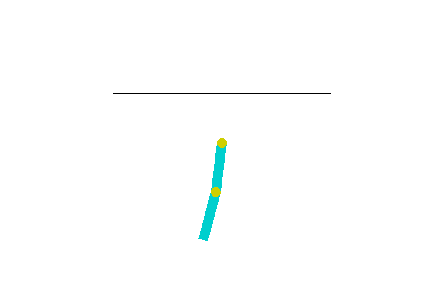
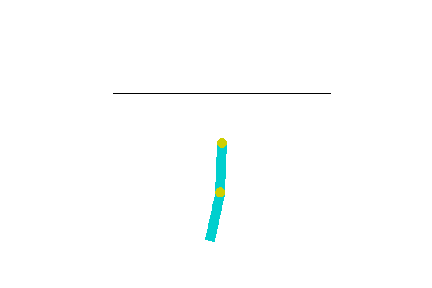
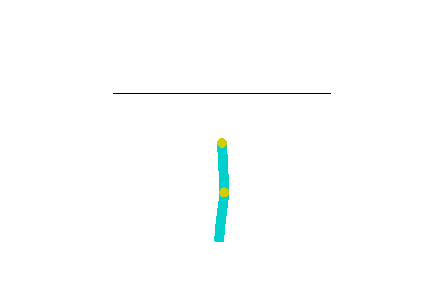
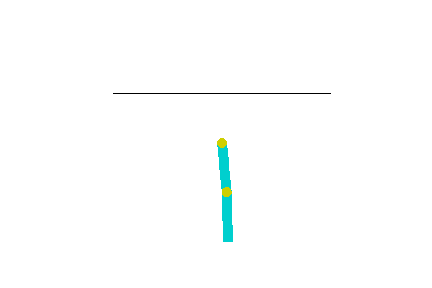
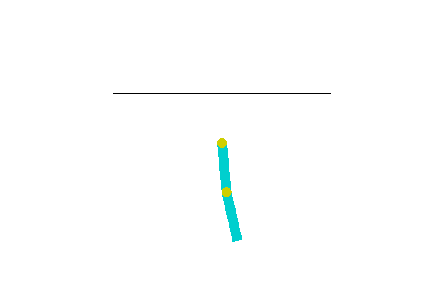
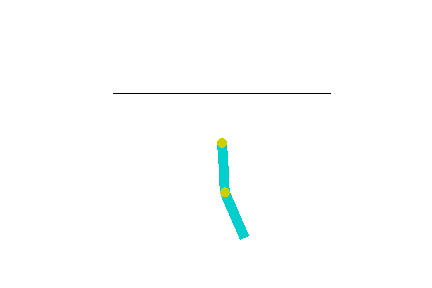
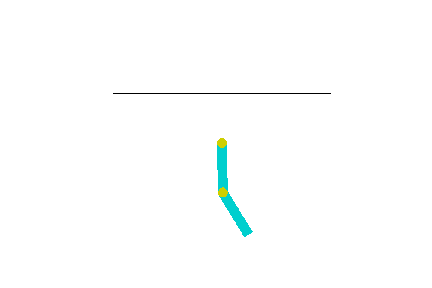
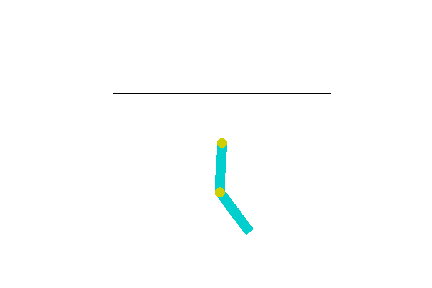
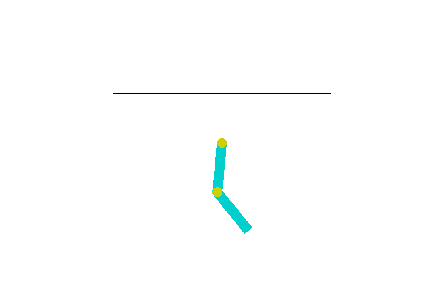
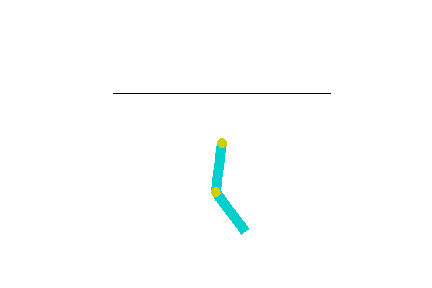
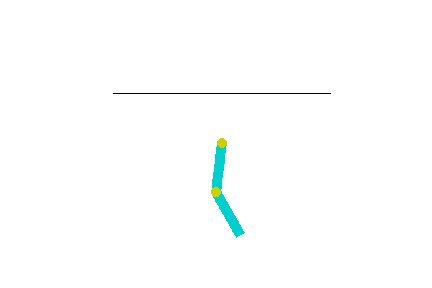
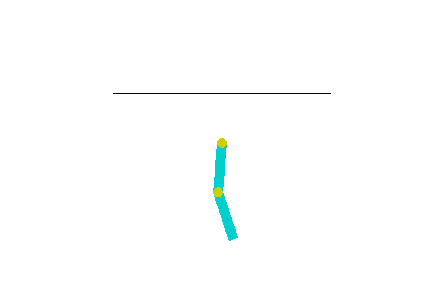
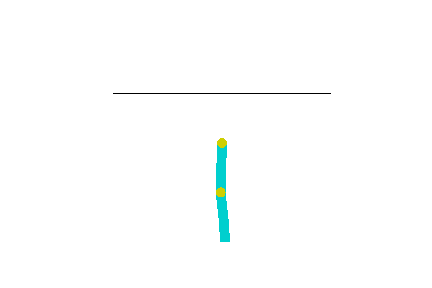
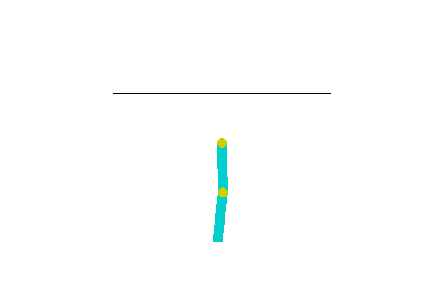
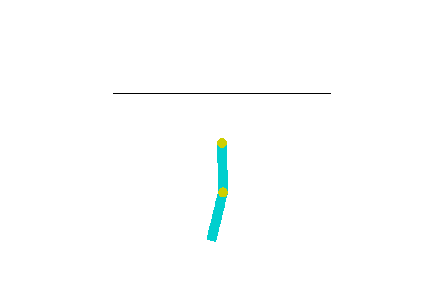
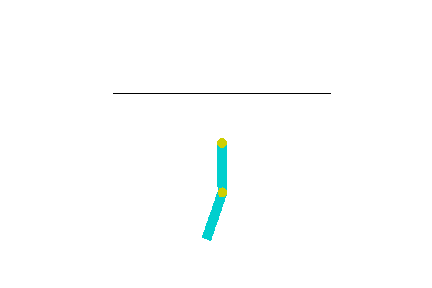
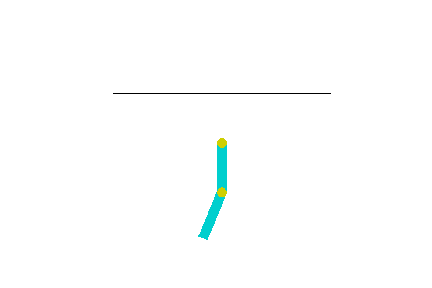
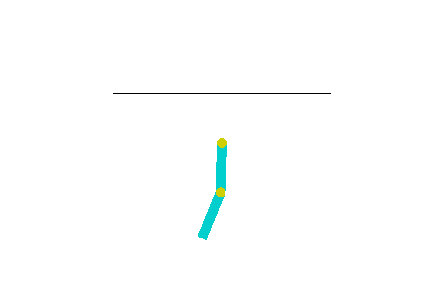
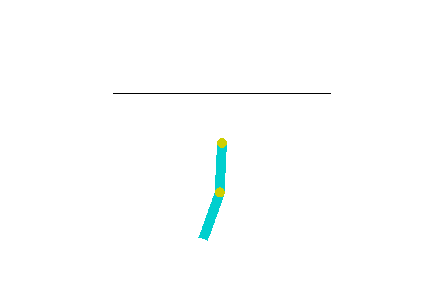
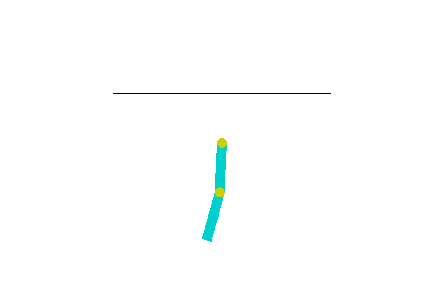
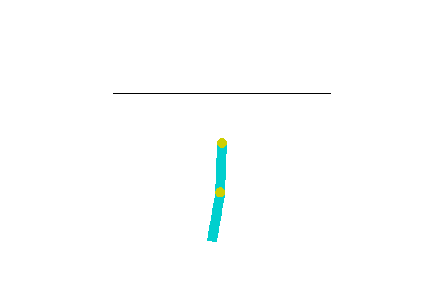
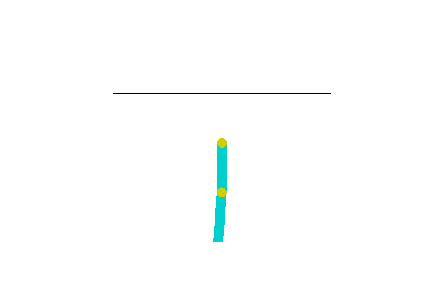
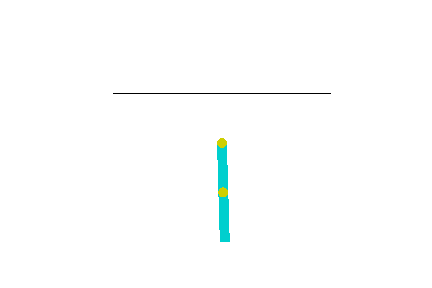
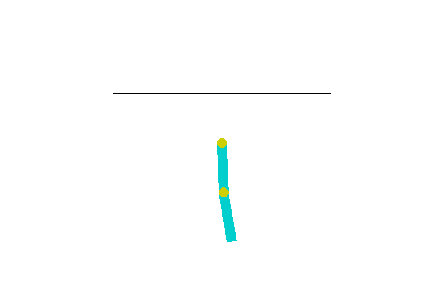
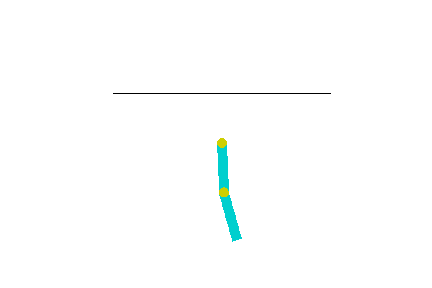
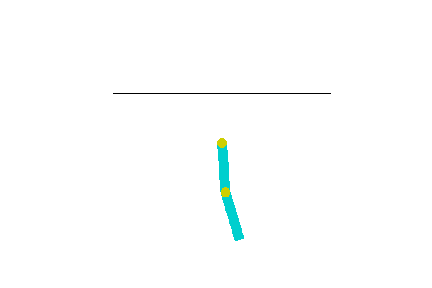
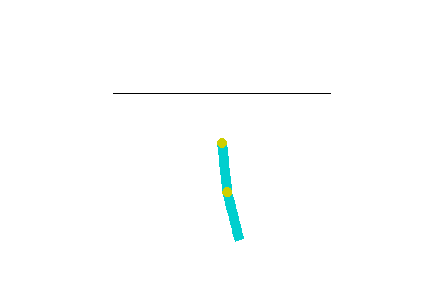
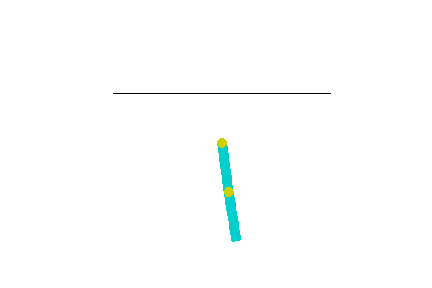
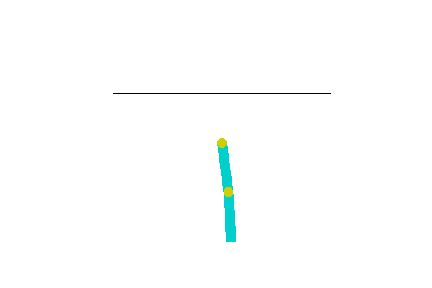
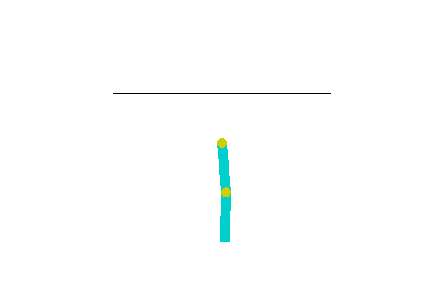
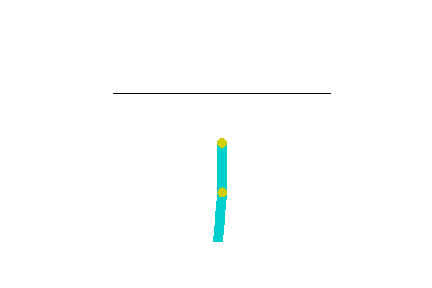
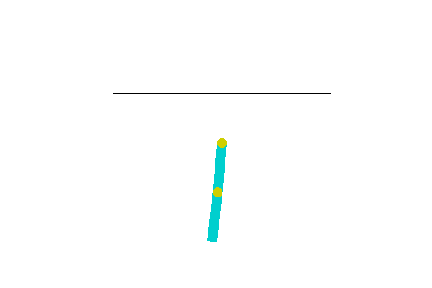
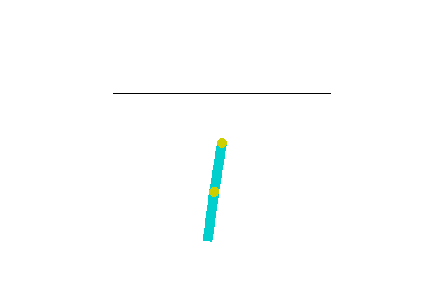
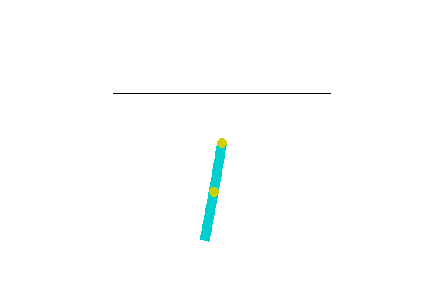
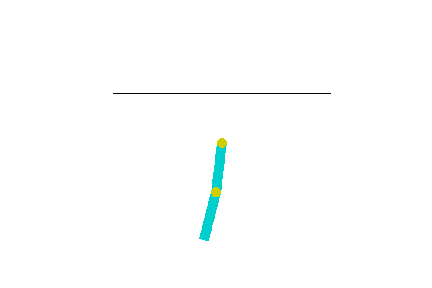
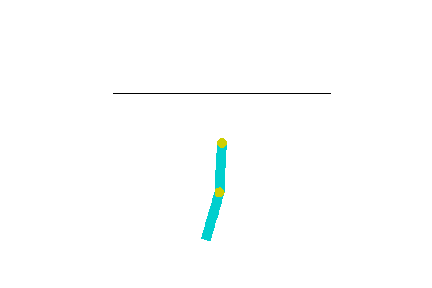
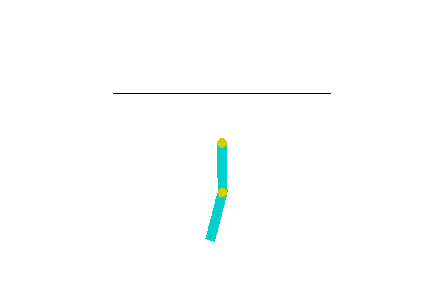
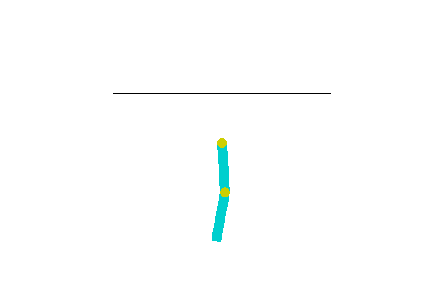
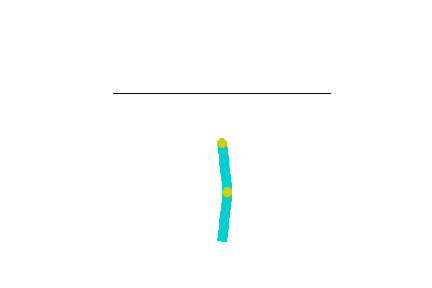
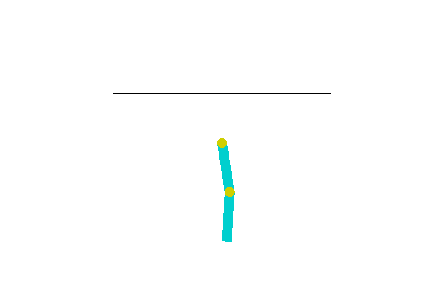
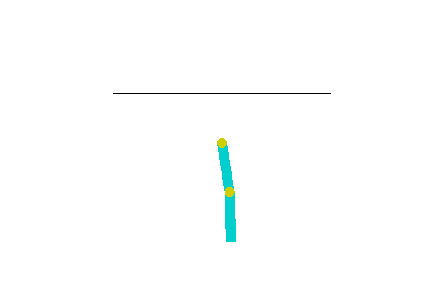
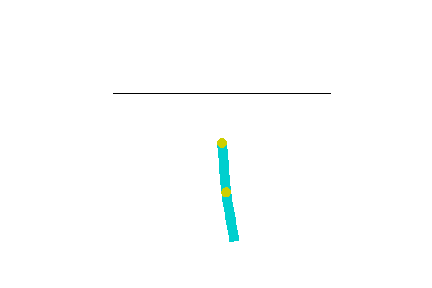
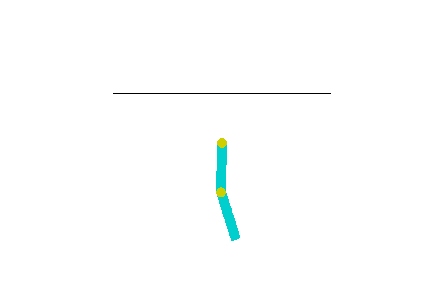
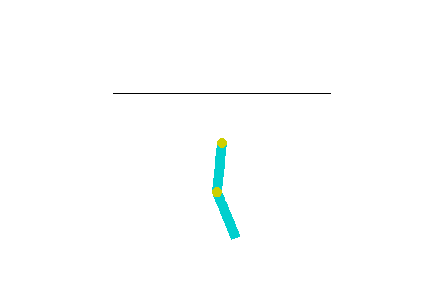
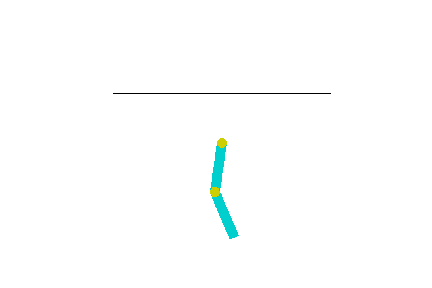
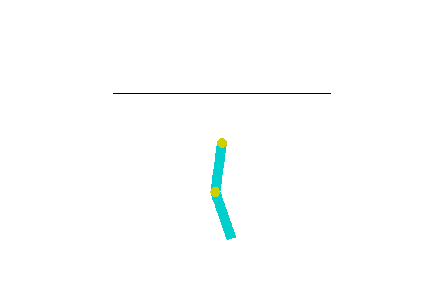
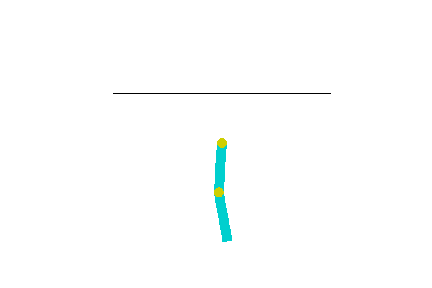
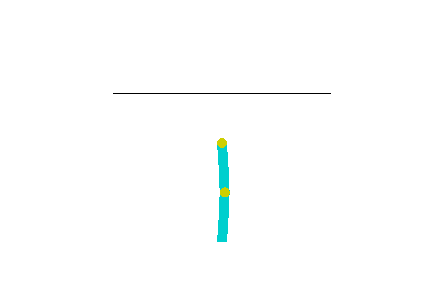
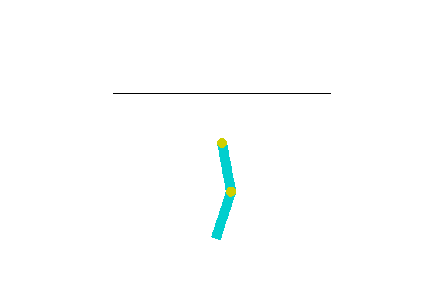
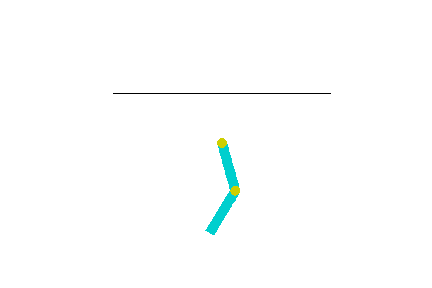
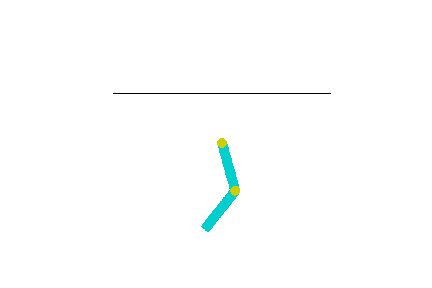
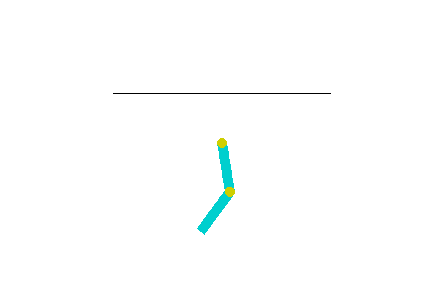
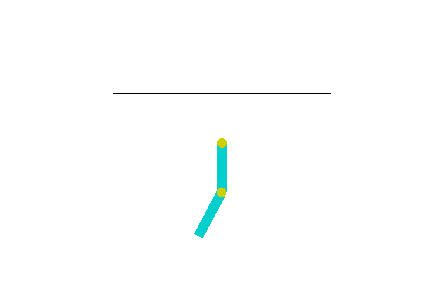
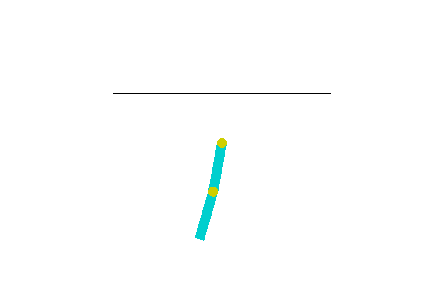
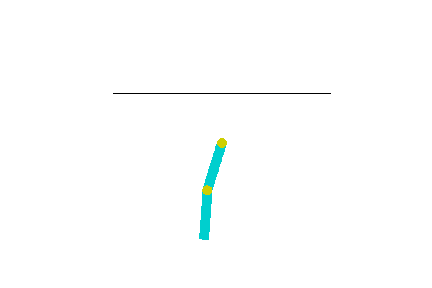
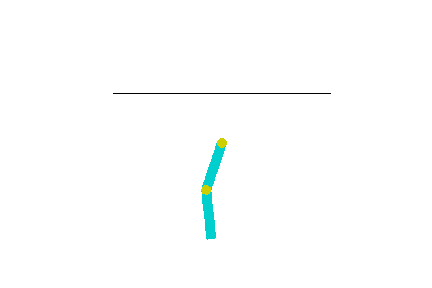
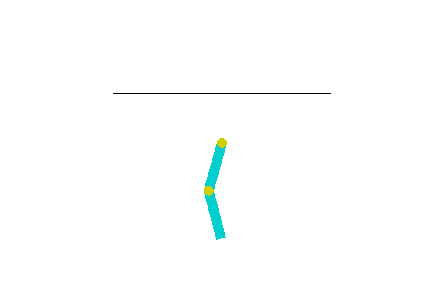
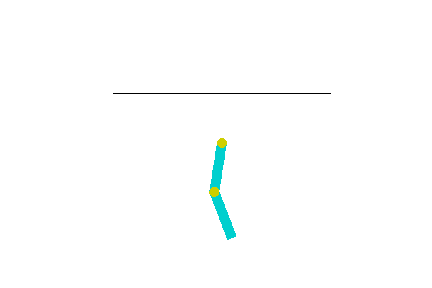
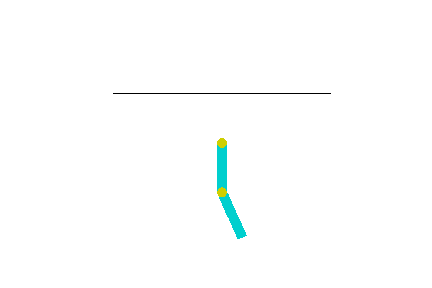
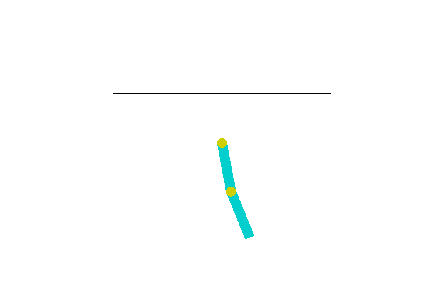
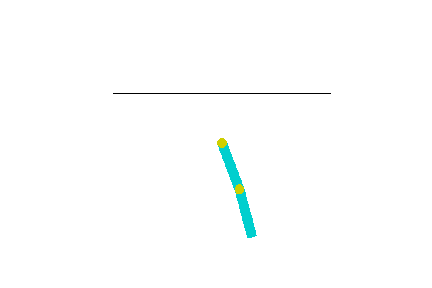
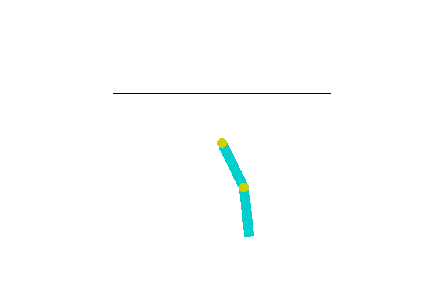
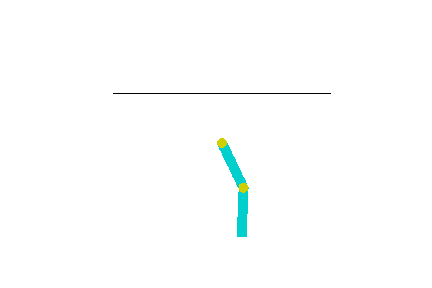
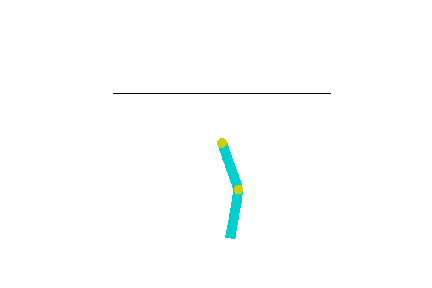
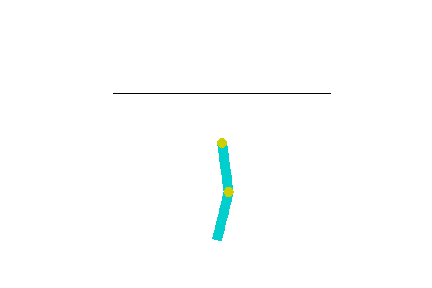
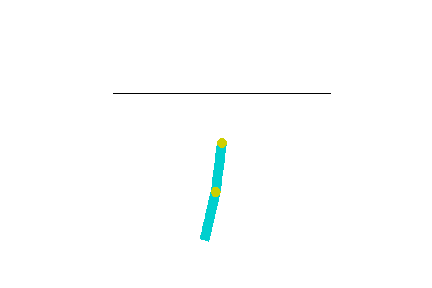
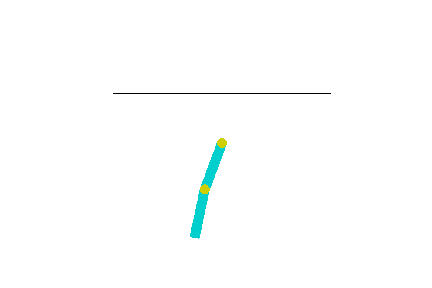
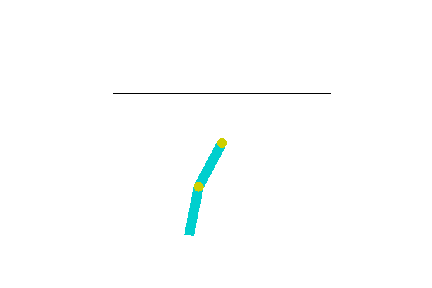
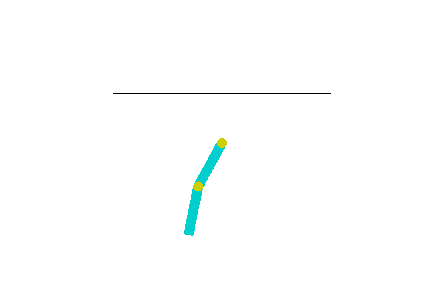
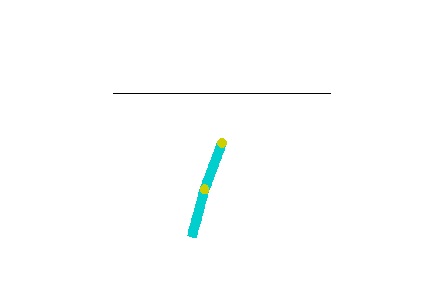
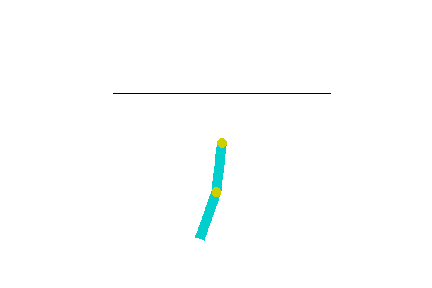
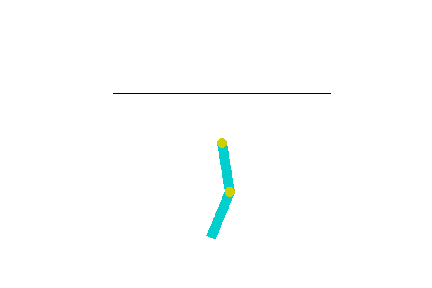
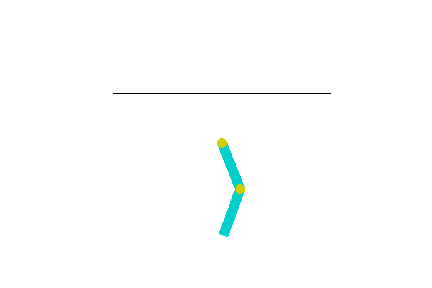
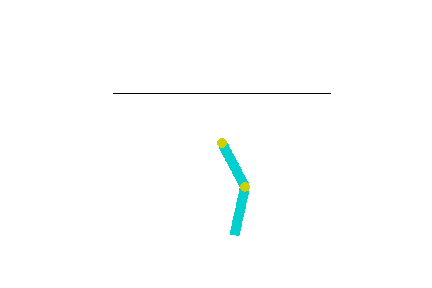
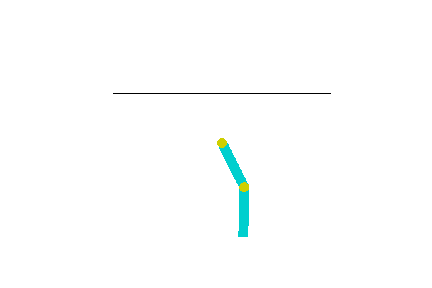
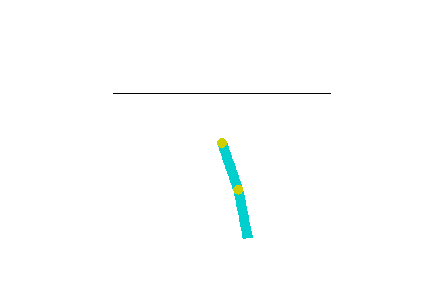
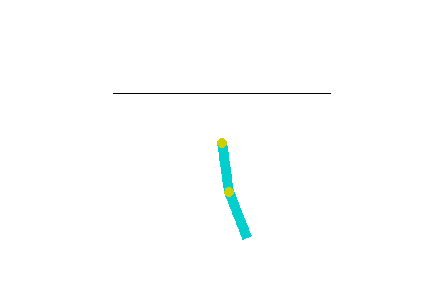
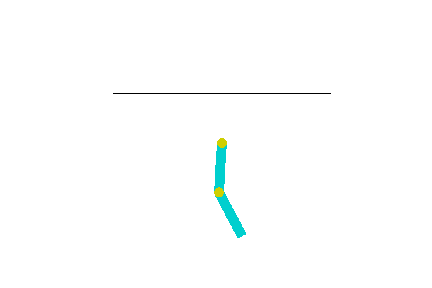
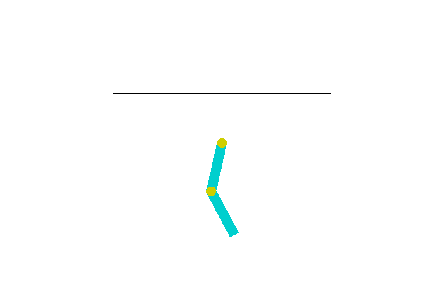
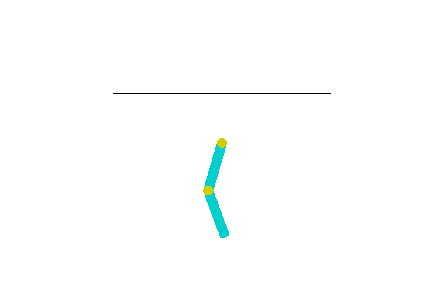
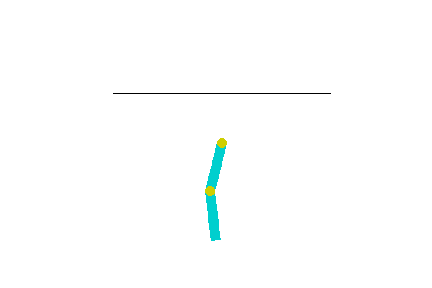
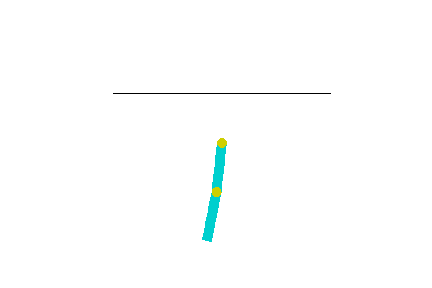
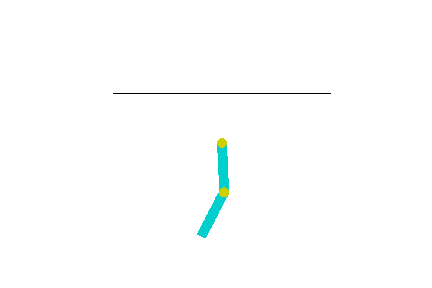
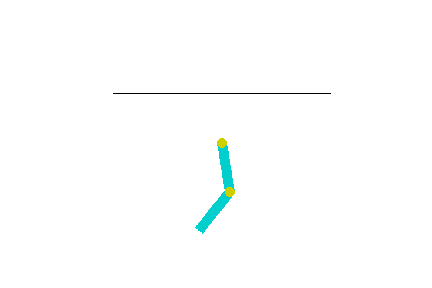
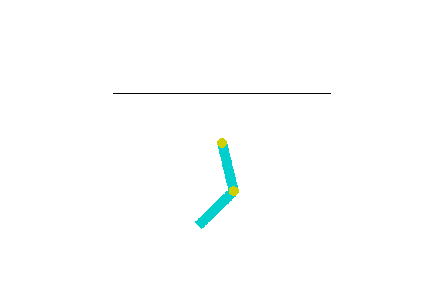
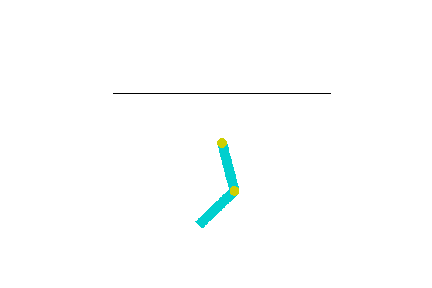
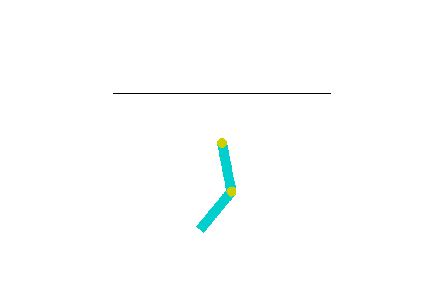
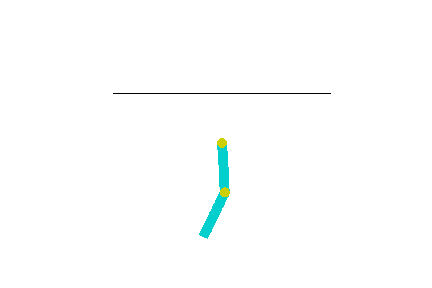
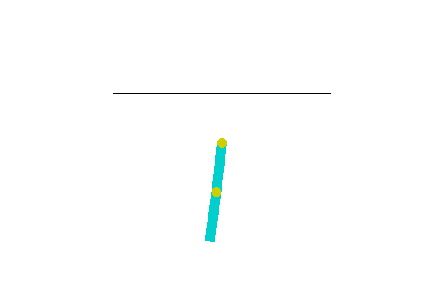
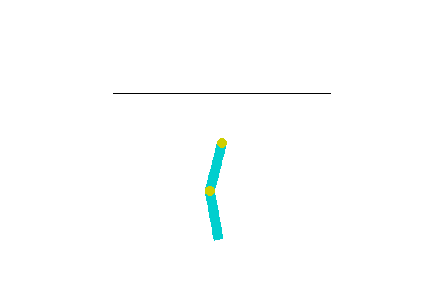
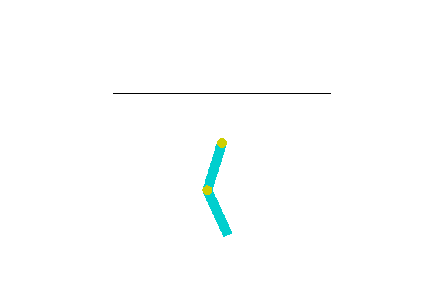
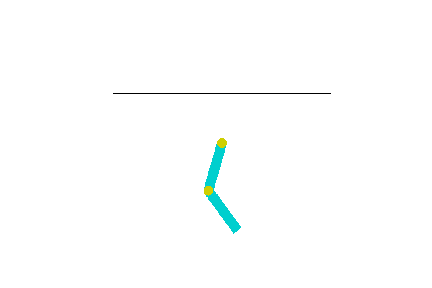
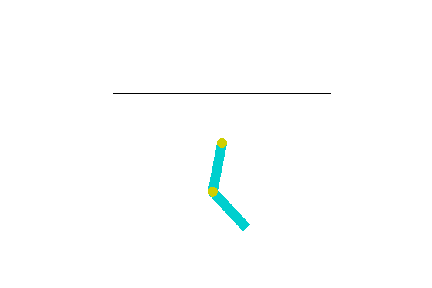
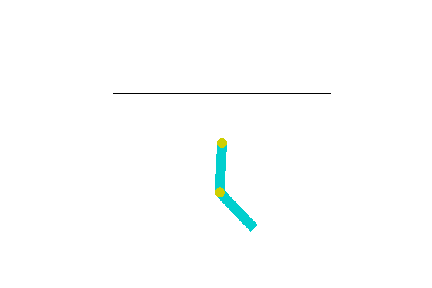
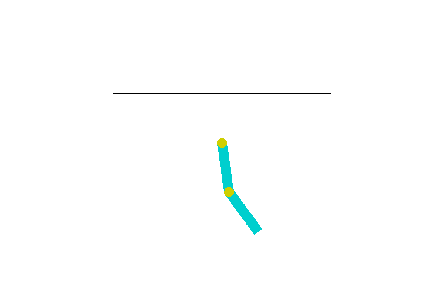
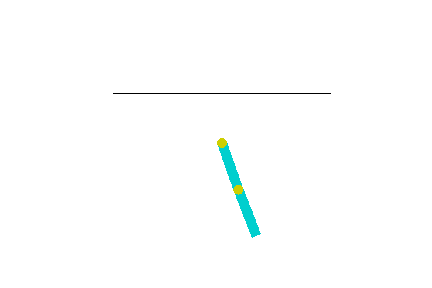
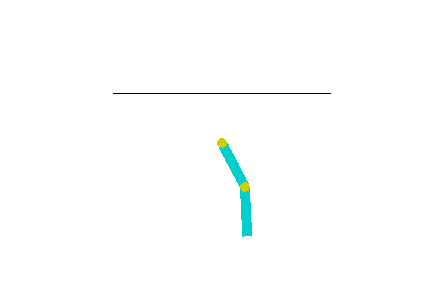
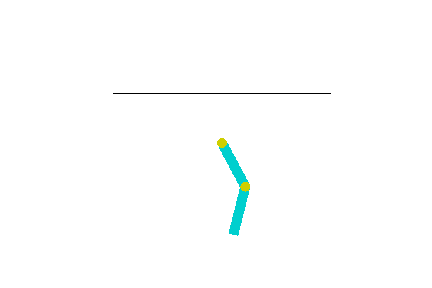
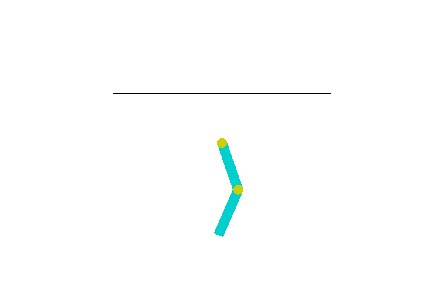
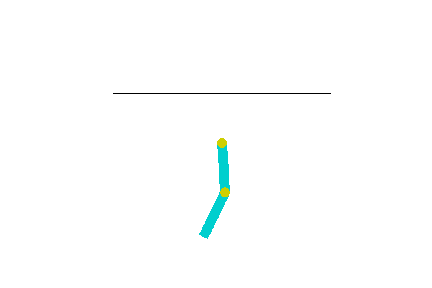
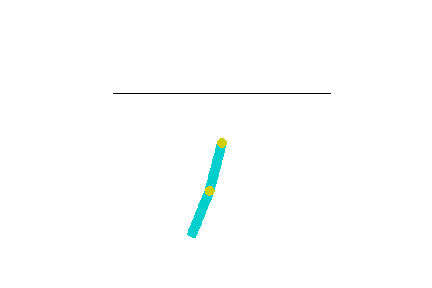
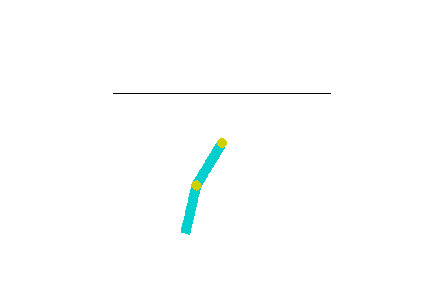
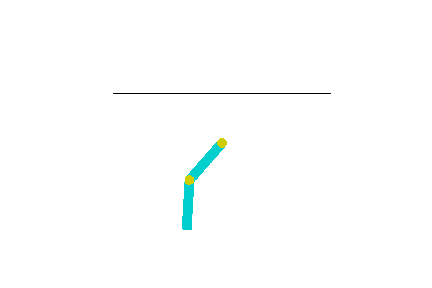
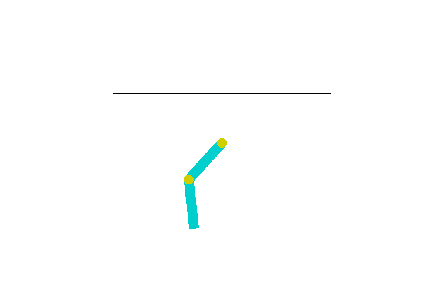
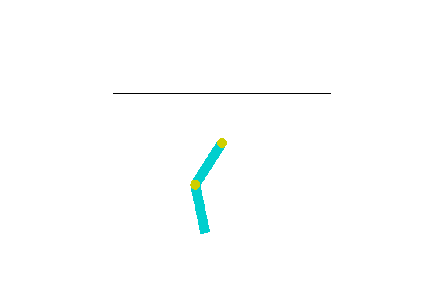
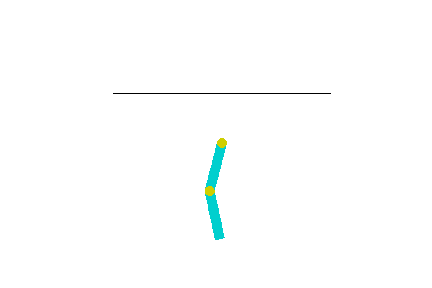
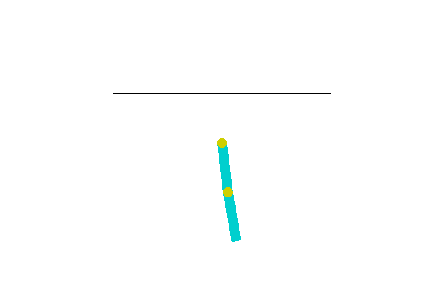
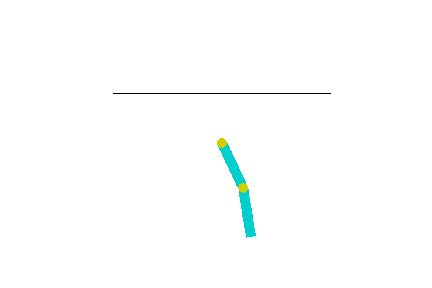
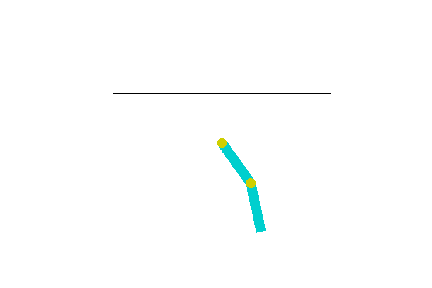
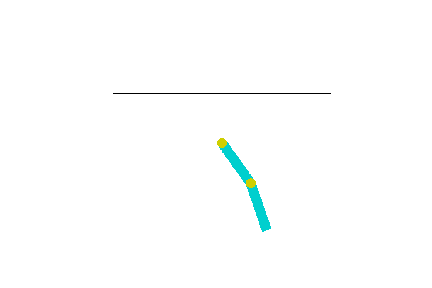
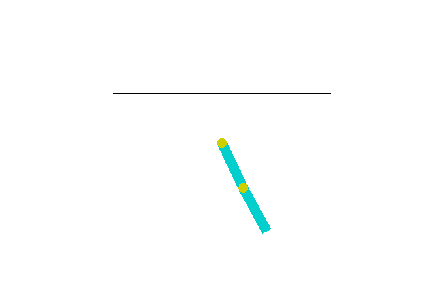
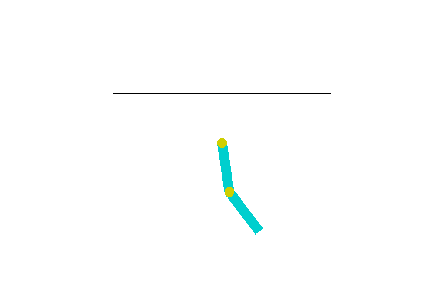
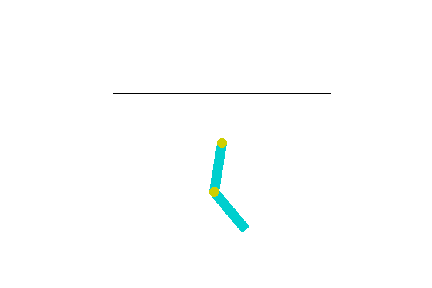
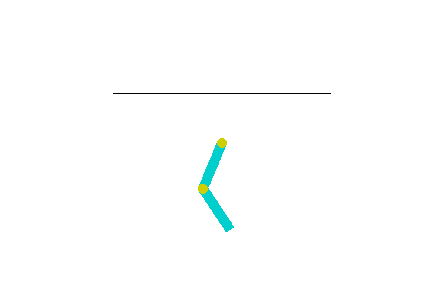
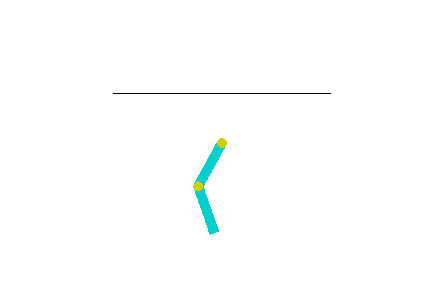
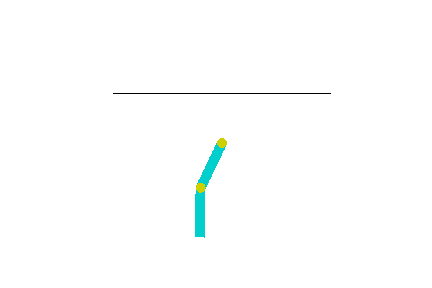
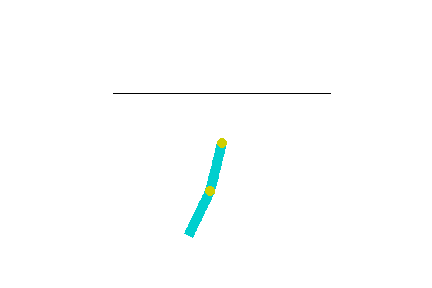
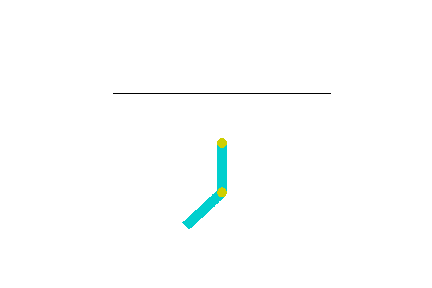
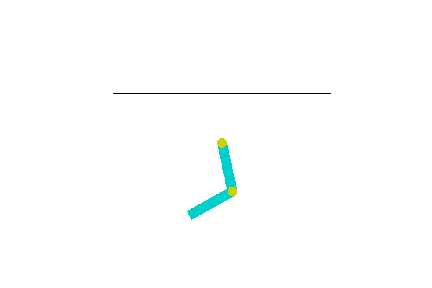
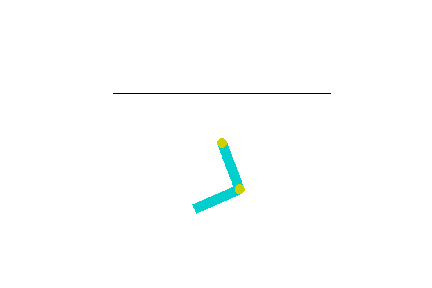
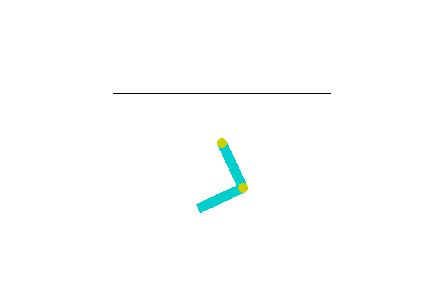
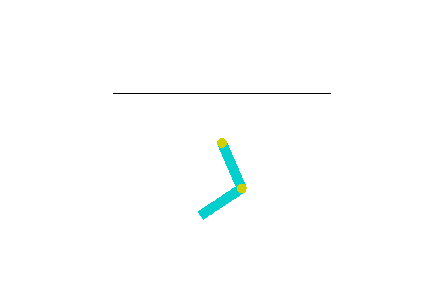
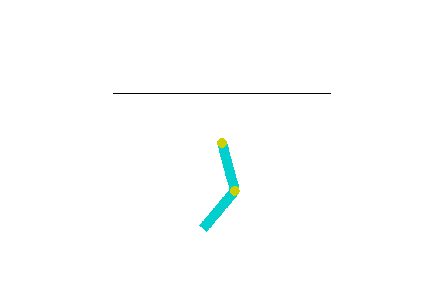
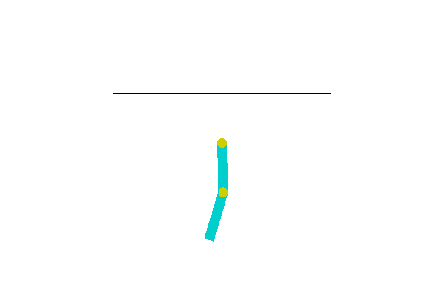
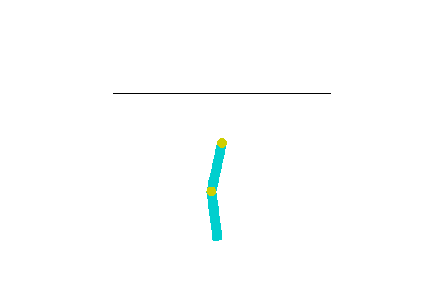
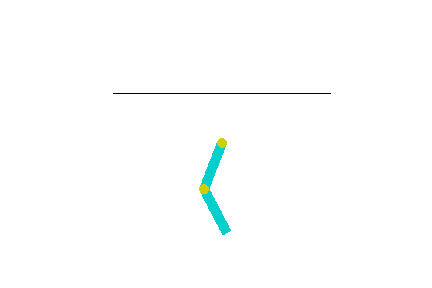
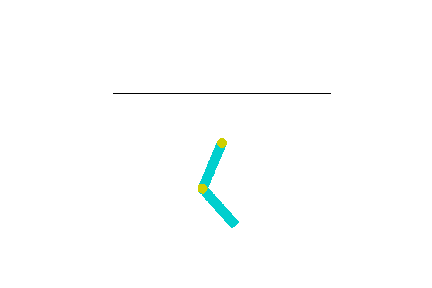
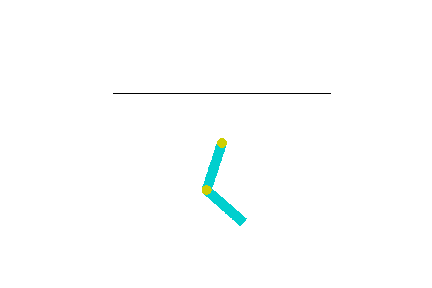
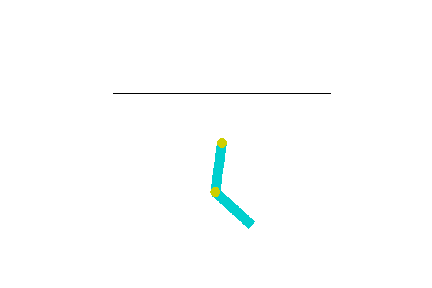
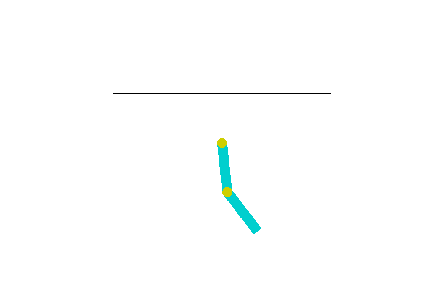
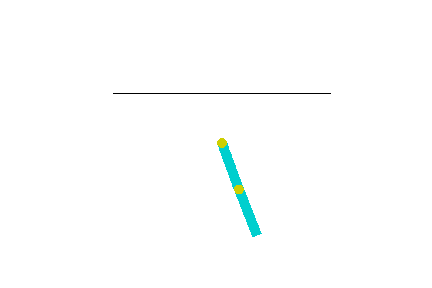
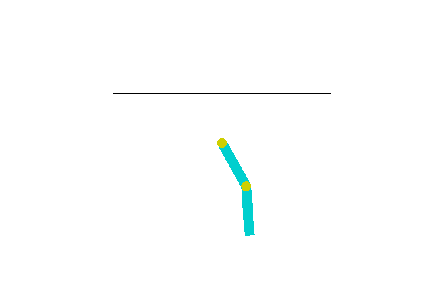
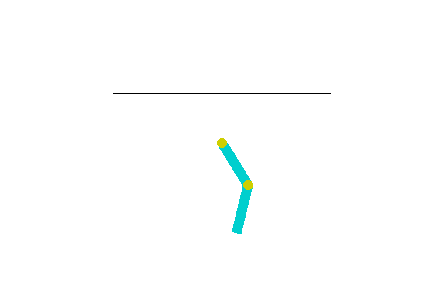
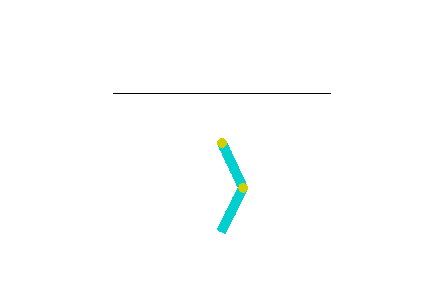
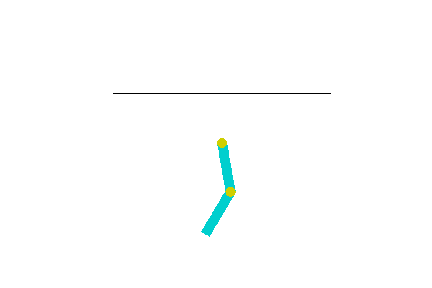
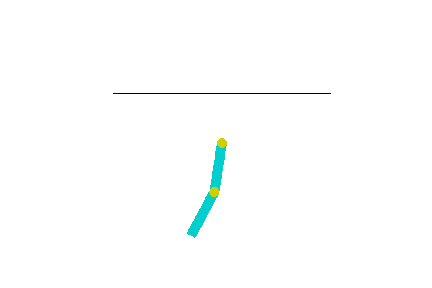
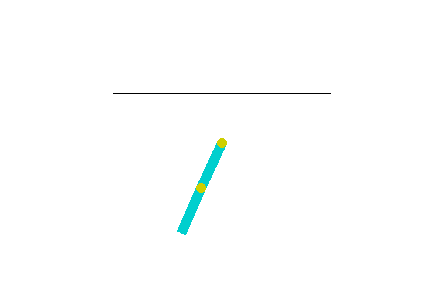
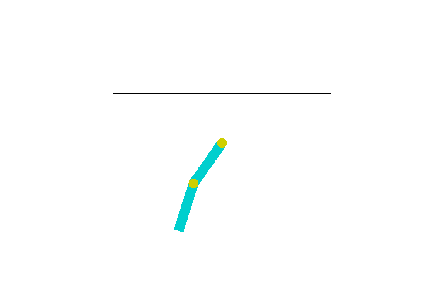
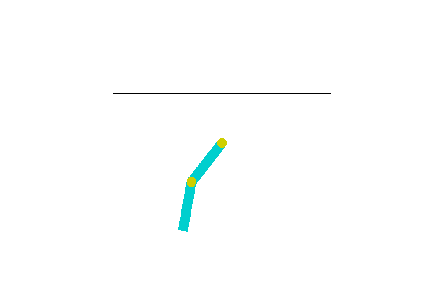
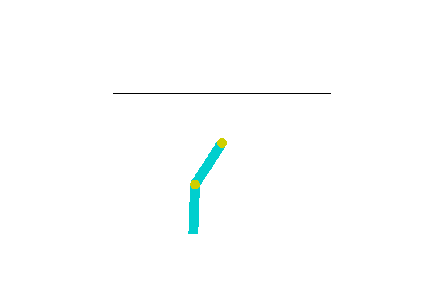
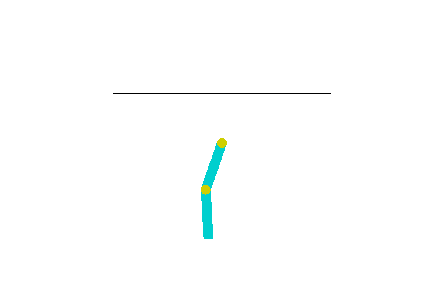
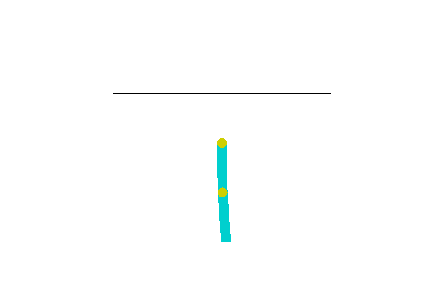
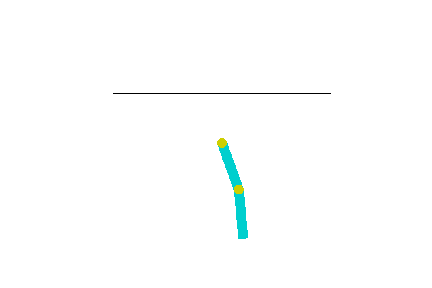
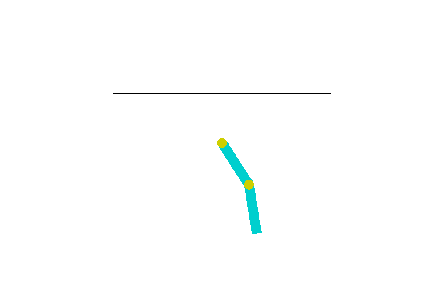
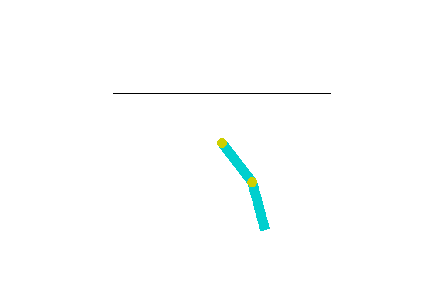
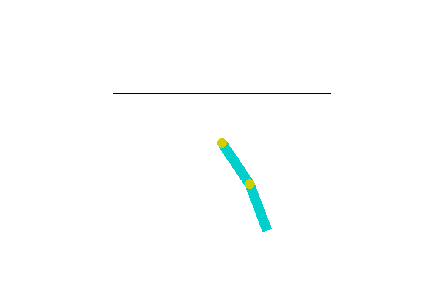
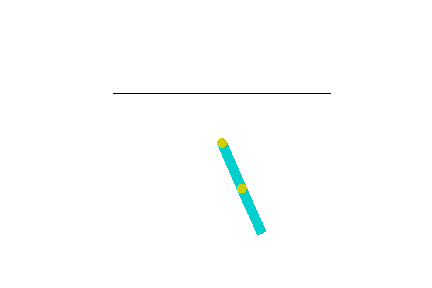
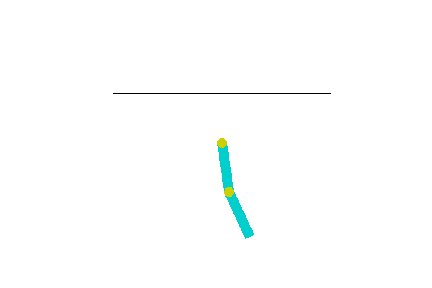
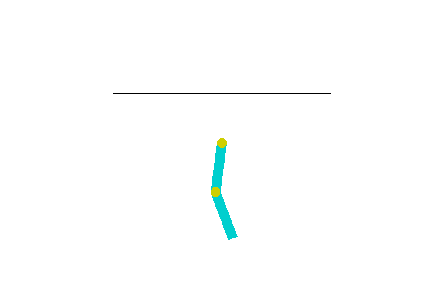
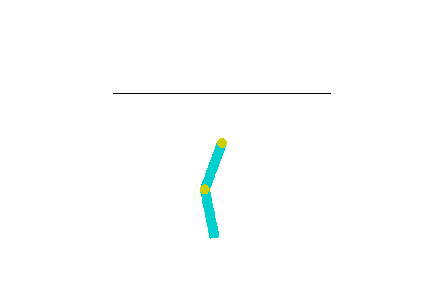
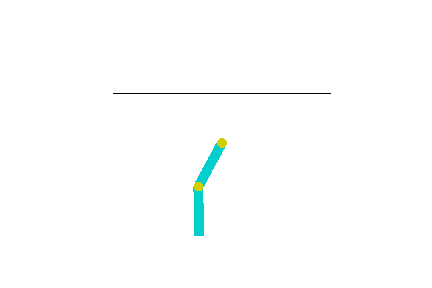
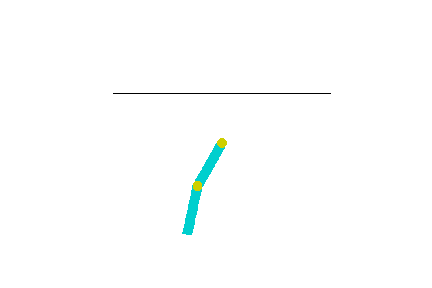
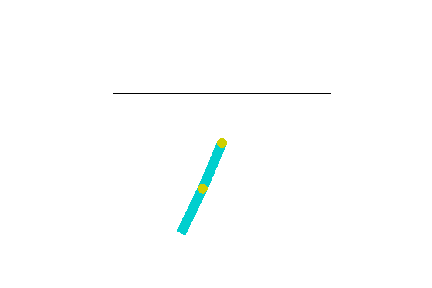
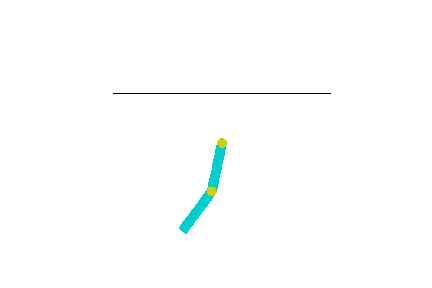
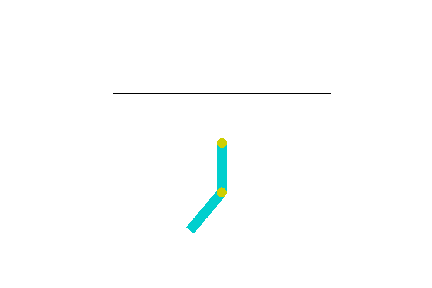
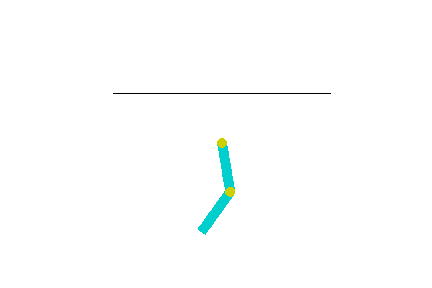
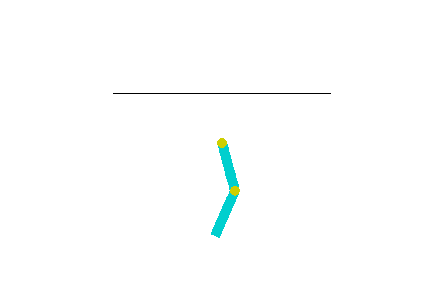
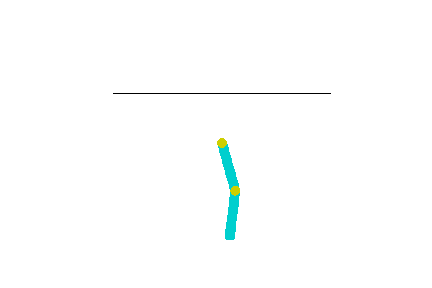
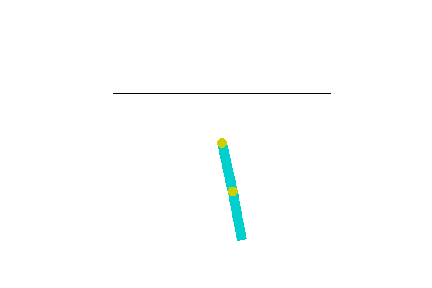
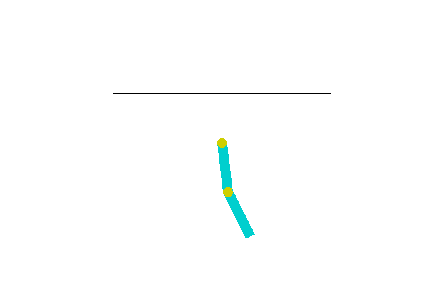
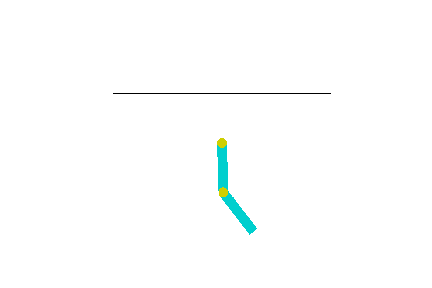
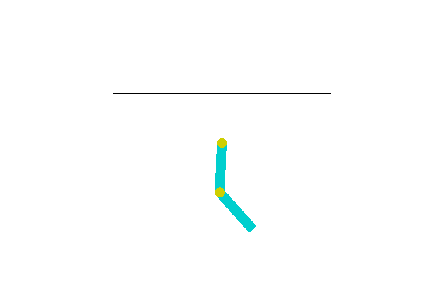
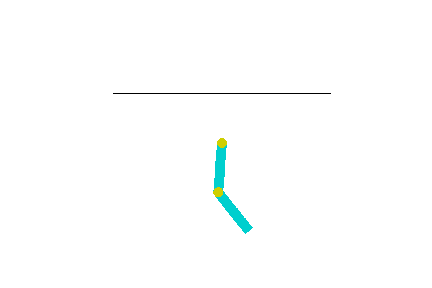
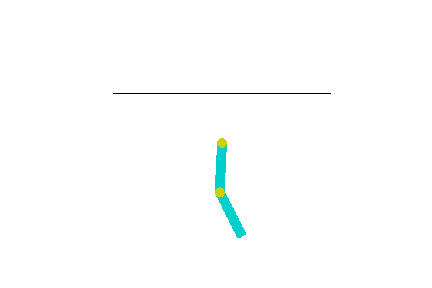
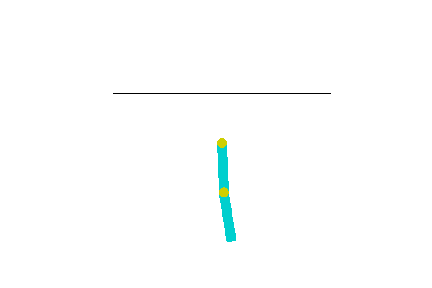
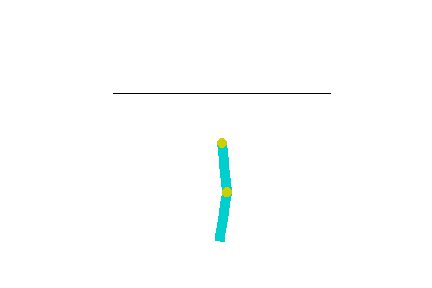
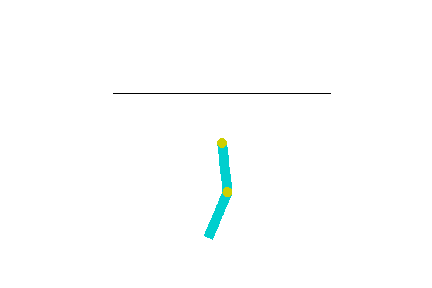
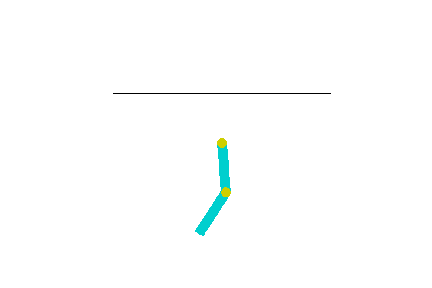
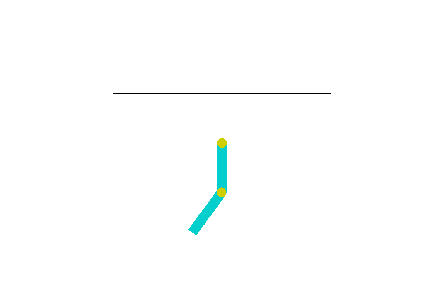
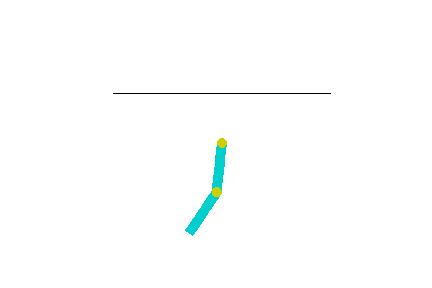
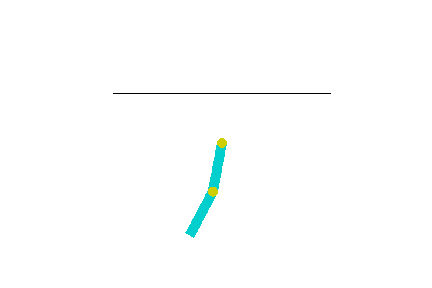
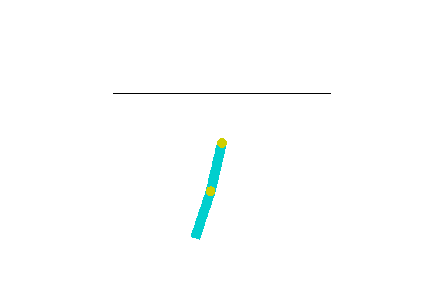
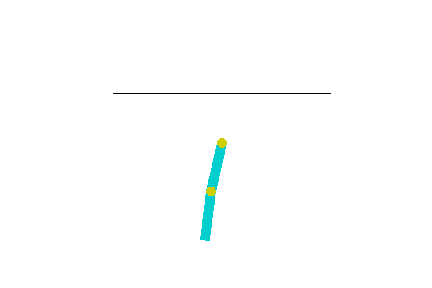
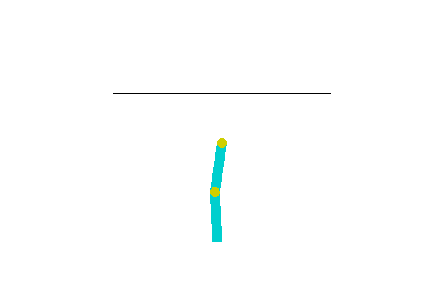
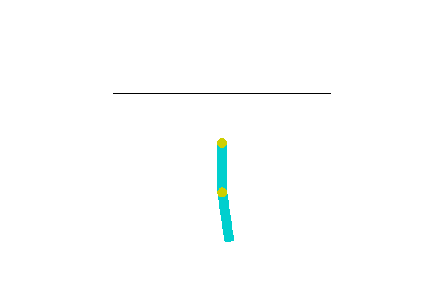
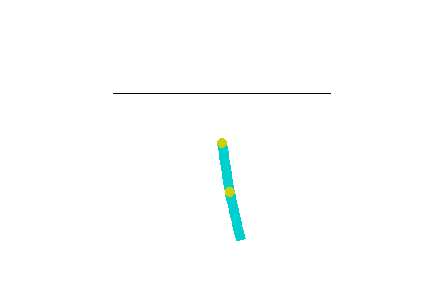
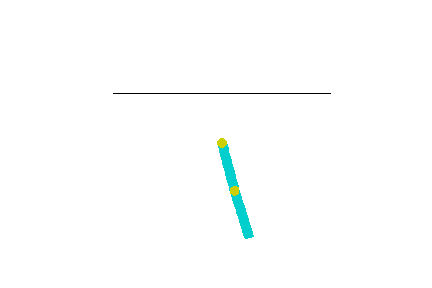
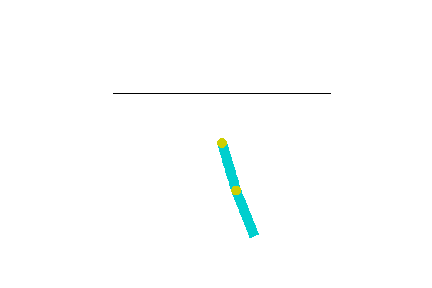
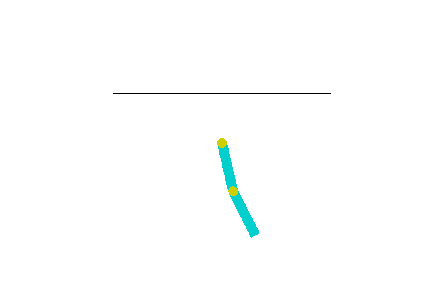
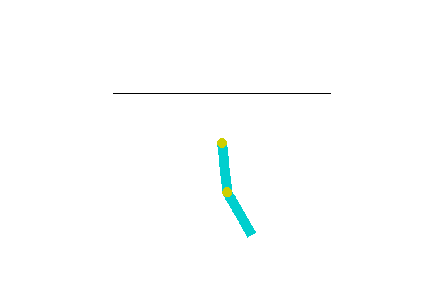
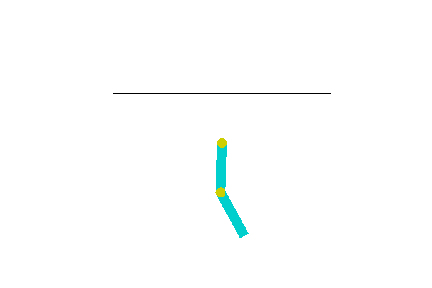
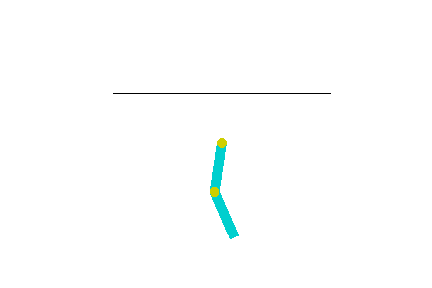
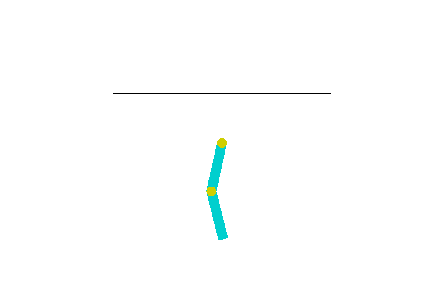
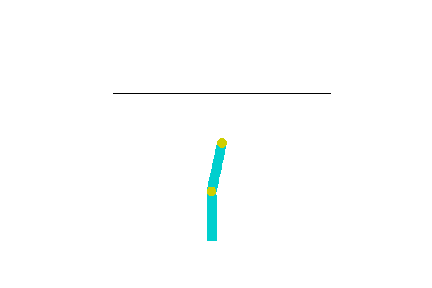
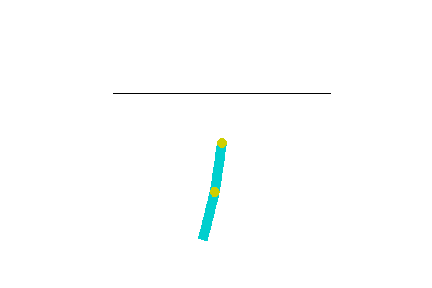
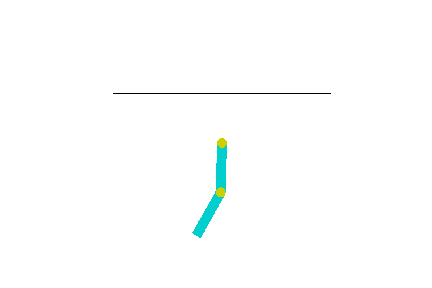
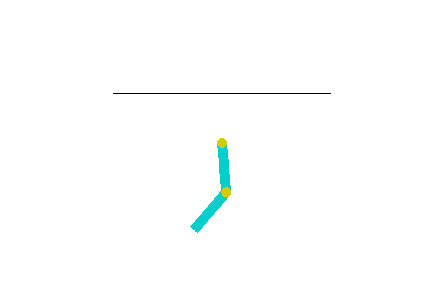
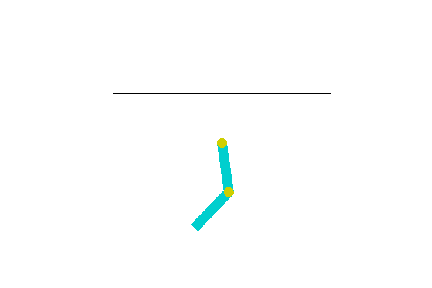
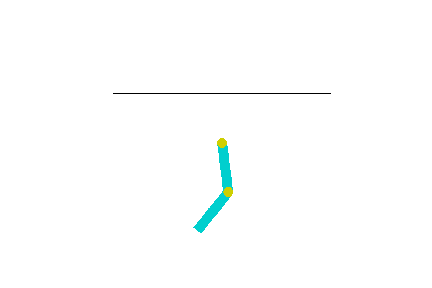
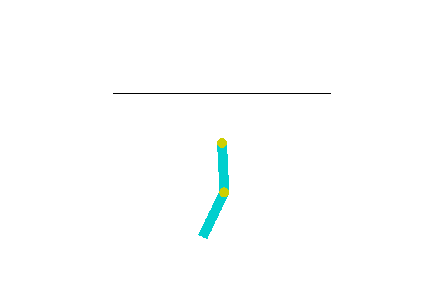
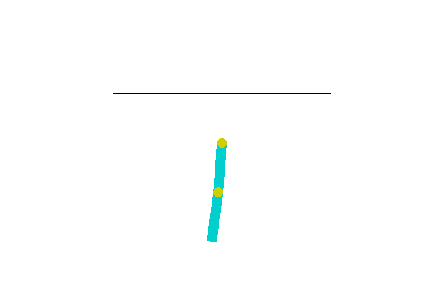
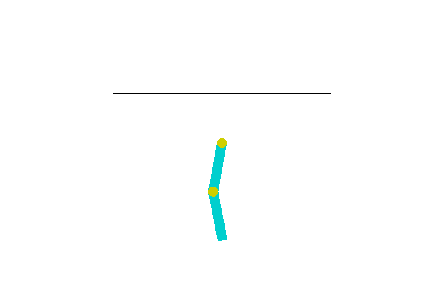
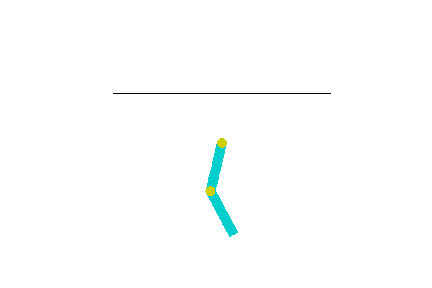
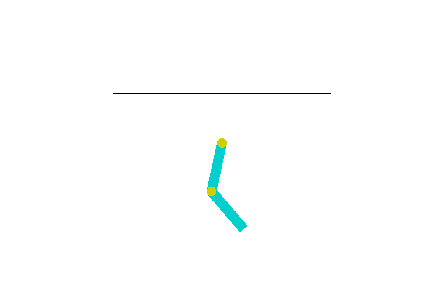
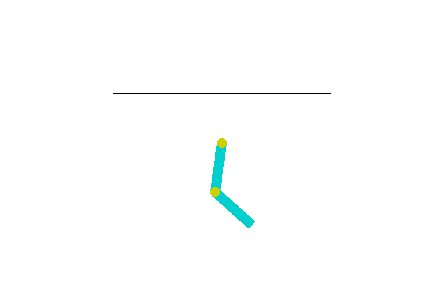
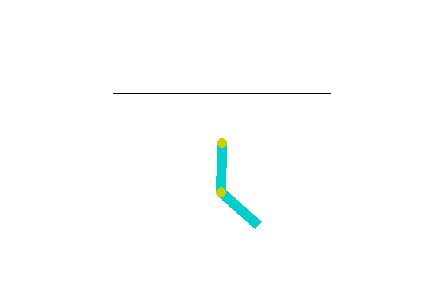
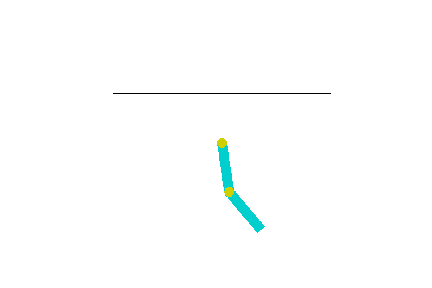
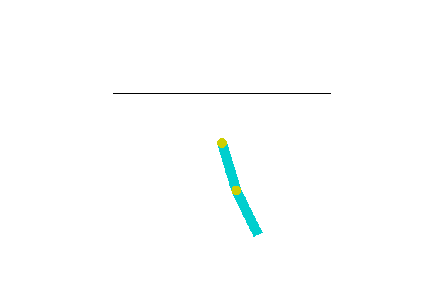
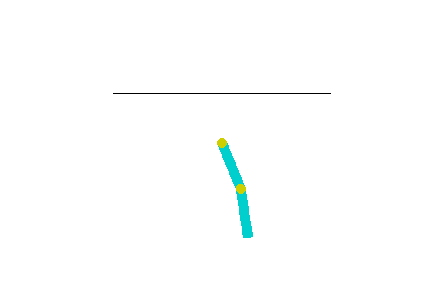
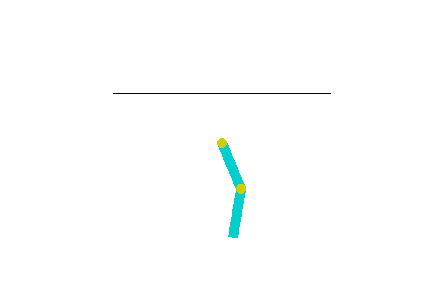
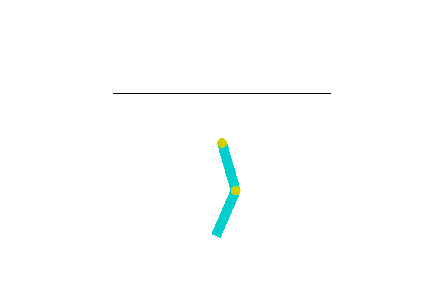
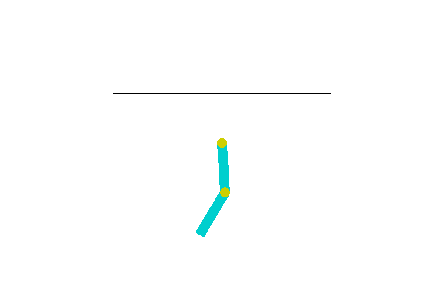
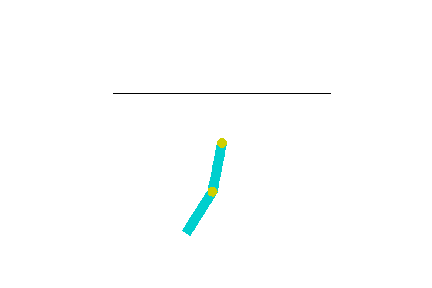
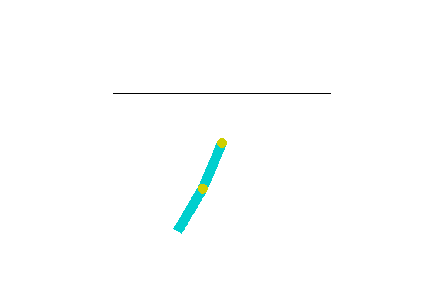
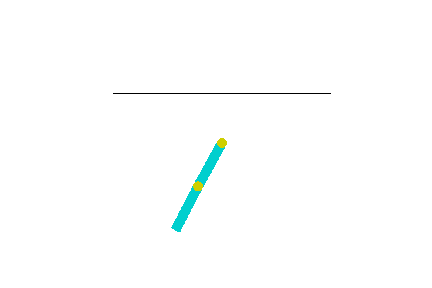
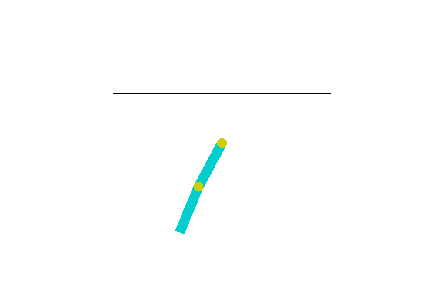
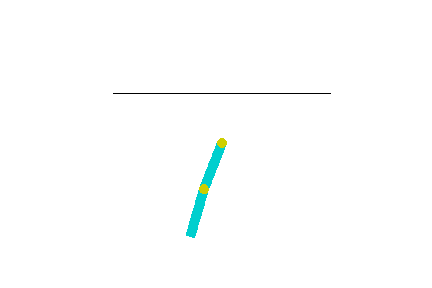
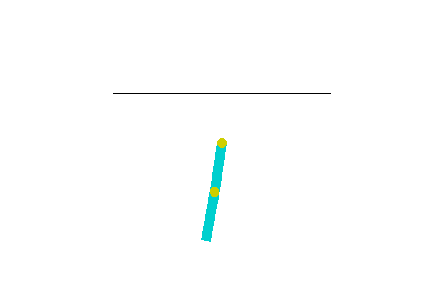
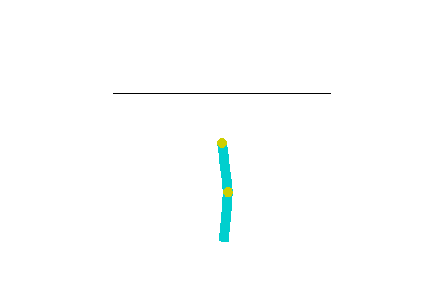
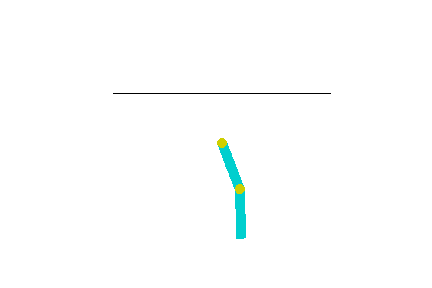
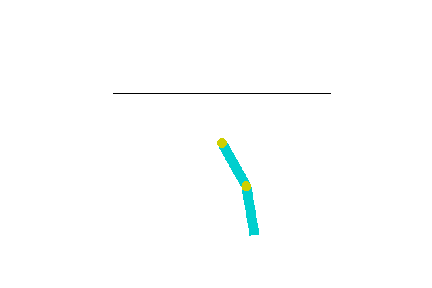
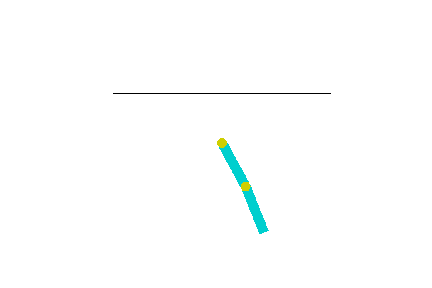
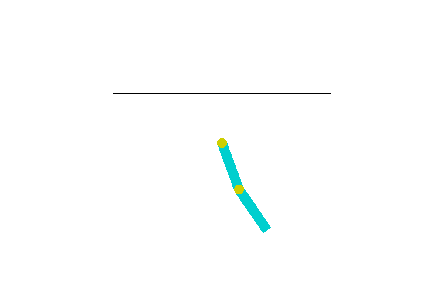
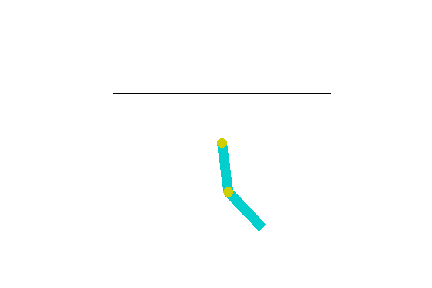
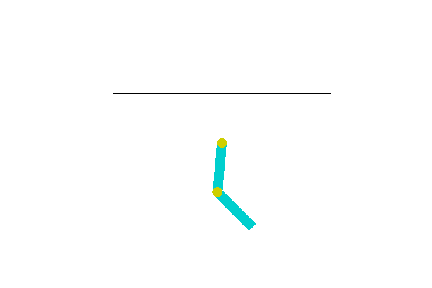
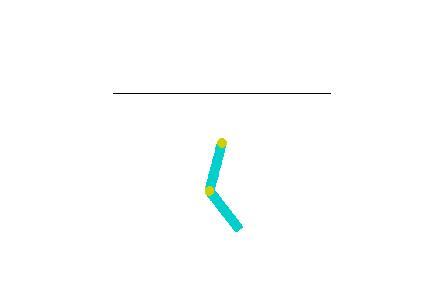
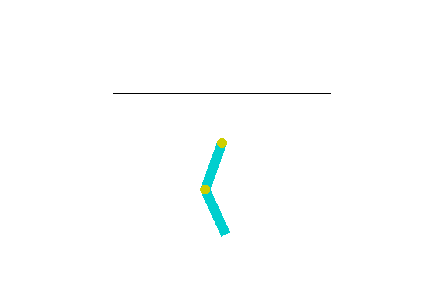
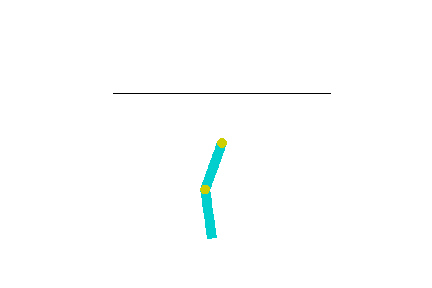
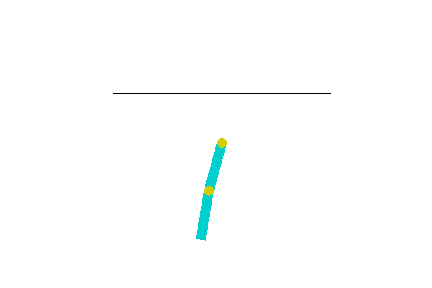
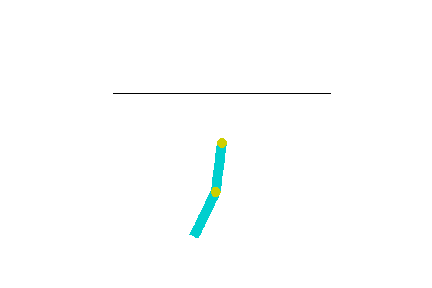
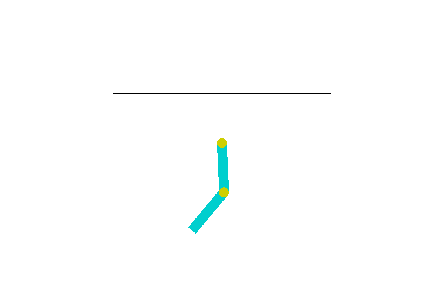
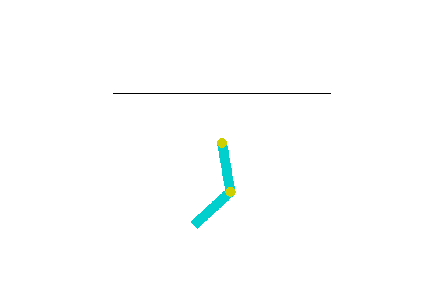
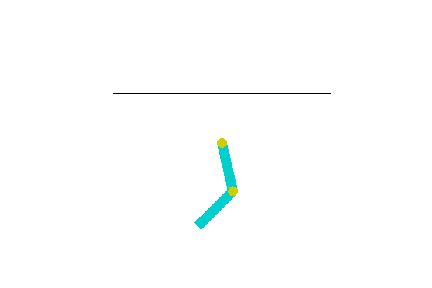
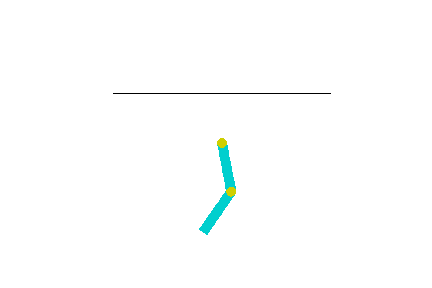
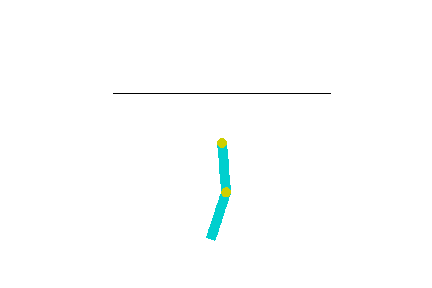
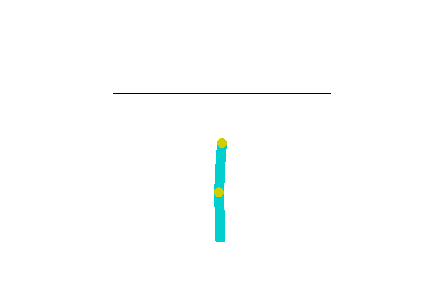
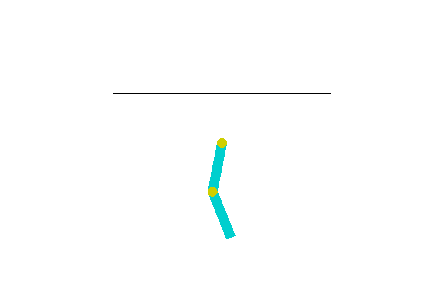
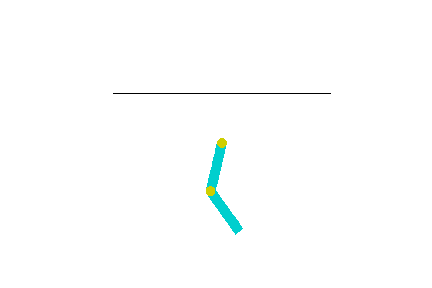
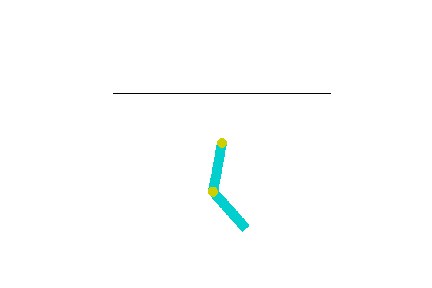
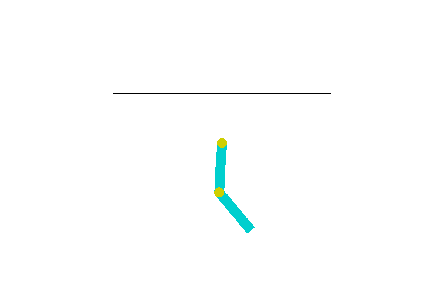
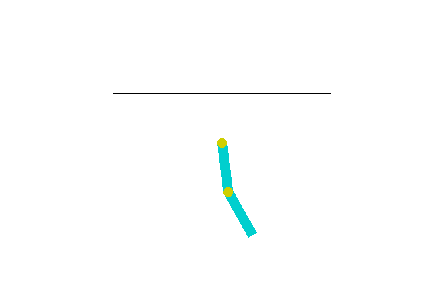
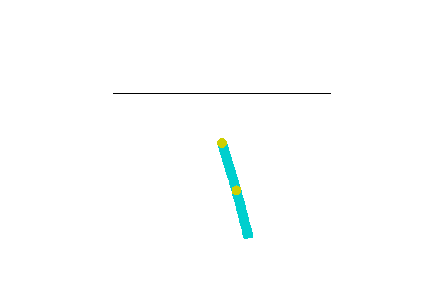
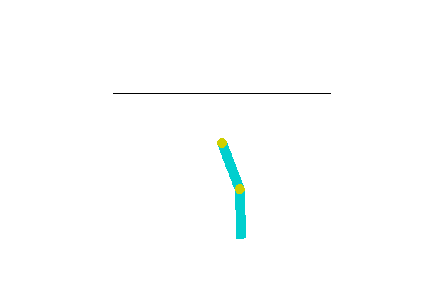
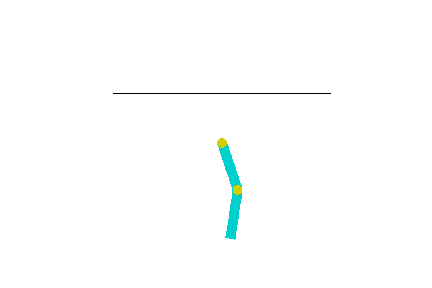
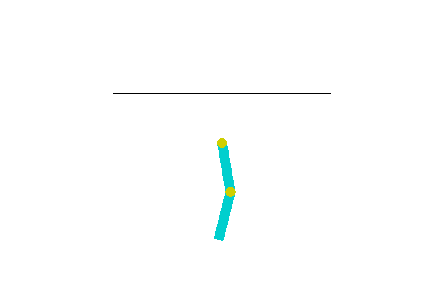
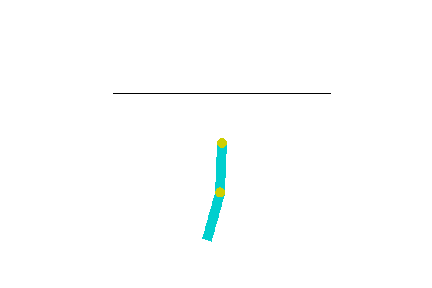
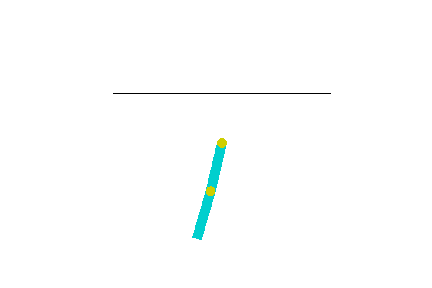
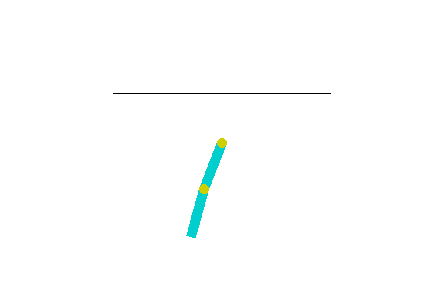
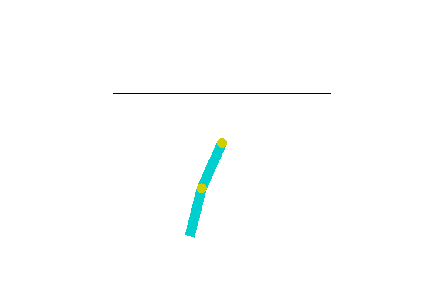
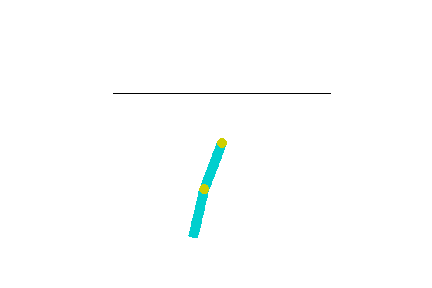
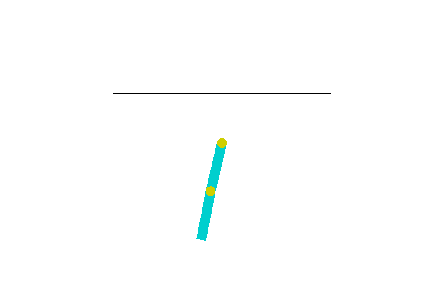
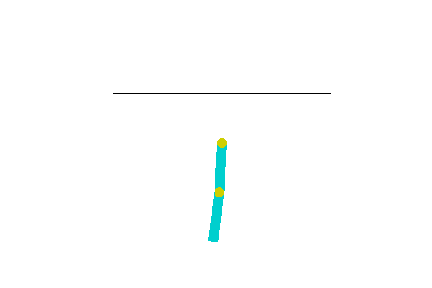
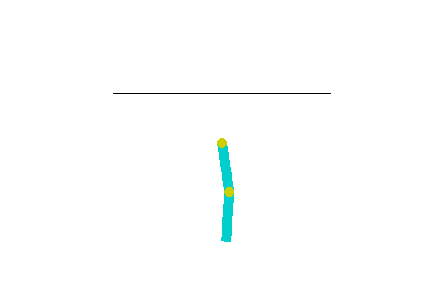
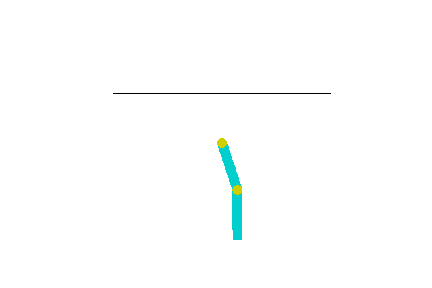
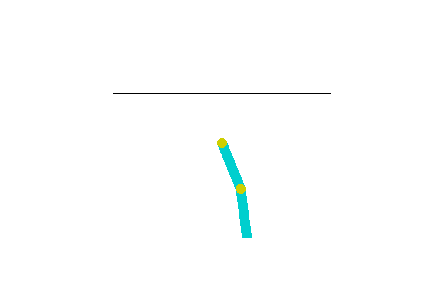
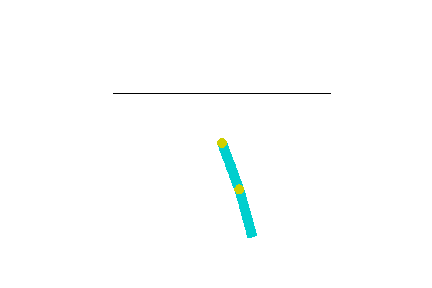
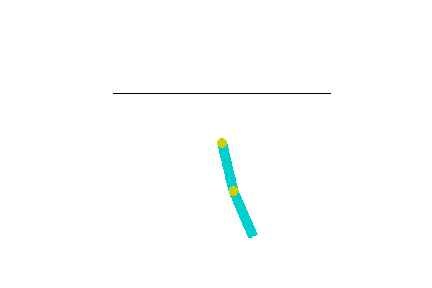
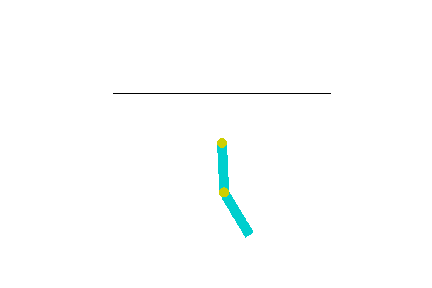
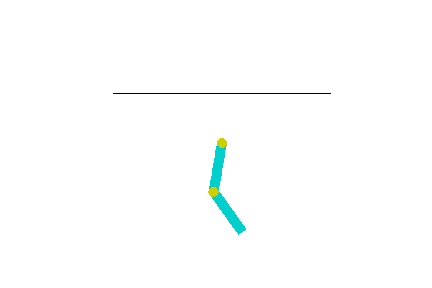
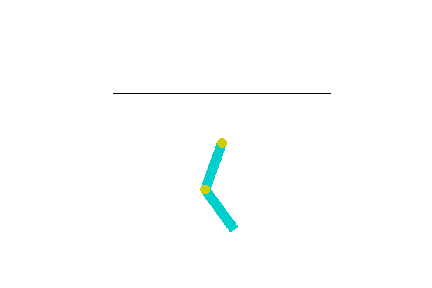
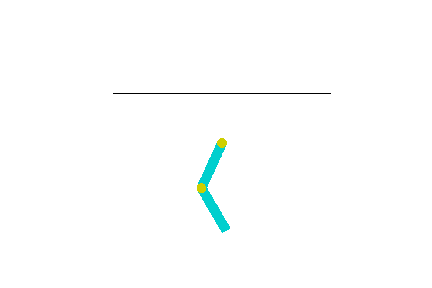
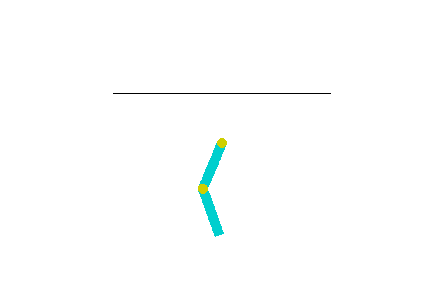
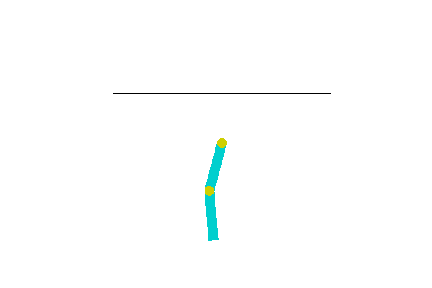
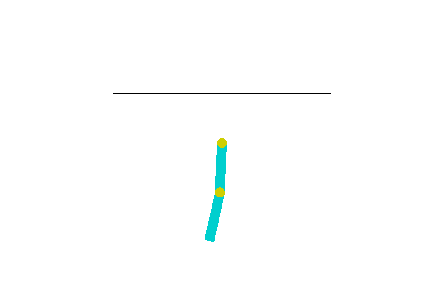
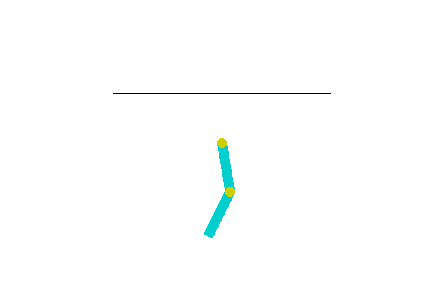
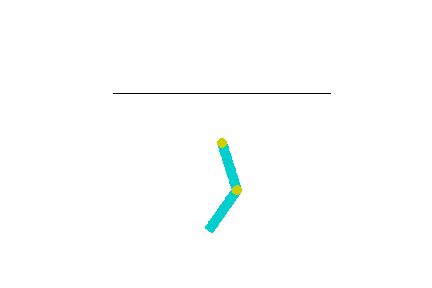
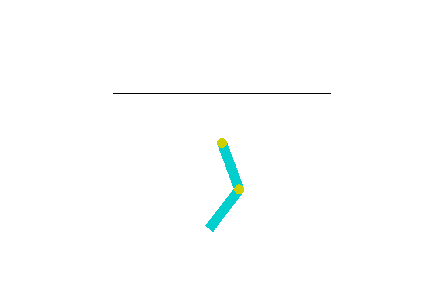
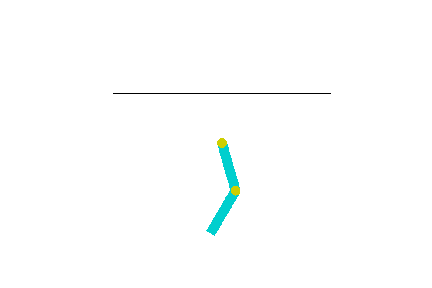
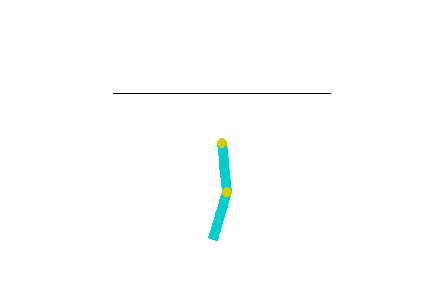
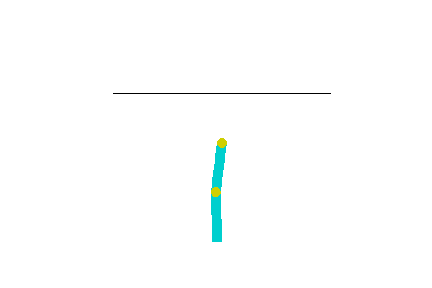
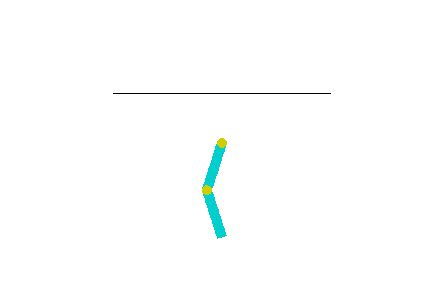
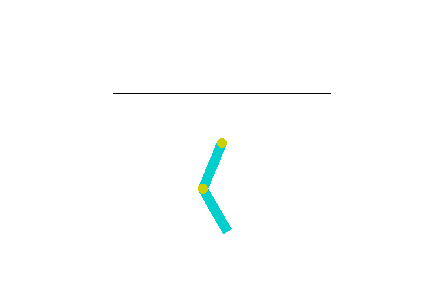
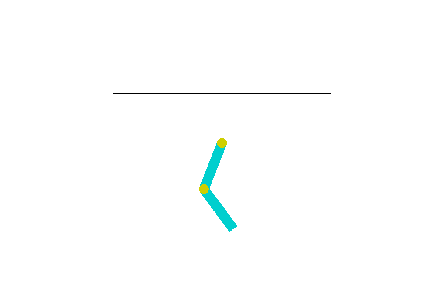
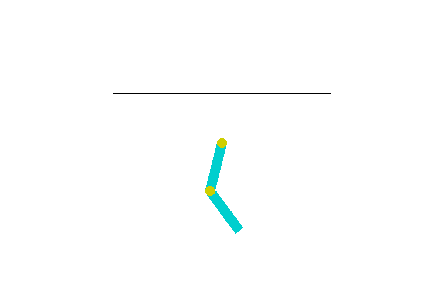
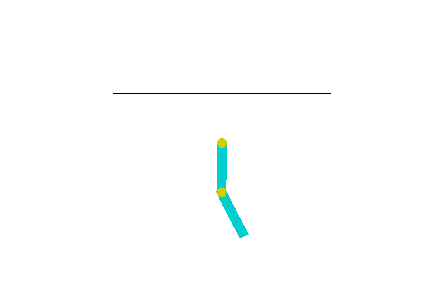
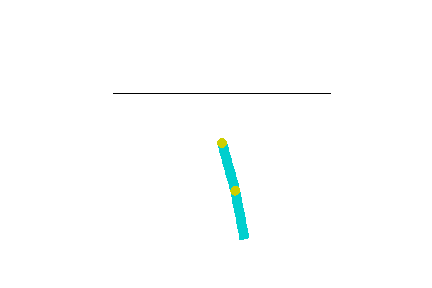
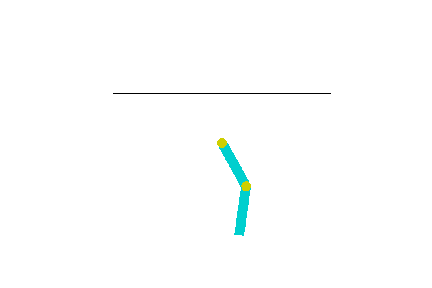
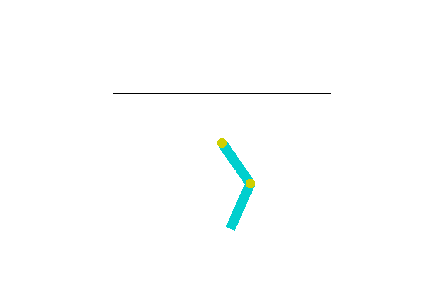
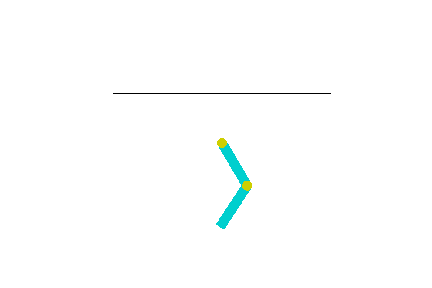
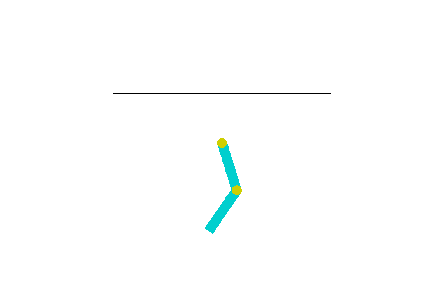
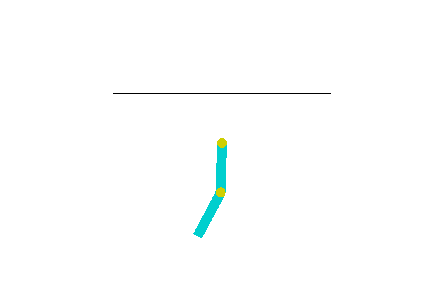
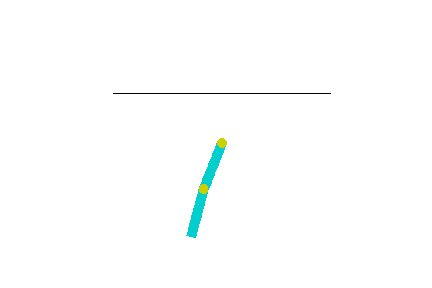
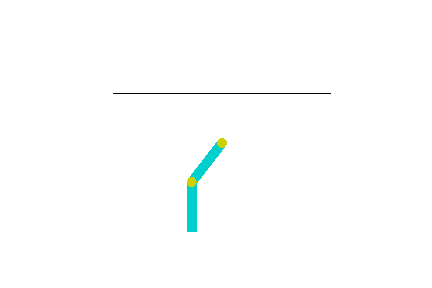
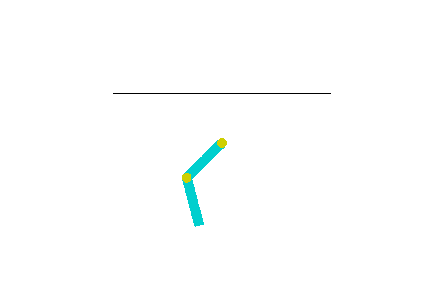
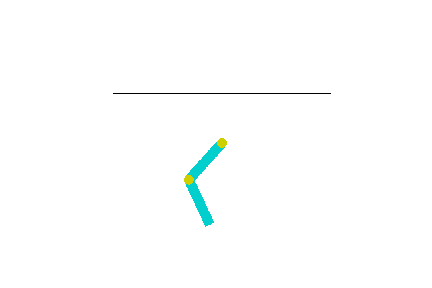
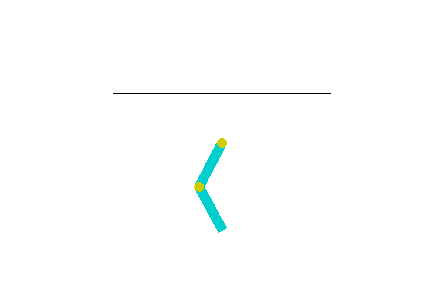
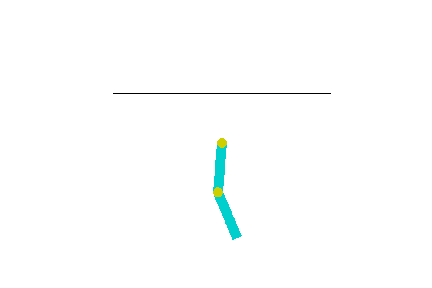
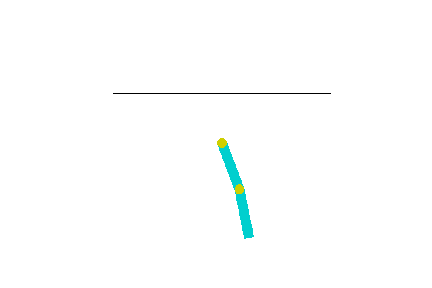
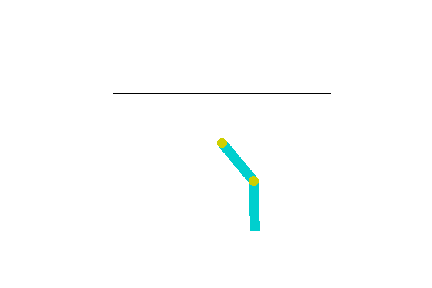
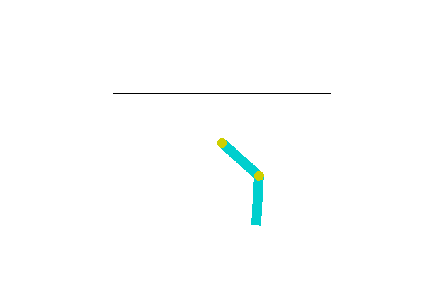
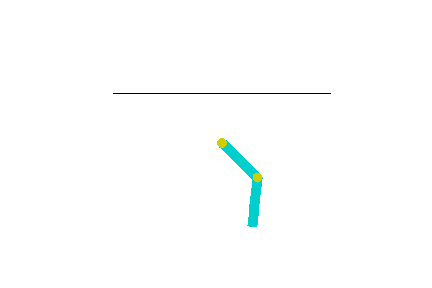
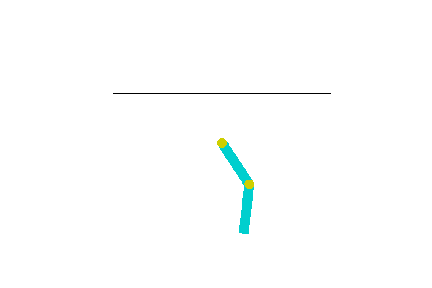
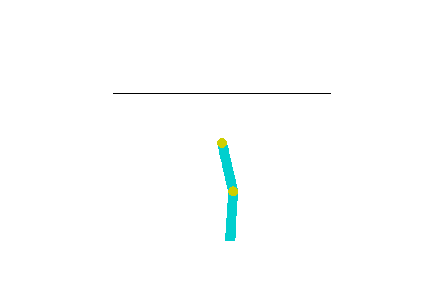
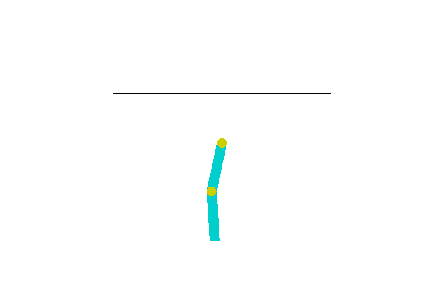
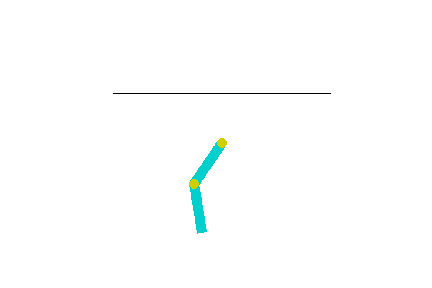
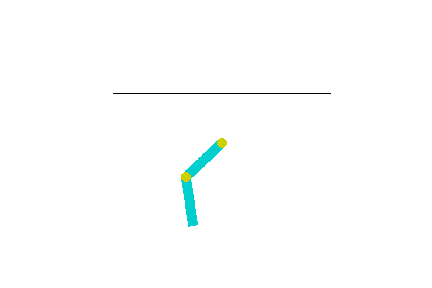
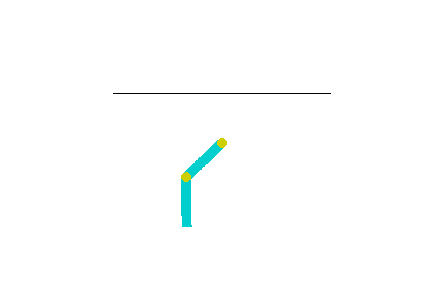
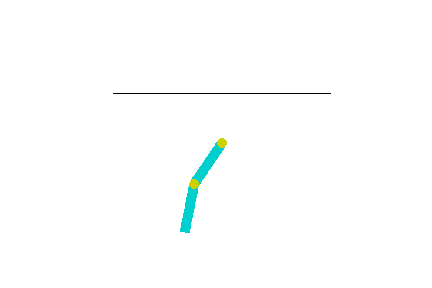
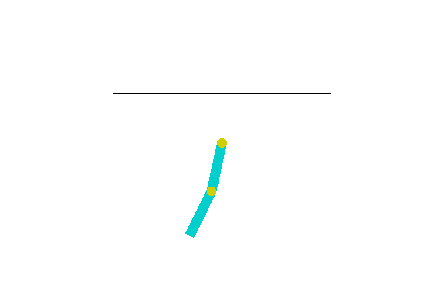
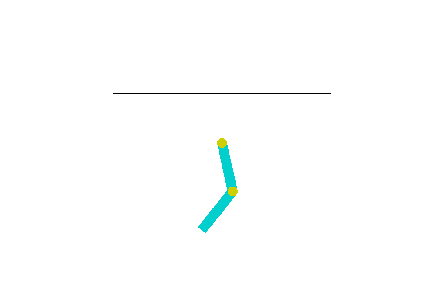
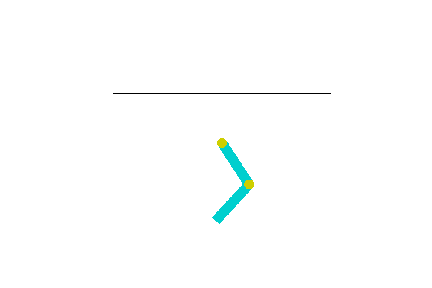
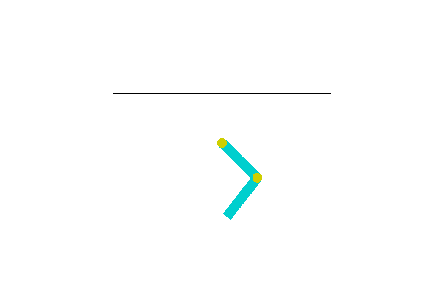
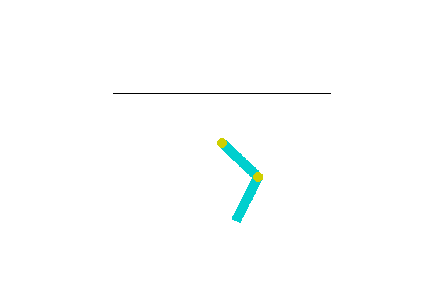
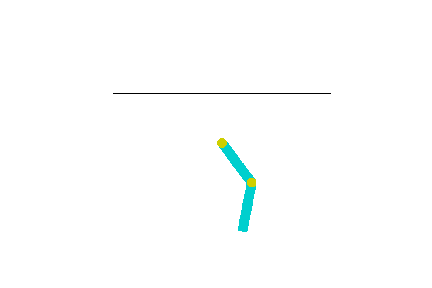
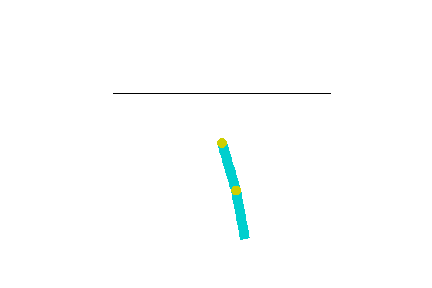
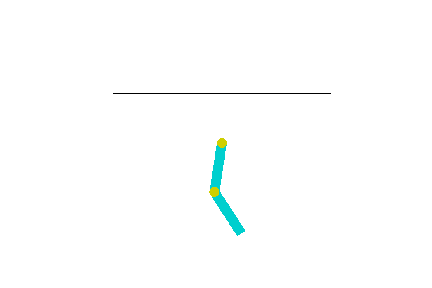
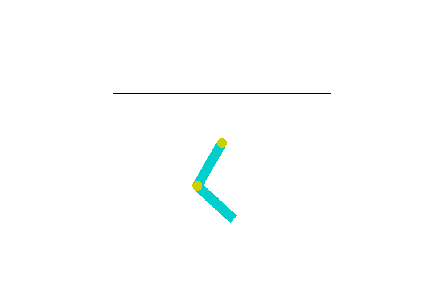
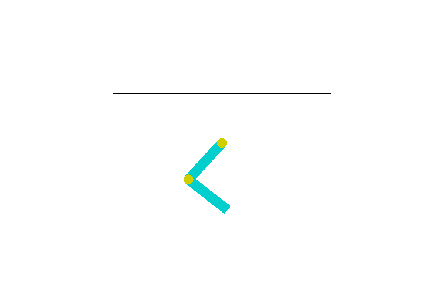
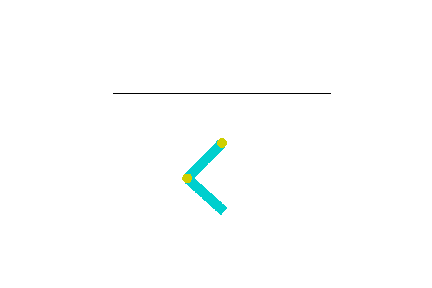
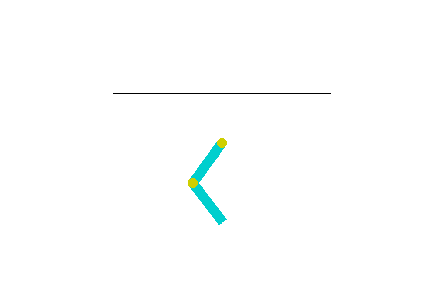
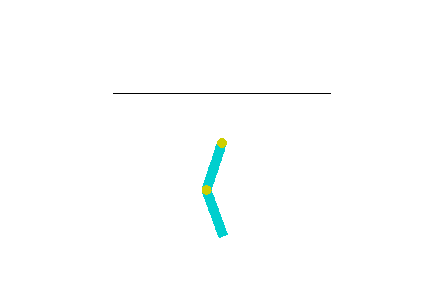
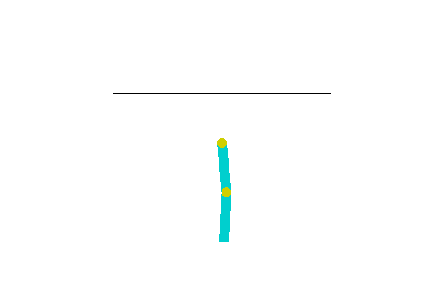
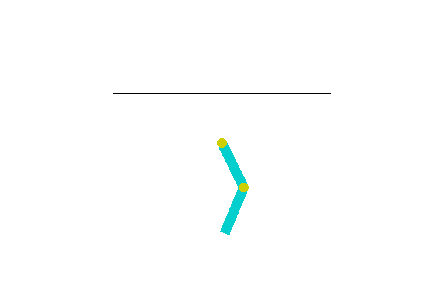
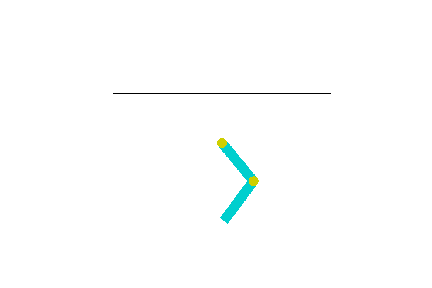
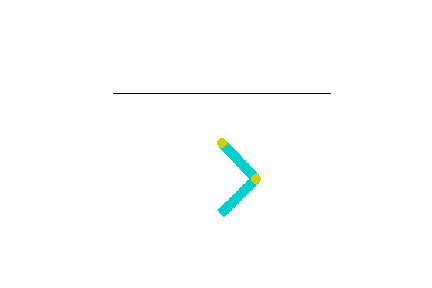
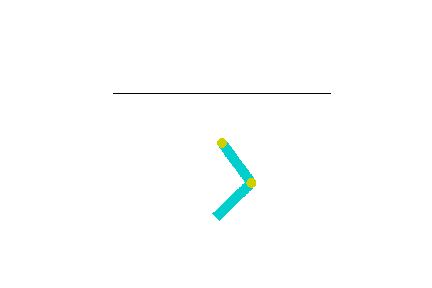
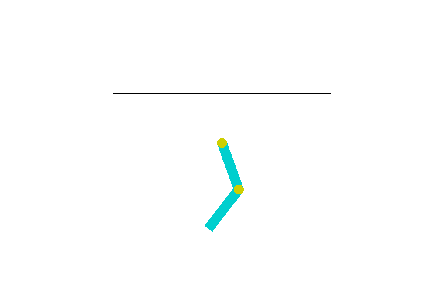
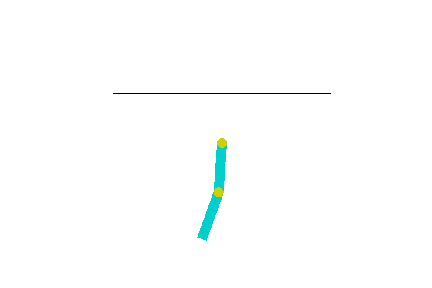
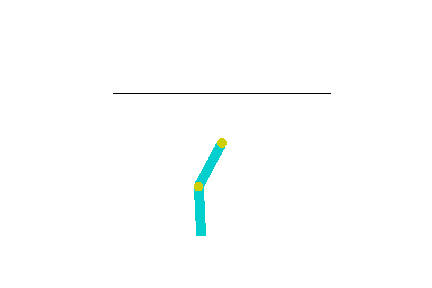
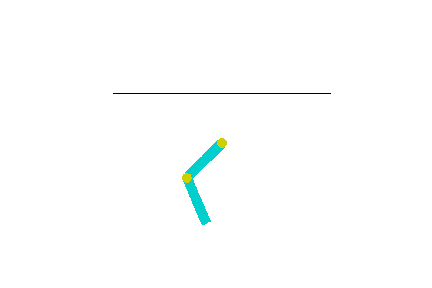
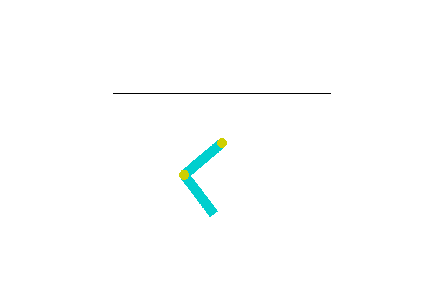

In [22]:
observation = env.reset()  # 環境はリセットする
frames = []  # 環境情報
while True:
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()
display_frames_as_gif(frames)

仲介クラスの作成

In [23]:
class AcrobotProcessor(Processor):

    def __init__(self):
        self.act2val = {0: 0, 1: 1, 2: 2}
    
    def process_action(self, action):
        return self.act2val[action]
    
    def process_reward(self, reward):
        return reward + 1

仲介クラスを定義

In [24]:
processor = AcrobotProcessor()

入力の次元数を定義

In [25]:
input_shape = (1,) + env.observation_space.shape
input_shape

(1, 6)

とれる行動数を指定  
環境内の変数を使ってみる

In [26]:
n_act = env.action_space.n

モデルを定義  
入力次元数以外はPendulum-v0と同じ

In [27]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(n_act))
model.add(Activation('linear'))

ボルツマン分布を利用したソフトマックス手法をε-greedyに組み合わせる

In [28]:
policy = MaxBoltzmannQPolicy(eps=0.01)

その他エージェントに関わるクラスを定義  
Pendulum-v0と同じ

In [29]:
memory = SequentialMemory(limit=50000, window_length=1)

dqn = DQNAgent(model=model,
               nb_actions=n_act,
               memory=memory,
               policy=policy,
               processor=processor,
               nb_steps_warmup=10,
               target_model_update=1e-2,
               enable_dueling_network=True,
               gamma=0.99,
)

エージェントを定義

In [30]:
dqn.compile(Adam(lr=1e-3), metrics=["mae"])
print(dqn.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2_input (InputLayer) (None, 1, 6)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                112       
_________________________________________________________________
activation_4 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
__________

50000ステップ学習させる

In [31]:
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 25:33 - reward: 0.0000e+00

/home/takamichi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 76s 8ms/step - reward: 0.0027
37 episodes - episode_reward: 0.730 [0.000, 1.000] - loss: 0.001 - mean_absolute_error: 0.087 - mean_q: 0.064

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: 0.0089
89 episodes - episode_reward: 1.000 [1.000, 1.000] - loss: 0.000 - mean_absolute_error: 0.308 - mean_q: 0.468

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 74s 7ms/step - reward: 0.0092
92 episodes - episode_reward: 1.000 [1.000, 1.000] - loss: 0.000 - mean_absolute_error: 0.350 - mean_q: 0.526

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: 0.0100
100 episodes - episode_reward: 1.000 [1.000, 1.000] - loss: 0.000 - mean_absolute_error: 0.360 - mean_q: 0.542

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: 0.0094
done, took 386.057 seconds


テスト

In [32]:
dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 1.000, steps: 78
Episode 2: reward: 1.000, steps: 97
Episode 3: reward: 1.000, steps: 71
Episode 4: reward: 1.000, steps: 83
Episode 5: reward: 1.000, steps: 234



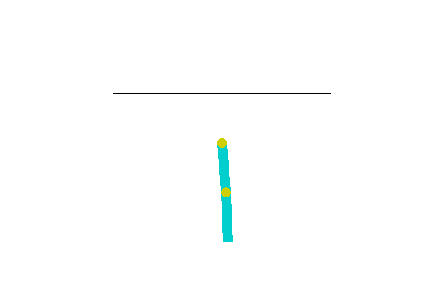
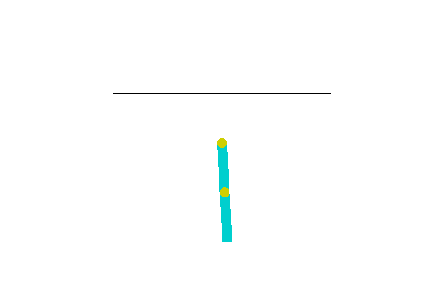
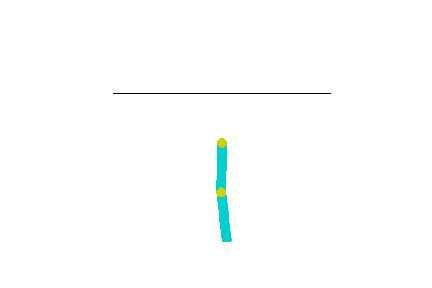
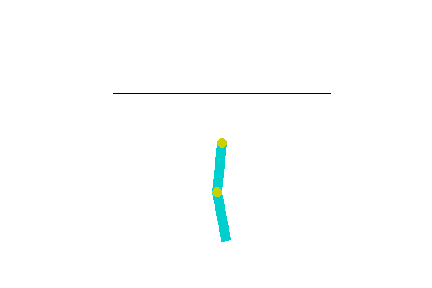
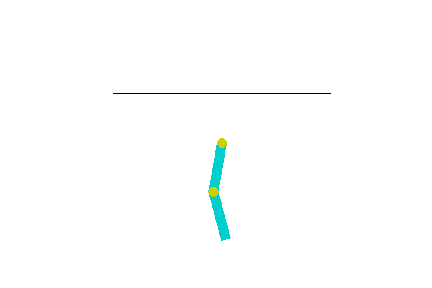
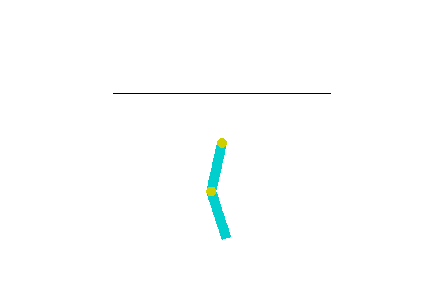
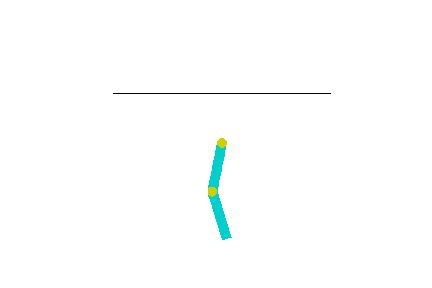
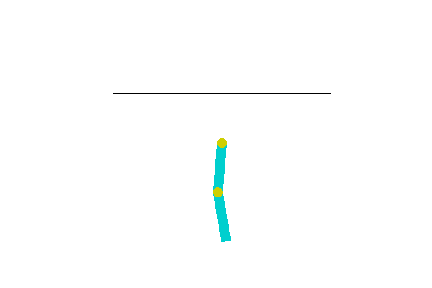
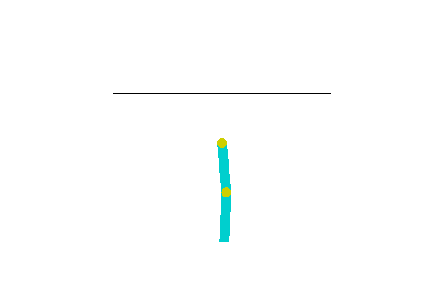
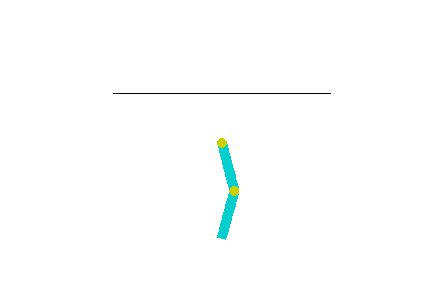
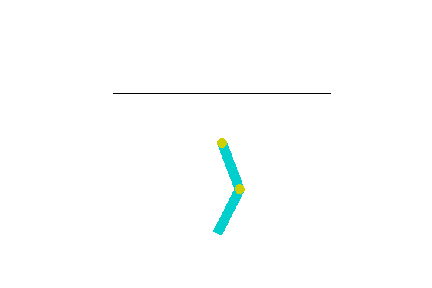
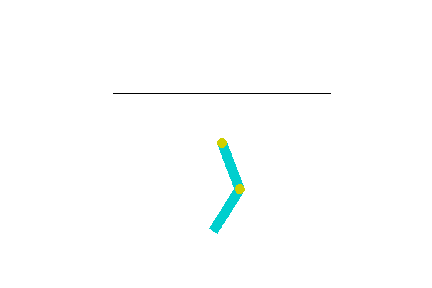
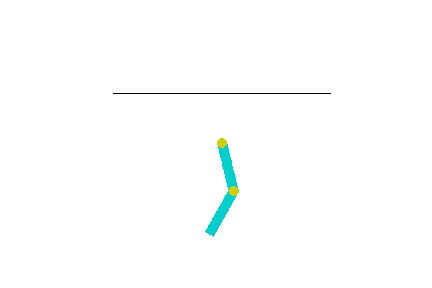
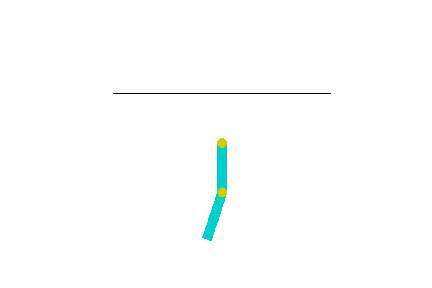
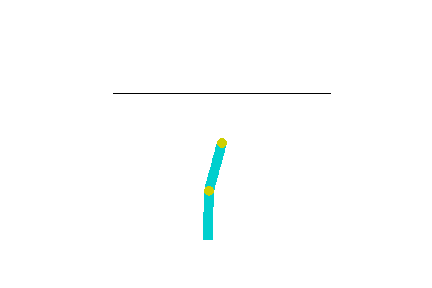
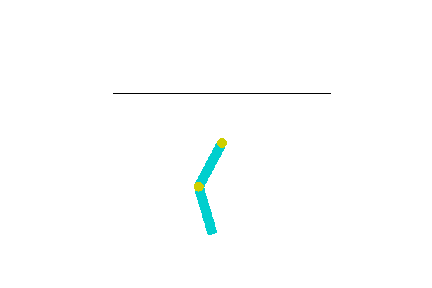
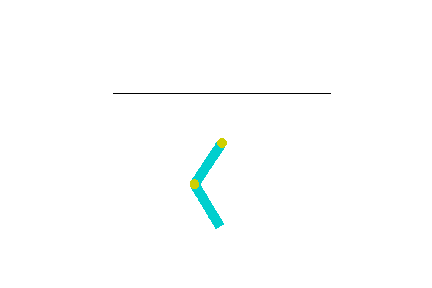
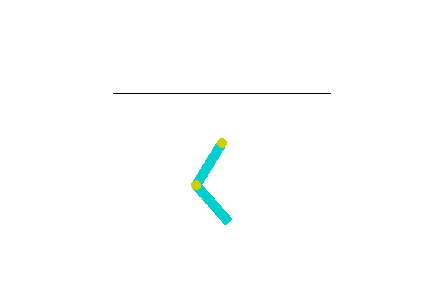
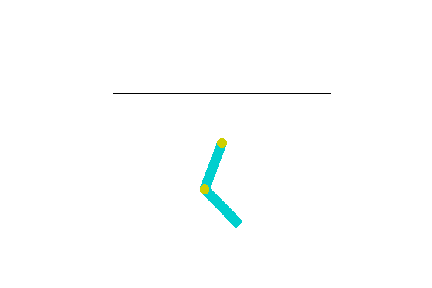
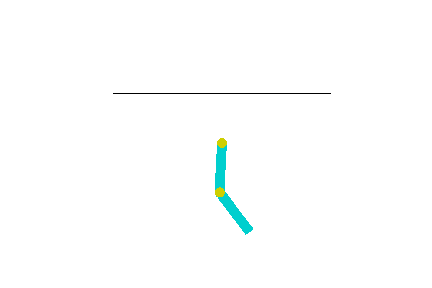
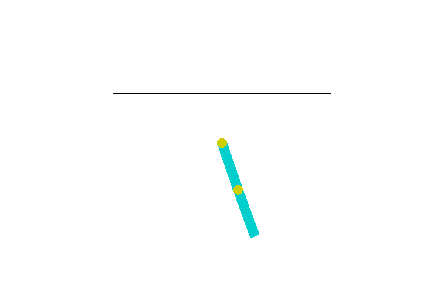
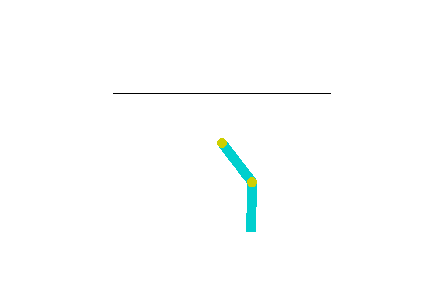
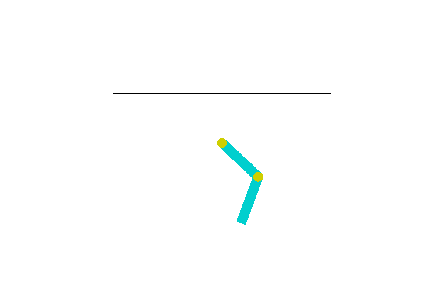
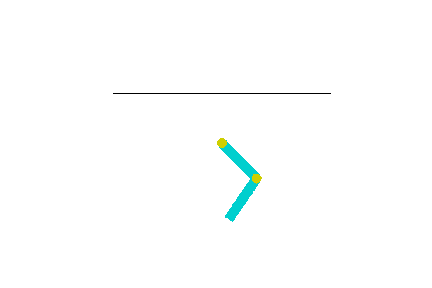
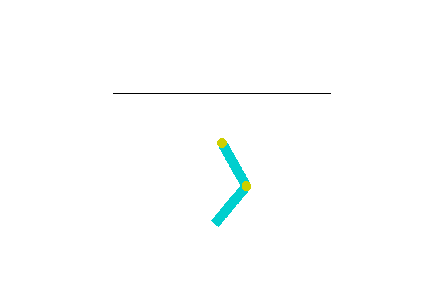
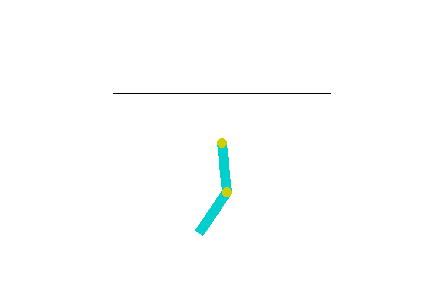
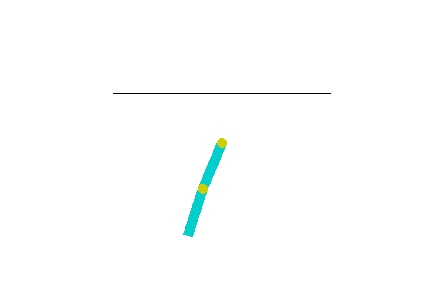
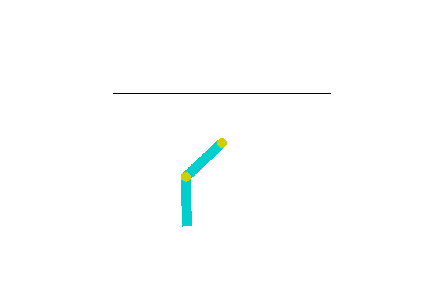
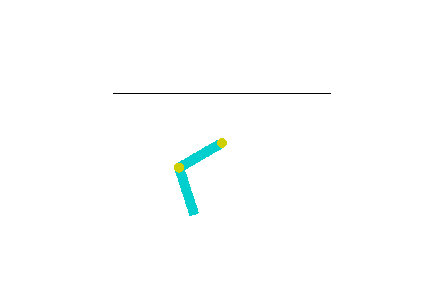
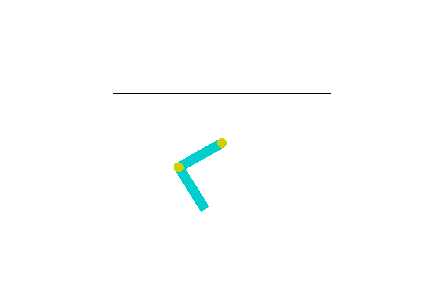
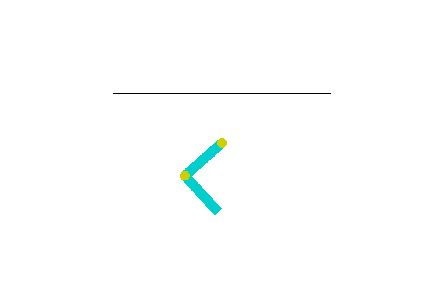
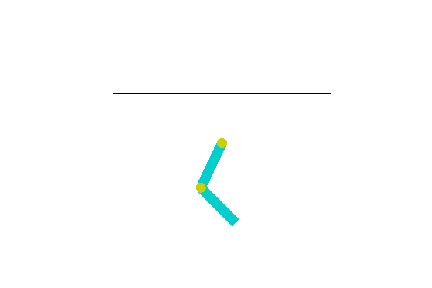
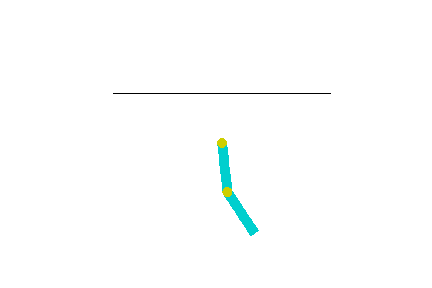
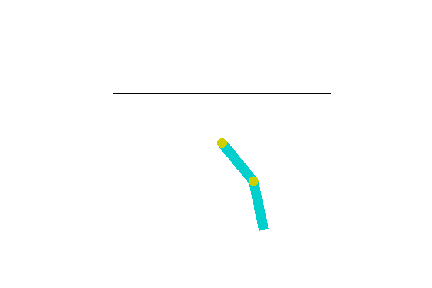
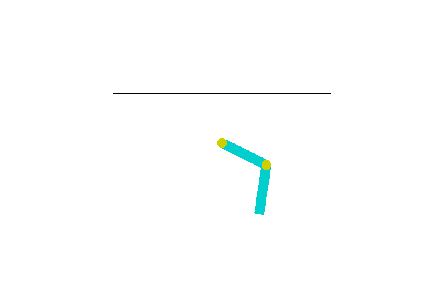
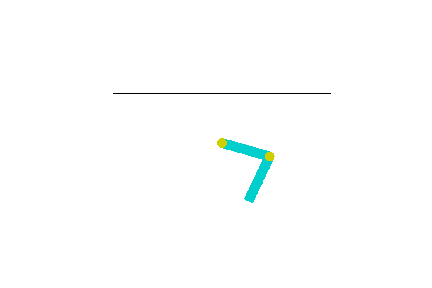
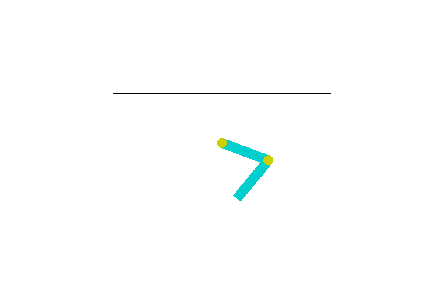
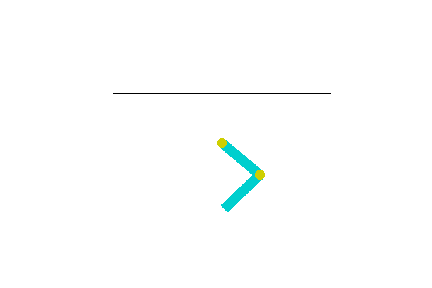
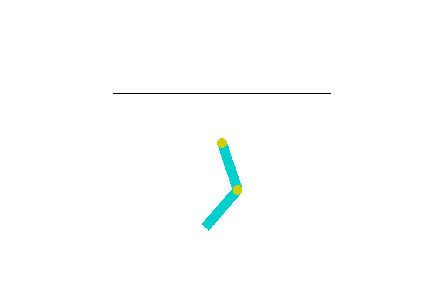
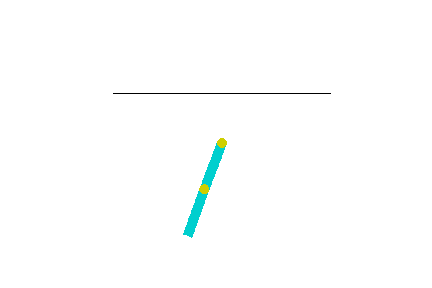
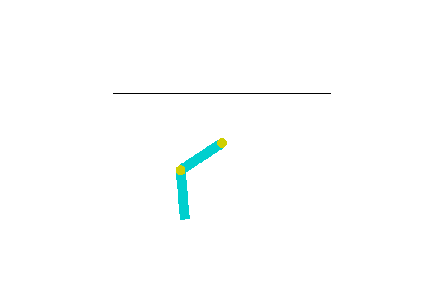
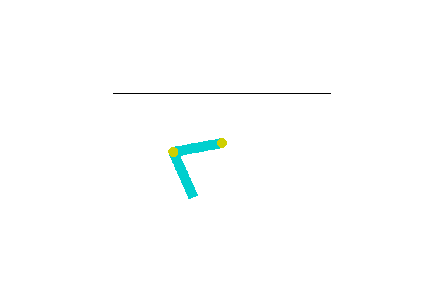
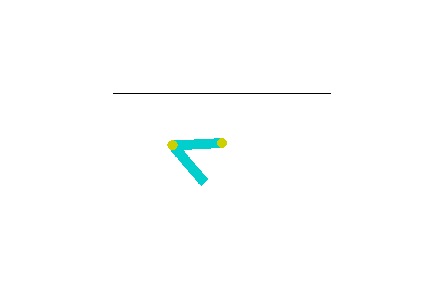
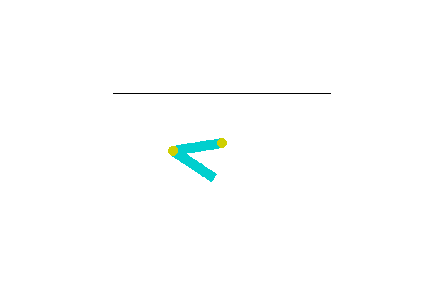
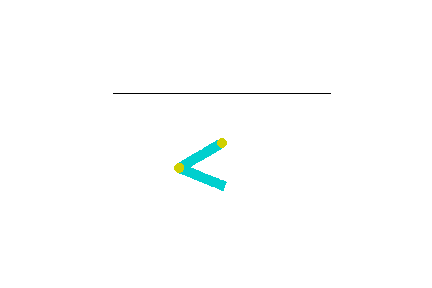
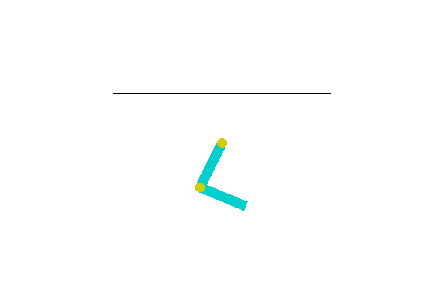
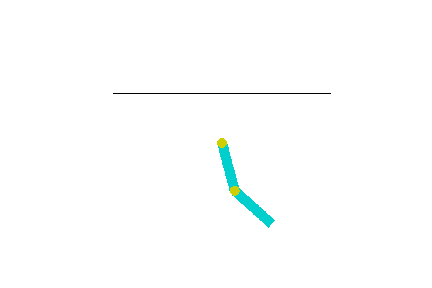
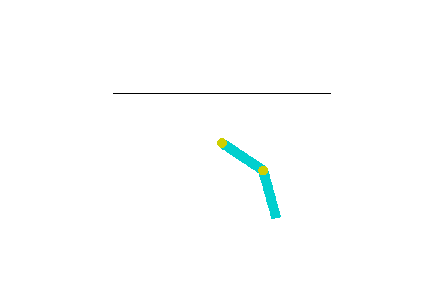
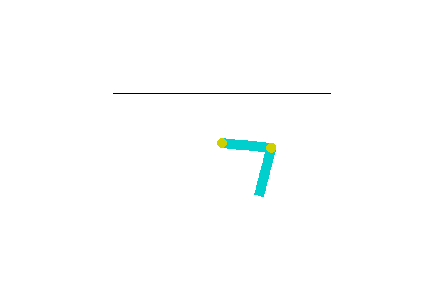
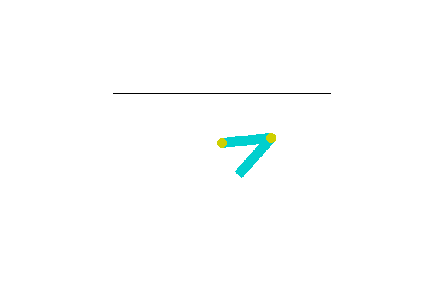
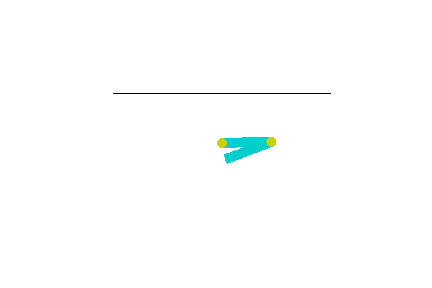
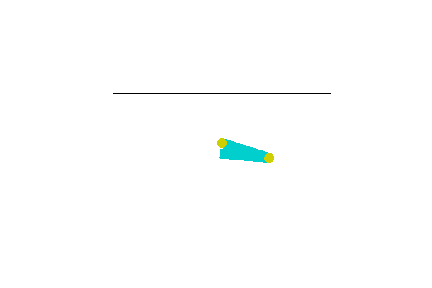
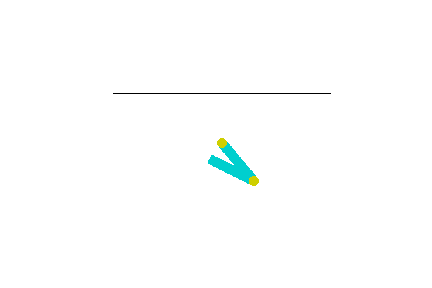
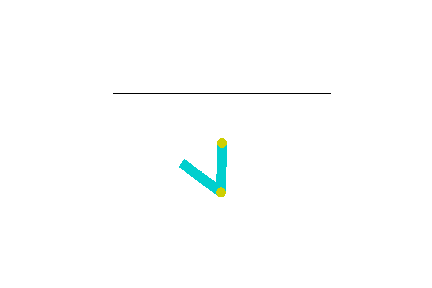
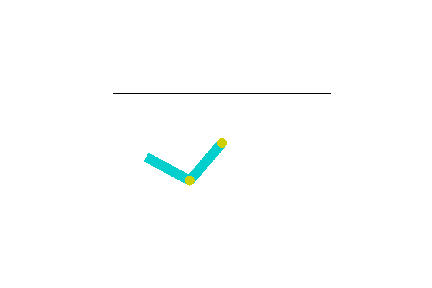
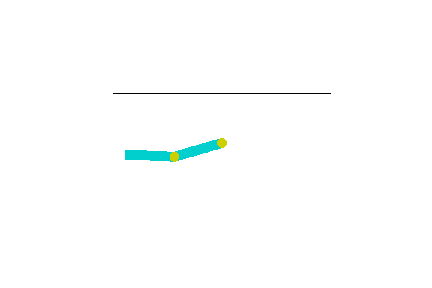
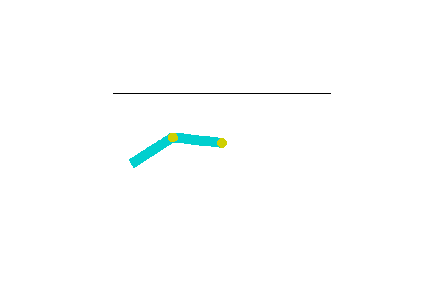
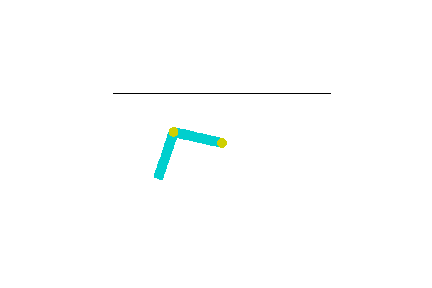
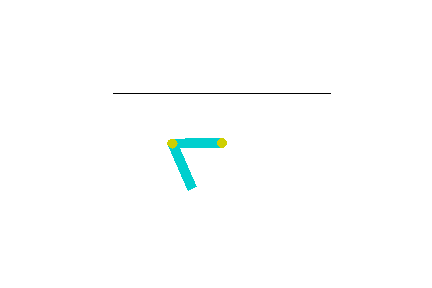
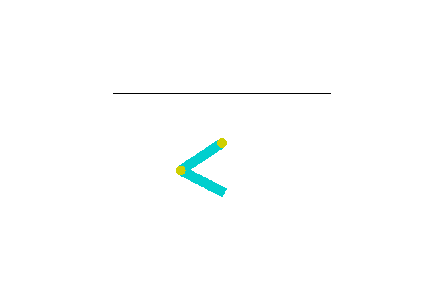
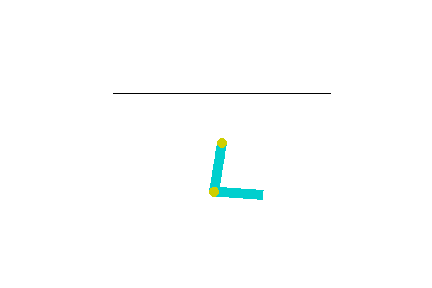
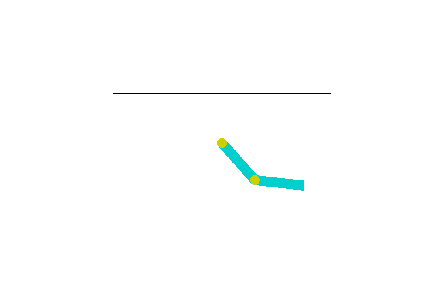
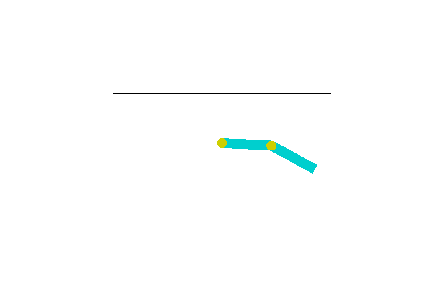
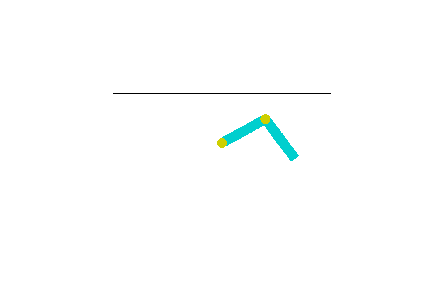
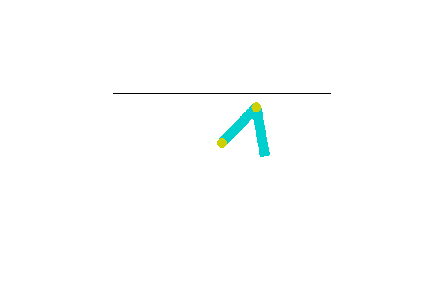
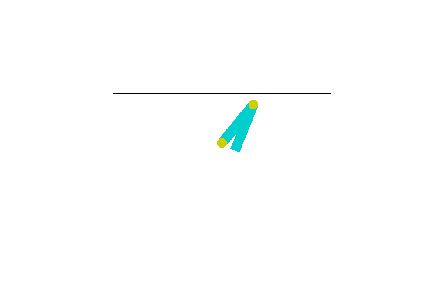
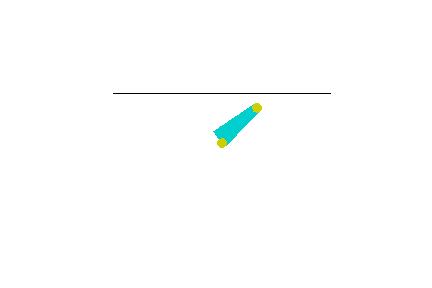
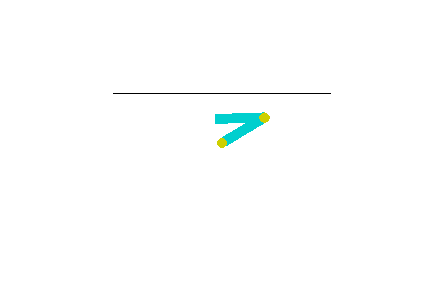
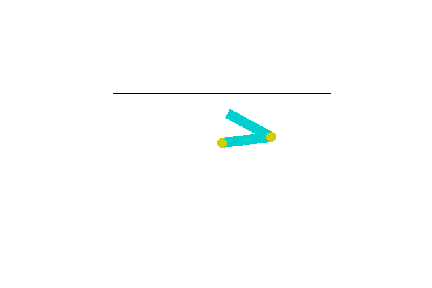
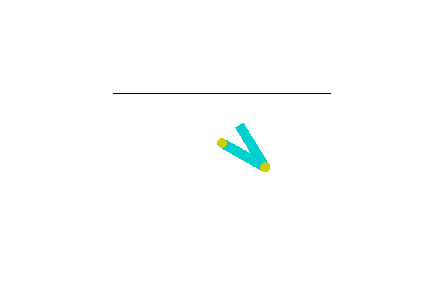
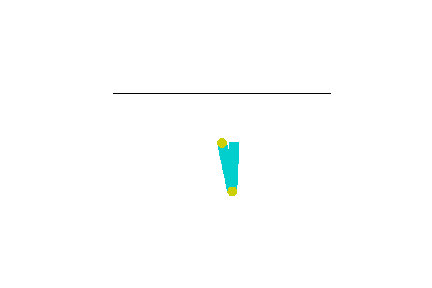
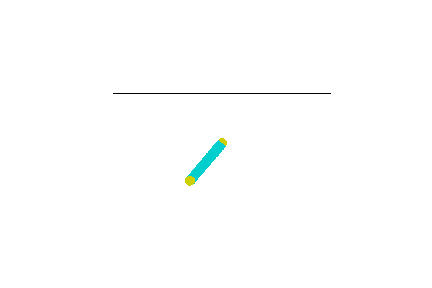
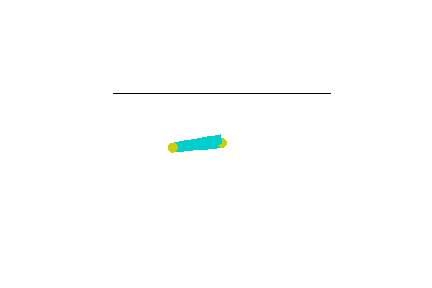
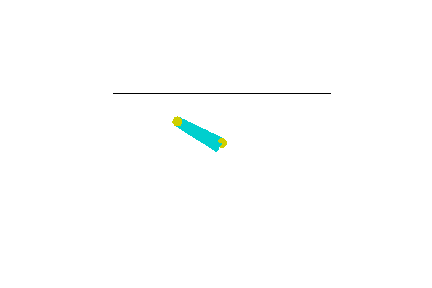
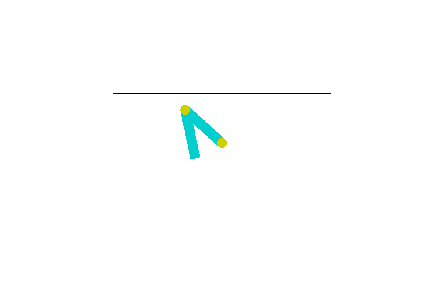
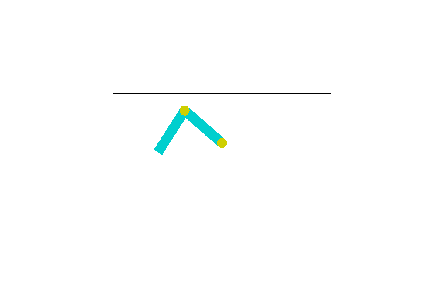
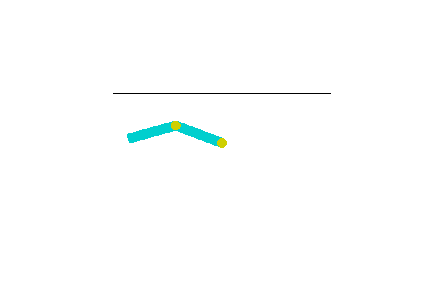
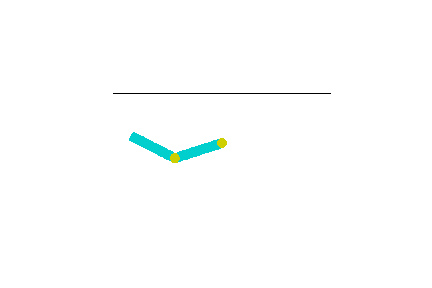
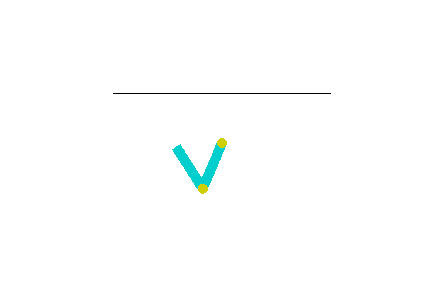
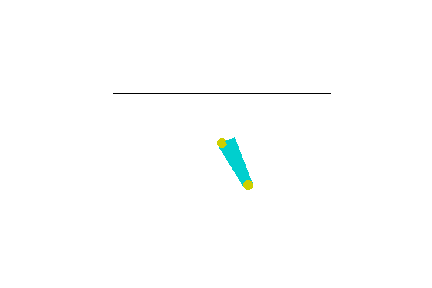
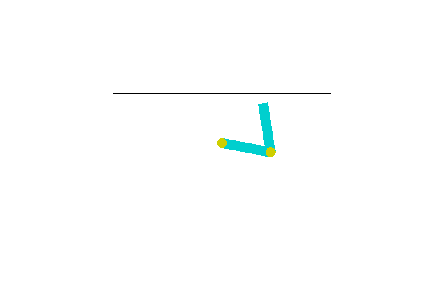

80


In [33]:
observation = env.reset()  # 環境はリセットする
dqn.reset_states()  # エージェントのメモリーをリセット
dqn.training = False  # 学習モードをOFF
frames = []  # 環境情報
step = 0
while True:
    frames.append(env.render(mode='rgb_array'))
    action = processor.act2val[dqn.forward(observation)]
    observation, reward, done, info = env.step(action)
    if done:
        break
    step += 1
env.close()
display_frames_as_gif(frames)
print(step)

##### ネットワーク

DQNAgentクラスのパラメータ

- Double DQNを使う
```python
enable_double_dqn=True
```
- 直近の報酬を大切にする
```python
gamma=0.95  # 0.95 <= gamma <= 0.99
```